# AdEase Time Series

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically. The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.

You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days, and forecasting the number of views so that you can predict and optimize the ad placement for your clients. You are provided with the data of 145k wikipedia pages and daily view count for each of them. Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

### Data Dictionary:

There are two csv files given

train_1.csv: In the csv file, each row corresponds to a particular article and each column corresponds to a particular date. The values are the number of visits on that date.

The page name contains data in this format:

SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACCESS TYPE _ ACCESS ORIGIN

having information about the page name, the main domain, the device type used to access the page, and also the request origin(spider or browser agent)

Exog_Campaign_eng: This file contains data for the dates which had a campaign or significant event that could affect the views for that day. The data is just for pages in English.

There’s 1 for dates with campaigns and 0 for remaining dates. It is to be treated as an exogenous variable for models when training and forecasting data for pages in English

## Additional views:

In this case study, our focus is to analyze and forecast user views for various category of Wikipedia pages; Our scope in this case study is limited to using language as the category. We will begin our solution with pre-processing activities such as aggregation of duplicate pages, removal of non-wikipedia pages (including wikimedia.org or mediawiki.org), and extraction of title, access_type, access_orig, and language features from each page. After that, we analyze missing values for each page. Broadly, we categorize missing values (or NANs) into three categories: leading NANs (pages didn't exist at that point in time), trailing NANs (discontinued pages), and in-between NANs (genuine missing values). We impute the missing values in these categories using different approaches as described later. As the last pre-processing step, we aggregate page views at language level. We then analyze various time series, plot their graphs and ACF/PACF functions, check their stationarity (Dickey Fuller test), and apply d-order differencing and/or seasonal differencing to make them stationary. In the final section, we build various time series models using ARIMA, SARIMA/SARIMAX, and Prophet. As part of SARIMAX modeling, we create a custom wrapper SKLearn estimator to use GridSeachCV for hyper parameter tuning. We will use MAPE as the evaluation/performance metric.

**Imp Notes:** 

1. In this case-study, we will mainly perform time series analysis for 'en' language pages. 

2. We will create utility functions for hyper-parameter tuning, best parameter selection (based on least MAPE criterion), final model building, and to plot forecasts. Thus, for each language, we can run all the steps with a single function call. We will, however, not build sklearn pipelines as there are not many pre-processing steps involved here. 

# Solution

## Data import and analysis

In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from IPython.display import Markdown, display

#set seaborn theme
sns.set_theme(style="whitegrid", palette="deep")

In [2]:
df = pd.read_csv('train_1.csv')
df.head()

Page  2015-07-01  2015-07-02  \
0            2NE1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2PM_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3C_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  2016-12-25  \
0        26.0  ...        32.0        63.0        15.0        26.0   
1        10.0  ...        17.0        42.0        28.0        15.0   
2         4.0  ...         3.0         1.0         1.0         7.0   
3        11.0  ...        32.0        10.0        26.0        27.0   
4         NaN  ...        48.0         9.0        25.0        13.0   

   2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  2016-12-31  
0        14.0        20.0        22.0        19.0        18.0        20.0  
1         9.0        30.0        52.0        45.0        26.0        20.0  
2         4.0         4.0         6.0         3.0         4.0        17.0  
3        16.0        11.0        17.0        19.0        10.0        11.0  
4         3.0        11.0        27.0        13.0        36.0        10.0  

[5 rows x 551 columns]

In [3]:
df.shape

(145063, 551)

In [4]:
#check missing values
df.isna().sum(axis=1)

0           0
1           0
2           0
3           0
4         291
         ... 
145058    544
145059    550
145060    550
145061    550
145062    550
Length: 145063, dtype: int64

<AxesSubplot:ylabel='Count'>

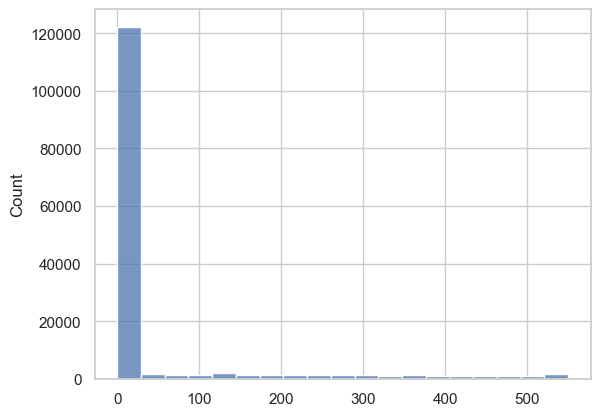

In [5]:
#plot missing values
sns.histplot(df.isna().sum(axis=1))

### Process 'Page'

In [6]:
#convert to lower case and remove whitespaces.
df['Page'] = df['Page'].str.strip().str.lower()

In [7]:
#find the number of URLs containing wikipedia.org text
wikipedia_url_mask = df['Page'].str.contains('wikipedia.org')

print(f'total URLs : {df.shape[0]}')
print(f'total URLs containing wikipedia.org : {wikipedia_url_mask.sum()}')
print(f'% of URLs containing wikipedia.org : {np.round((wikipedia_url_mask.sum()/df.shape[0]) * 100, 2)}')

total URLs : 145063
total URLs containing wikipedia.org : 127226
% of URLs containing wikipedia.org : 87.7


In [8]:
#Examine URLs which do not contain wikipedia.org
non_wikipedia_urls = df[~wikipedia_url_mask]['Page']
#non_wikipedia_urls.to_csv('special_urls.csv')
non_wikipedia_urls.shape

(17837,)

In [9]:
# check the number of 'wikimedia.org' or 'mediawiki.org' URLs
(non_wikipedia_urls.str.contains('wikimedia.org') | non_wikipedia_urls.str.contains('mediawiki.org')).sum()

17837

**Observation:** We see that all the non-wikipedia.org URLs are either wikimedia.org or mediawiki.org URLs. We will not consider them in the further analysis and drop them. 

In [10]:
# remove ALL non-wikipedia URLs from the data-frame
df = df[wikipedia_url_mask]
df.reset_index(drop=True, inplace=True)

### Check for duplicate pages

In [11]:
#find duplicate pages
res = df.groupby('Page').agg({'Page': 'count'})
dup_pages = res[res['Page'] > 1].index
mask_dup_pages = df['Page'].isin(dup_pages)
df[mask_dup_pages].sort_values(by='Page')

Page  2015-07-01  \
30851  2016_nfl_draft_en.wikipedia.org_all-access_all...        11.0   
33290  2016_nfl_draft_en.wikipedia.org_all-access_all...       102.0   
28368  2016_nfl_draft_en.wikipedia.org_all-access_spider         8.0   
25919  2016_nfl_draft_en.wikipedia.org_all-access_spider         1.0   
8405   2016_nfl_draft_en.wikipedia.org_desktop_all-ag...         6.0   
...                                                  ...         ...   
16918  леди_баг_и_супер-кот_ru.wikipedia.org_mobile-w...         NaN   
87249  мстители:_война_бесконечности_ru.wikipedia.org...         NaN   
87146  мстители:_война_бесконечности_ru.wikipedia.org...         NaN   
87139   партия_роста_ru.wikipedia.org_desktop_all-agents         NaN   
87118   партия_роста_ru.wikipedia.org_desktop_all-agents         NaN   

       2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  \
30851        19.0         9.0        10.0        15.0        12.0        23.0   
33290       129.0       135.0       105.0       116.0       111.0       190.0   
28368         8.0        13.0        27.0         6.0         5.0        30.0   
25919        12.0         4.0         3.0         9.0         0.0        16.0   
8405         14.0         7.0         5.0        11.0         8.0        19.0   
...           ...         ...         ...         ...         ...         ...   
16918         NaN         NaN         NaN         NaN         NaN         NaN   
87249         NaN         NaN         NaN         NaN         NaN         NaN   
87146         NaN         NaN         NaN         NaN         NaN         NaN   
87139         NaN         NaN         NaN         NaN         NaN         NaN   
87118         NaN         NaN         NaN         NaN         NaN         NaN   

       2015-07-08  2015-07-09  ...  2016-12-22  2016-12-23  2016-12-24  \
30851        12.0        12.0  ...      5814.0      8017.0      7894.0   
33290       170.0       244.0  ...       411.0       264.0       305.0   
28368        10.0        14.0  ...        25.0        17.0         9.0   
25919         2.0         5.0  ...        39.0        32.0        49.0   
8405         11.0        10.0  ...      2598.0      2526.0      2192.0   
...           ...         ...  ...         ...         ...         ...   
16918         NaN         NaN  ...         7.0         4.0         3.0   
87249         NaN         NaN  ...         NaN         NaN         NaN   
87146         NaN         NaN  ...       945.0       943.0       999.0   
87139         NaN         NaN  ...       127.0       128.0        74.0   
87118         NaN         NaN  ...         6.0         4.0         6.0   

       2016-12-25  2016-12-26  2016-12-27  2016-12-28  2016-12-29  2016-12-30  \
30851      7937.0      8557.0     18529.0      7774.0      7173.0      6385.0   
33290       316.0       365.0       618.0       388.0       299.0       270.0   
28368        12.0        31.0        14.0        39.0         6.0        39.0   
25919       106.0        70.0        86.0        82.0        43.0        43.0   
8405       2267.0      2587.0      4817.0      3205.0      2892.0      2438.0   
...           ...         ...         ...         ...         ...         ...   
16918         3.0         5.0         5.0         7.0         4.0         6.0   
87249         NaN         NaN         NaN         NaN         NaN         NaN   
87146      1136.0       926.0       821.0       825.0       860.0       891.0   
87139       119.0       103.0       120.0       121.0        88.0        79.0   
87118         8.0         4.0         7.0         3.0        12.0         3.0   

       2016-12-31  
30851      7270.0  
33290       361.0  
28368        77.0  
25919        39.0  
8405       1973.0  
...           ...  
16918         5.0  
87249         NaN  
87146       586.0  
87139        41.0  
87118         2.0  

[166 rows x 551 columns]

**Observations:** As we observe, there are several duplicate page names. We will aggregate them into single row per such page by summing their visit counts.

In [12]:
#aggregate duplicate records into single record
def process_dup_pages(df):    
    ret = df.groupby('Page').sum().reset_index(drop=True)
    return ret

df_unique = df[~mask_dup_pages]
df_aggregated = df[mask_dup_pages].groupby('Page').apply(process_dup_pages)
df_aggregated.reset_index(inplace=True)
df_aggregated.drop(labels=['level_1'],axis=1, inplace=True)

df = pd.concat([df_unique, df_aggregated], ignore_index=True).reset_index(drop=True)

In [13]:
df.shape

(127143, 551)

### Extract title, lang, access type, and access origin

In [14]:
# Extract title, lang, acc_type, and acc_orig features
import re

#returns a tuple (title, lang, acc_type, acc_orig) for each row
def extract_features(page):
    ret = None
    res = re.match(r'(.+)_(.+)\.wikipedia\.org.*_([^_]+)_([^_]+)', page)
    if res is not None:
        ret = res.groups()
    return ret

#grps is a collecton of tuples containing extracted features
grps = df['Page'].transform(extract_features)

#convert tuple to dataframe
new_features = pd.DataFrame(data=grps.tolist(), columns=['title', 'lang', 'acc_type', 'acc_orig'])

#merge with existing dataframe on index
df = pd.merge(df, new_features, left_index=True, right_index=True)

In [15]:
df.head()

Page  2015-07-01  2015-07-02  \
0            2ne1_zh.wikipedia.org_all-access_spider        18.0        11.0   
1             2pm_zh.wikipedia.org_all-access_spider        11.0        14.0   
2              3c_zh.wikipedia.org_all-access_spider         1.0         0.0   
3         4minute_zh.wikipedia.org_all-access_spider        35.0        13.0   
4  52_hz_i_love_you_zh.wikipedia.org_all-access_s...         NaN         NaN   

   2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  2015-07-08  \
0         5.0        13.0        14.0         9.0         9.0        22.0   
1        15.0        18.0        11.0        13.0        22.0        11.0   
2         1.0         1.0         0.0         4.0         0.0         3.0   
3        10.0        94.0         4.0        26.0        14.0         9.0   
4         NaN         NaN         NaN         NaN         NaN         NaN   

   2015-07-09  ...  2016-12-26  2016-12-27  2016-12-28  2016-12-29  \
0        26.0  ...        14.0        20.0        22.0        19.0   
1        10.0  ...         9.0        30.0        52.0        45.0   
2         4.0  ...         4.0         4.0         6.0         3.0   
3        11.0  ...        16.0        11.0        17.0        19.0   
4         NaN  ...         3.0        11.0        27.0        13.0   

   2016-12-30  2016-12-31             title  lang    acc_type  acc_orig  
0        18.0        20.0              2ne1    zh  all-access    spider  
1        26.0        20.0               2pm    zh  all-access    spider  
2         4.0        17.0                3c    zh  all-access    spider  
3        10.0        11.0           4minute    zh  all-access    spider  
4        36.0        10.0  52_hz_i_love_you    zh  all-access    spider  

[5 rows x 555 columns]

In [16]:
# helper function to show percentages
def showpercent(ax, total):
    for p in ax.patches:
            percent = '{:.1f}%'.format(100 * p.get_height()/total)
            xpos = p.get_x() + p.get_width()/2
            ypos = p.get_height()
            ax.annotate(percent, (xpos, ypos),ha='center', va='bottom')
            
def showpercent_with_hue(ax, hue_levels, x_levels):
    
    heights_arr = np.array([p.get_height() for p in ax.patches])
    heights = pd.Series([p.get_height() for p in ax.patches]).fillna(0).values.reshape((hue_levels, int(len(heights_arr)/hue_levels)))
    percents = np.round((heights * 100) / np.sum(heights, axis=0)+0.001,1)
    perclist = percents.flatten(order='C') #flatten in column-major (F-style) order
        
    for i in range(len(ax.patches)):                
        p = ax.patches[i]
        percent = f'{perclist[i]}%'
        xpos = p.get_x() + p.get_width()/2
        ypos = p.get_height()
        
        ax.annotate(percent, (xpos, ypos),ha='center', va='bottom')    
        

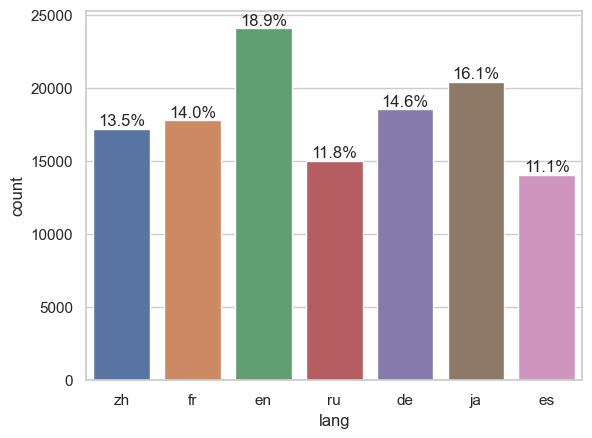

In [17]:
#check distribution of pages by language
showpercent(sns.countplot(x=df['lang']), df.shape[0])

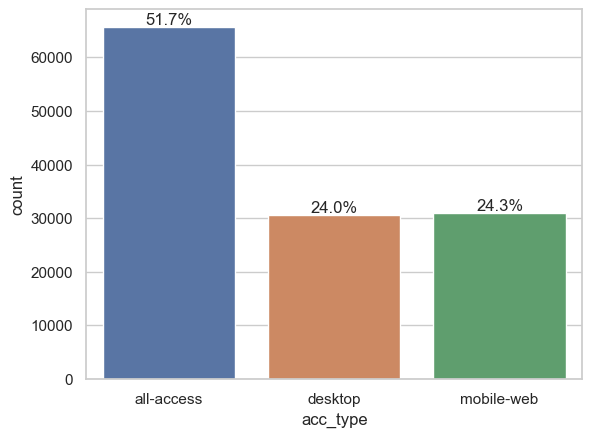

In [18]:
#check distribution of pages by access_type
showpercent(sns.countplot(x=df['acc_type']), df.shape[0])

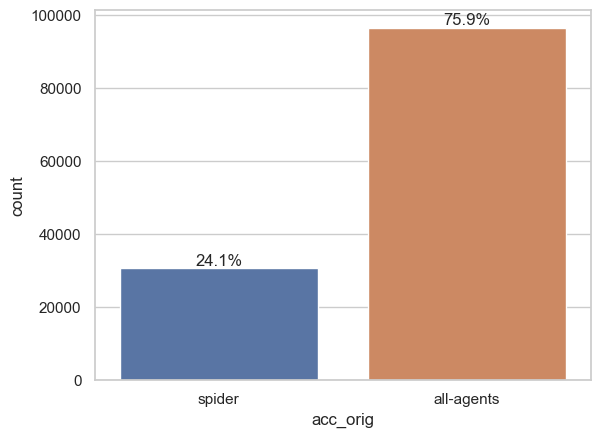

In [19]:
#check distribution of pages by access_origin
showpercent(sns.countplot(x=df['acc_orig']), df.shape[0])

In [20]:
### check URLs where we could not extract features
df[['lang', 'title', 'acc_type', 'acc_orig']].isna().sum()

lang        18
title       18
acc_type    18
acc_orig    18
dtype: int64

In [21]:
df[df['lang'].isna()]

Page  2015-07-01  \
17025  special:mylanguage/wikipedia.org_updated_page_...         NaN   
17026  wikipedia.org_portal_www.mediawiki.org_all-acc...         NaN   
17027  wikipedia.org_add_mobile_app_badges_www.mediaw...         NaN   
17028  wikipedia.org_updated_page_layout_www.mediawik...         NaN   
17029  talk:wikipedia.org_add_mobile_app_badges_www.m...         NaN   
17030  wikipedia.org_portal_www.mediawiki.org_mobile-...         NaN   
17031  wikipedia.org_add_mobile_app_badges_www.mediaw...         NaN   
17032  talk:wikipedia.org_add_mobile_app_badges_www.m...         NaN   
35651  special:mylanguage/wikipedia.org_updated_page_...         NaN   
35652  wikipedia.org_portal_www.mediawiki.org_desktop...         NaN   
35653  wikipedia.org_add_mobile_app_badges_www.mediaw...         NaN   
35654  wikipedia.org_updated_page_layout_www.mediawik...         NaN   
35655  talk:wikipedia.org_add_mobile_app_badges_www.m...         NaN   
66781  special:mylanguage/wikipedia.org_updated_page_...         NaN   
66782  wikipedia.org_portal_www.mediawiki.org_all-acc...         NaN   
66783  wikipedia.org_add_mobile_app_badges_www.mediaw...         NaN   
66784  wikipedia.org_updated_page_layout_www.mediawik...         NaN   
66785  talk:wikipedia.org_add_mobile_app_badges_www.m...         NaN   

       2015-07-02  2015-07-03  2015-07-04  2015-07-05  2015-07-06  2015-07-07  \
17025         NaN         NaN         NaN         NaN         NaN         NaN   
17026         NaN         NaN         NaN         NaN         NaN         NaN   
17027         NaN         NaN         NaN         NaN         NaN         NaN   
17028         NaN         NaN         NaN         NaN         NaN         NaN   
17029         NaN         NaN         NaN         NaN         NaN         NaN   
17030         NaN         NaN         NaN         NaN         NaN         NaN   
17031         NaN         NaN         NaN         NaN         NaN         NaN   
17032         NaN         NaN         NaN         NaN         NaN         NaN   
35651         NaN         NaN         NaN         NaN         NaN         NaN   
35652         NaN         NaN         NaN         NaN         NaN         NaN   
35653         NaN         NaN         NaN         NaN         NaN         NaN   
35654         NaN         NaN         NaN         NaN         NaN         NaN   
35655         NaN         NaN         NaN         NaN         NaN         NaN   
66781         NaN         NaN         NaN         NaN         NaN         NaN   
66782         NaN         NaN         NaN         NaN         NaN         NaN   
66783         NaN         NaN         NaN         NaN         NaN         NaN   
66784         NaN         NaN         NaN         NaN         NaN         NaN   
66785         NaN         NaN         NaN         NaN         NaN         NaN   

       2015-07-08  2015-07-09  ...  2016-12-26  2016-12-27  2016-12-28  \
17025         NaN         NaN  ...         2.0         1.0         3.0   
17026         NaN         NaN  ...         3.0         4.0         8.0   
17027         NaN         NaN  ...         1.0         1.0         4.0   
17028         NaN         NaN  ...         1.0         1.0         NaN   
17029         NaN         NaN  ...         3.0         1.0         NaN   
17030         NaN         NaN  ...         0.0         2.0         1.0   
17031         NaN         NaN  ...         0.0         1.0         3.0   
17032         NaN         NaN  ...         1.0         0.0         NaN   
35651         NaN         NaN  ...         2.0         1.0         3.0   
35652         NaN         NaN  ...         3.0         2.0         7.0   
35653         NaN         NaN  ...         1.0         0.0         1.0   
35654         NaN         NaN  ...         0.0         1.0         NaN   
35655         NaN         NaN  ...         2.0         1.0         NaN   
66781         NaN         NaN  ...         1.0         1.0         0.0   
66782         NaN         NaN  ..

**Observation:** This are again mediawiki.org or wikimedia.org URLs. We can remove them from further analysis.

In [22]:
df = df[~df['lang'].isna()]
df.reset_index(drop=True, inplace=True)

In [23]:
df[['lang', 'title', 'acc_type', 'acc_orig']].isna().sum()

lang        0
title       0
acc_type    0
acc_orig    0
dtype: int64

In [24]:
non_date_cols = ['Page', 'lang', 'title', 'acc_type', 'acc_orig']
date_cols = df.columns.drop(non_date_cols)

## Analyze time series for a few pages

In [25]:
#helpr function to conver df to time-series suitable format
def wide_to_long(df):
    df = df.melt(id_vars=['Page'], value_vars=date_cols, var_name='date', value_name='visits')
    df['date'] = df['date'].astype('datetime64')
    return df.pivot(index='date', columns='Page', values='visits')

#randomly select a few pages for analysis
df_sample = wide_to_long(df[~df.isna().any(axis=1)].sample(10))
df_sample

Page        amanda_seyfried_de.wikipedia.org_all-access_all-agents  \
date                                                                 
2015-07-01                                             1568.0        
2015-07-02                                             8969.0        
2015-07-03                                             2945.0        
2015-07-04                                             2531.0        
2015-07-05                                             2700.0        
...                                                       ...        
2016-12-27                                             1173.0        
2016-12-28                                             1159.0        
2016-12-29                                             1000.0        
2016-12-30                                              924.0        
2016-12-31                                             1356.0        

Page        angelica_domröse_de.wikipedia.org_all-access_all-agents  \
date                                                                  
2015-07-01                                               66.0         
2015-07-02                                               82.0         
2015-07-03                                               50.0         
2015-07-04                                               59.0         
2015-07-05                                               87.0         
...                                                       ...         
2016-12-27                                              235.0         
2016-12-28                                              235.0         
2016-12-29                                              566.0         
2016-12-30                                              150.0         
2016-12-31                                              175.0         

Page        erdnuss_de.wikipedia.org_all-access_all-agents  \
date                                                         
2015-07-01                                           416.0   
2015-07-02                                           438.0   
2015-07-03                                           426.0   
2015-07-04                                           445.0   
2015-07-05                                           452.0   
...                                                    ...   
2016-12-27                                          1208.0   
2016-12-28                                          2534.0   
2016-12-29                                          1318.0   
2016-12-30                                          1212.0   
2016-12-31                                          1014.0   

Page        flores_en_el_ático_es.wikipedia.org_all-access_all-agents  \
date                                                                    
2015-07-01                                              540.0           
2015-07-02                                              578.0           
2015-07-03                                             1012.0           
2015-07-04                                              626.0           
2015-07-05                                             1286.0           
...                                                       ...           
2016-12-27                                              692.0           
2016-12-28                                              727.0           
2016-12-29                                              535.0           
2016-12-30                                              543.0           
2016-12-31                                              393.0           

Page        guerra_cristera_es.wikipedia.org_all-access_all-agents  \
date                                                                 
2015-07-01                                             1061.0        
2015-07-02                                             1027.0        
2015-07-03                                              766.0        
2015-07-04                                              43

#### check stationarity

In [26]:
def adf_test(data, significance_level=0.05):
    pvalue = sm.tsa.stattools.adfuller(data)[1] 
    return pvalue <= significance_level

stationary_cols = []
non_stationary_cols = []

for col in df_sample.columns:
    if(adf_test(df_sample[col])):
        stationary_cols.append(col)
        print(f'"{col}" is stationary')
    else:
        non_stationary_cols.append(col)
        print(f'"{col}" is non-stationary')

"amanda_seyfried_de.wikipedia.org_all-access_all-agents" is stationary
"angelica_domröse_de.wikipedia.org_all-access_all-agents" is stationary
"erdnuss_de.wikipedia.org_all-access_all-agents" is non-stationary
"flores_en_el_ático_es.wikipedia.org_all-access_all-agents" is stationary
"guerra_cristera_es.wikipedia.org_all-access_all-agents" is stationary
"jean_renoir_fr.wikipedia.org_all-access_spider" is stationary
"marie-claude_pietragalla_fr.wikipedia.org_all-access_all-agents" is stationary
"miss_a_zh.wikipedia.org_mobile-web_all-agents" is stationary
"weites_land_de.wikipedia.org_all-access_spider" is stationary
"сахарный_диабет_ru.wikipedia.org_mobile-web_all-agents" is non-stationary


#### check autocorrelation and partial autocorrelation plots to determine seasonality (if any)

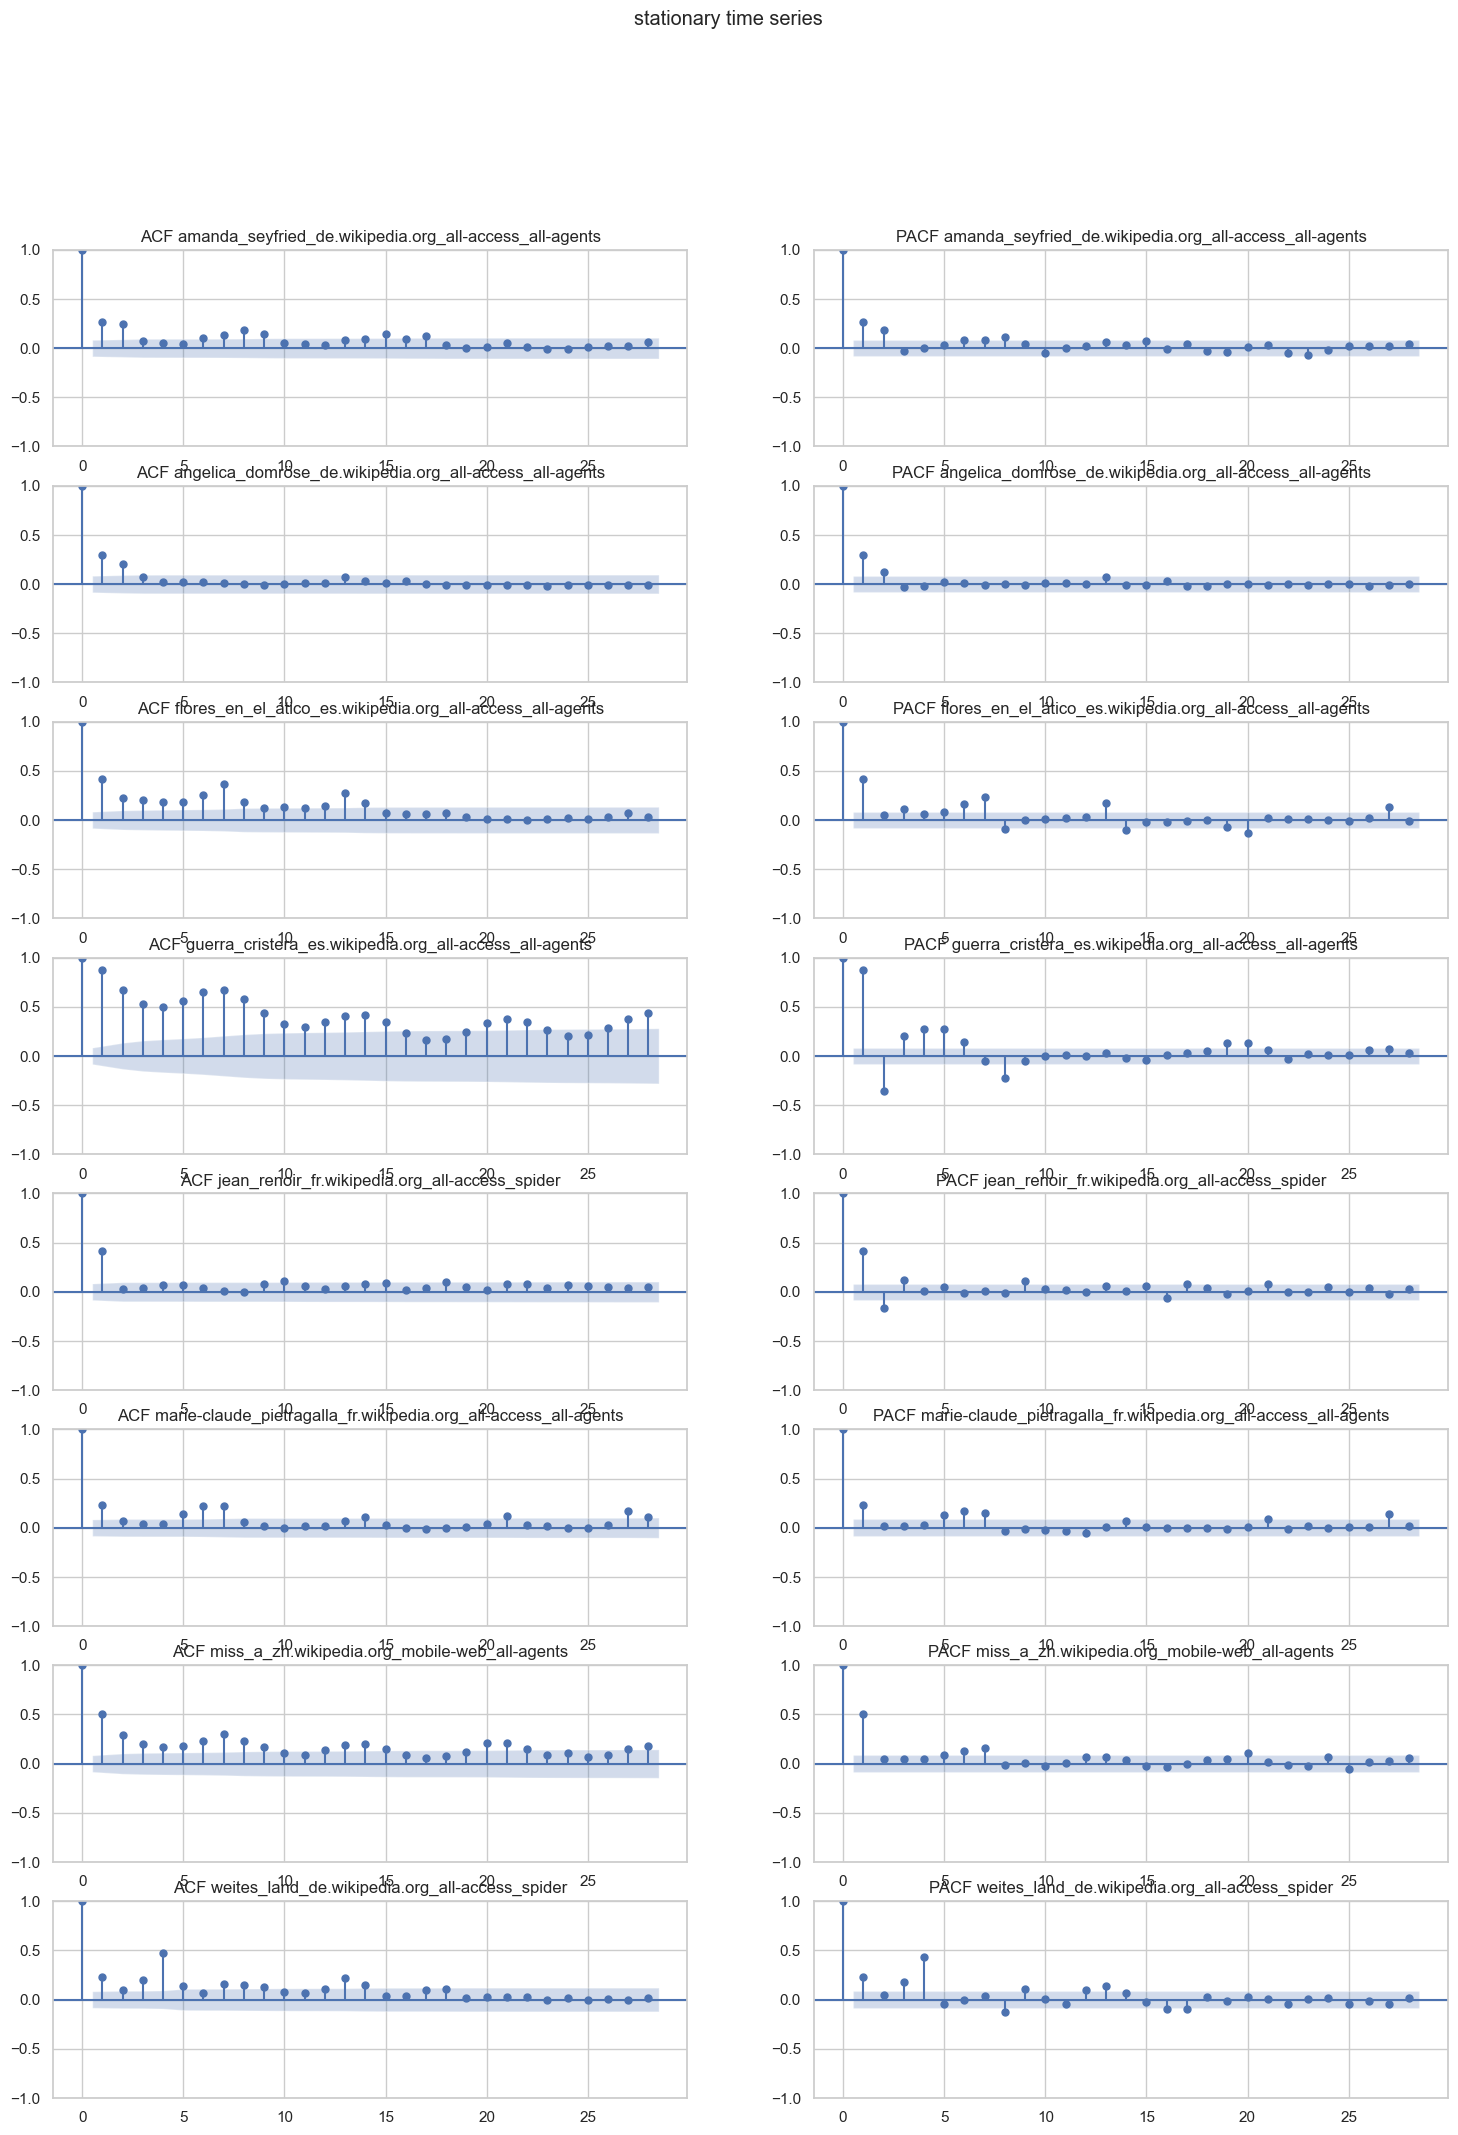

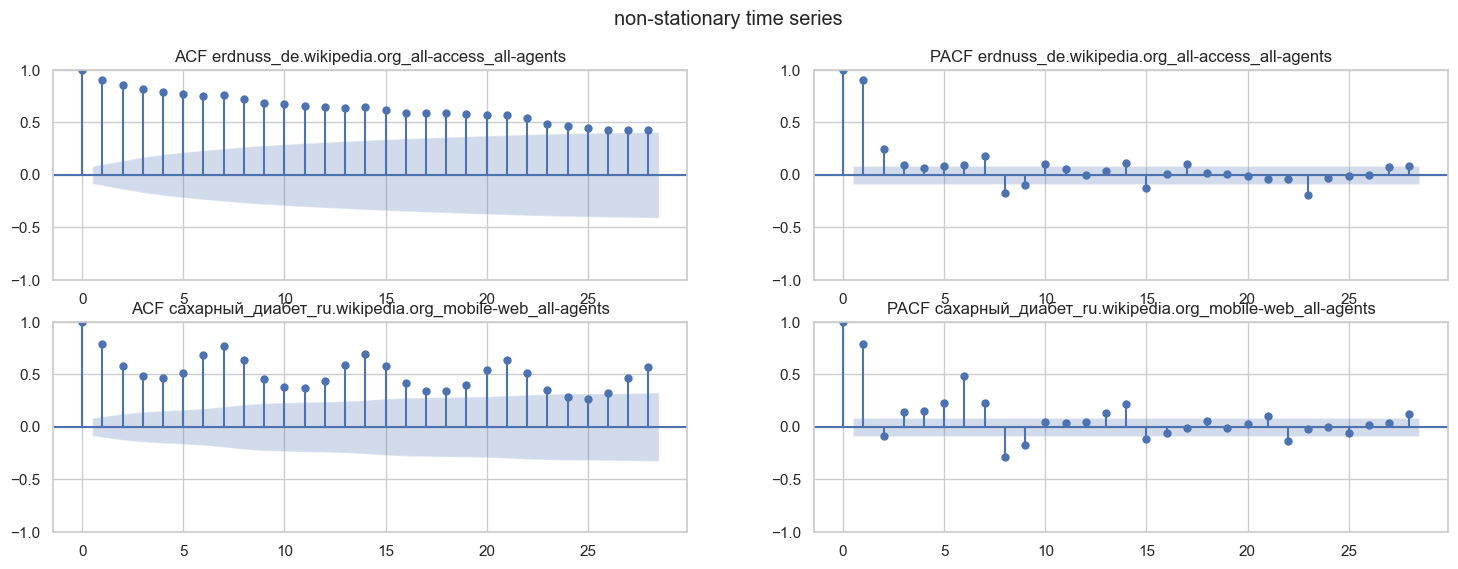

In [27]:
#plot stationary time series
n = len(stationary_cols)
fig, axes = plt.subplots(n,2, figsize=(18,n*3))
fig.suptitle('stationary time series')
for i, col in enumerate(stationary_cols):
    plot_acf(df_sample[col], title=f'ACF {col}', ax=axes[i][0]) 
    plot_pacf(df_sample[col], title=f'PACF {col}', method='ywm',ax=axes[i][1]) 
    
#plot non-stationary time series
n = len(non_stationary_cols)
fig, axes = plt.subplots(np.max([n,2]),2, figsize=(18,n*3))
fig.suptitle('non-stationary time series')
for i, col in enumerate(non_stationary_cols):
    plot_acf(df_sample[col], title=f'ACF {col}', ax=axes[i][0]) 
    plot_pacf(df_sample[col], title=f'PACF {col}', method='ywm',ax=axes[i][1]) 

**Observation:** 

1. Most of the randomly selected pages have stationary time series. 

2. In the non-stationary time series, we see small to moderate spikes in ACF and PACF plots at lag-7 for some pages. So for further decomposition, we can consider weekly seasonality.

Stationary pages time-series decomposition


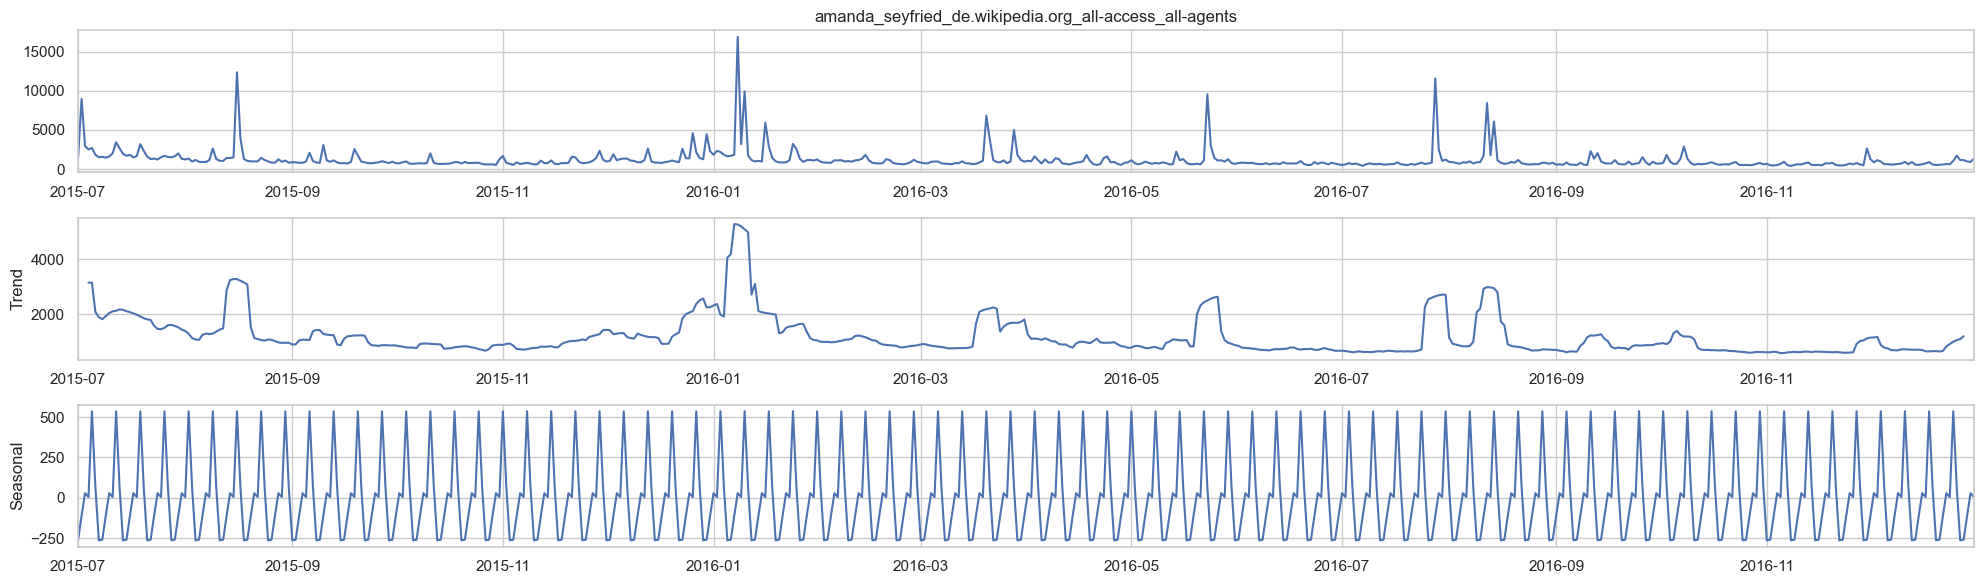

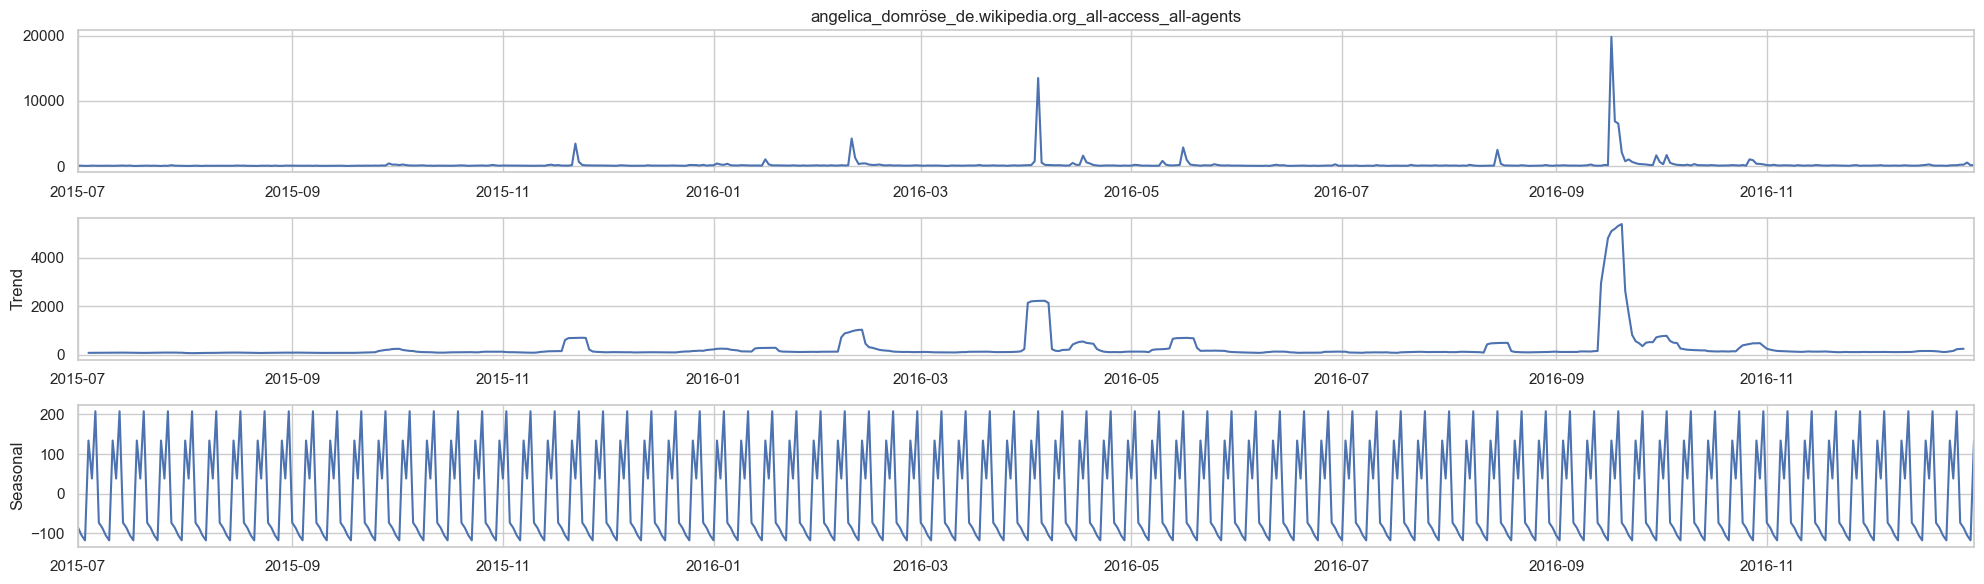

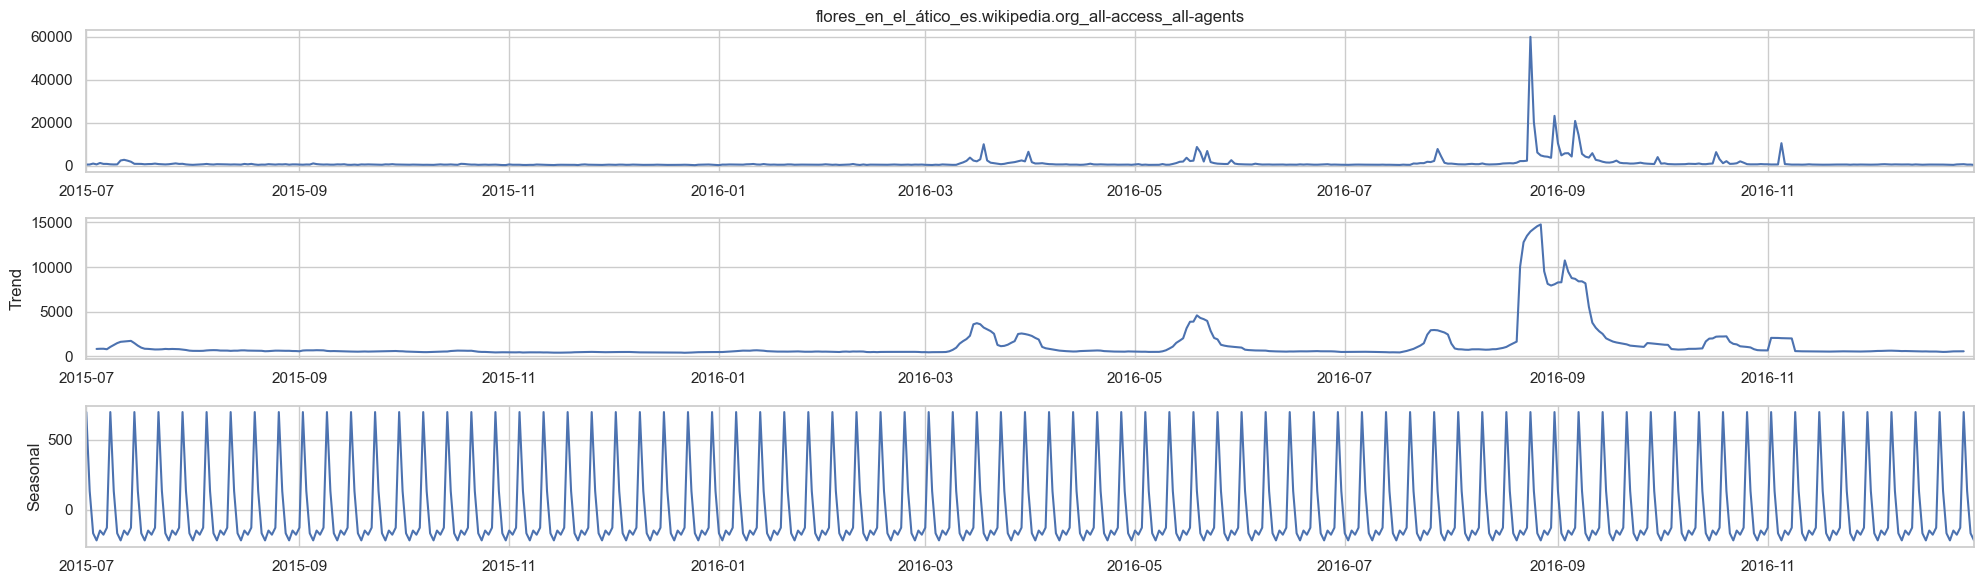

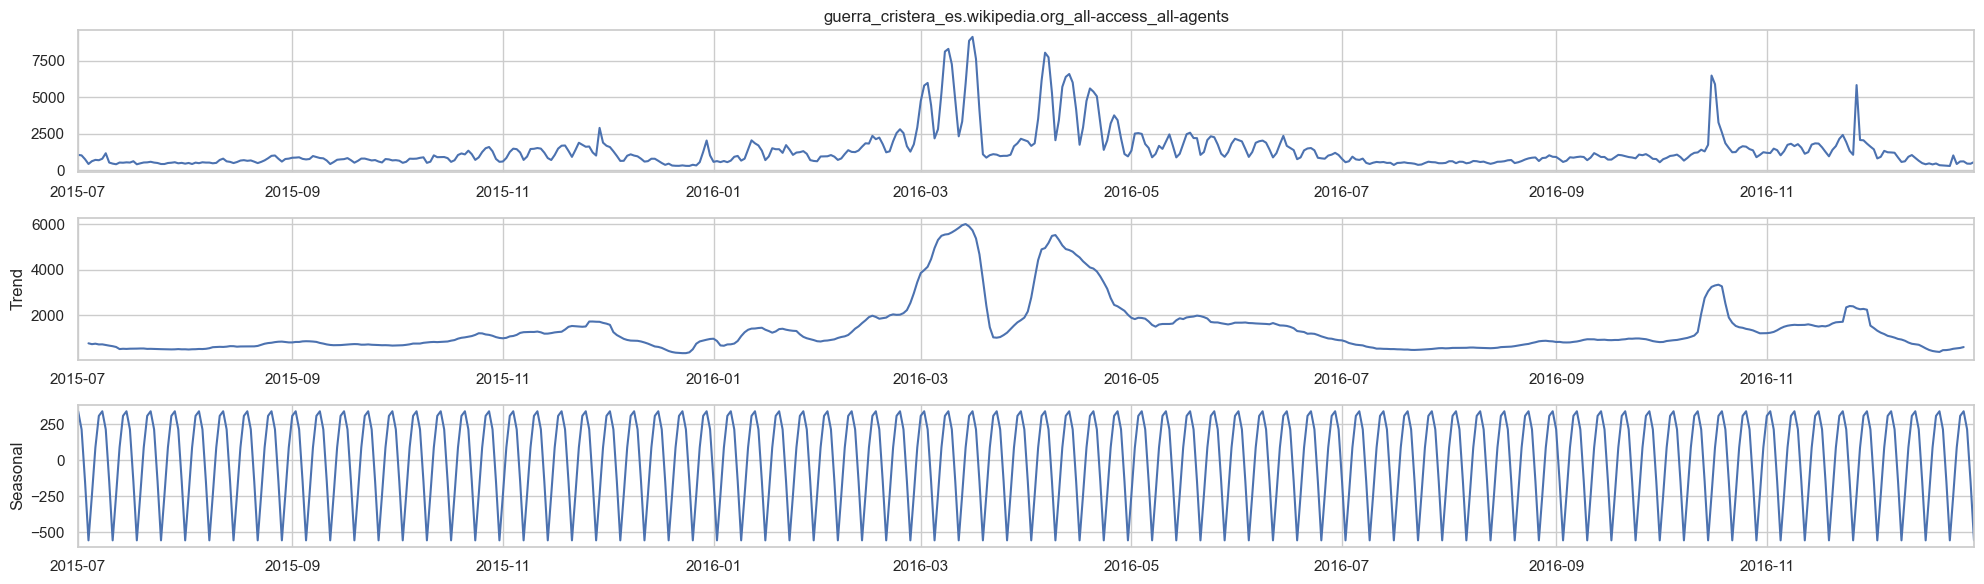

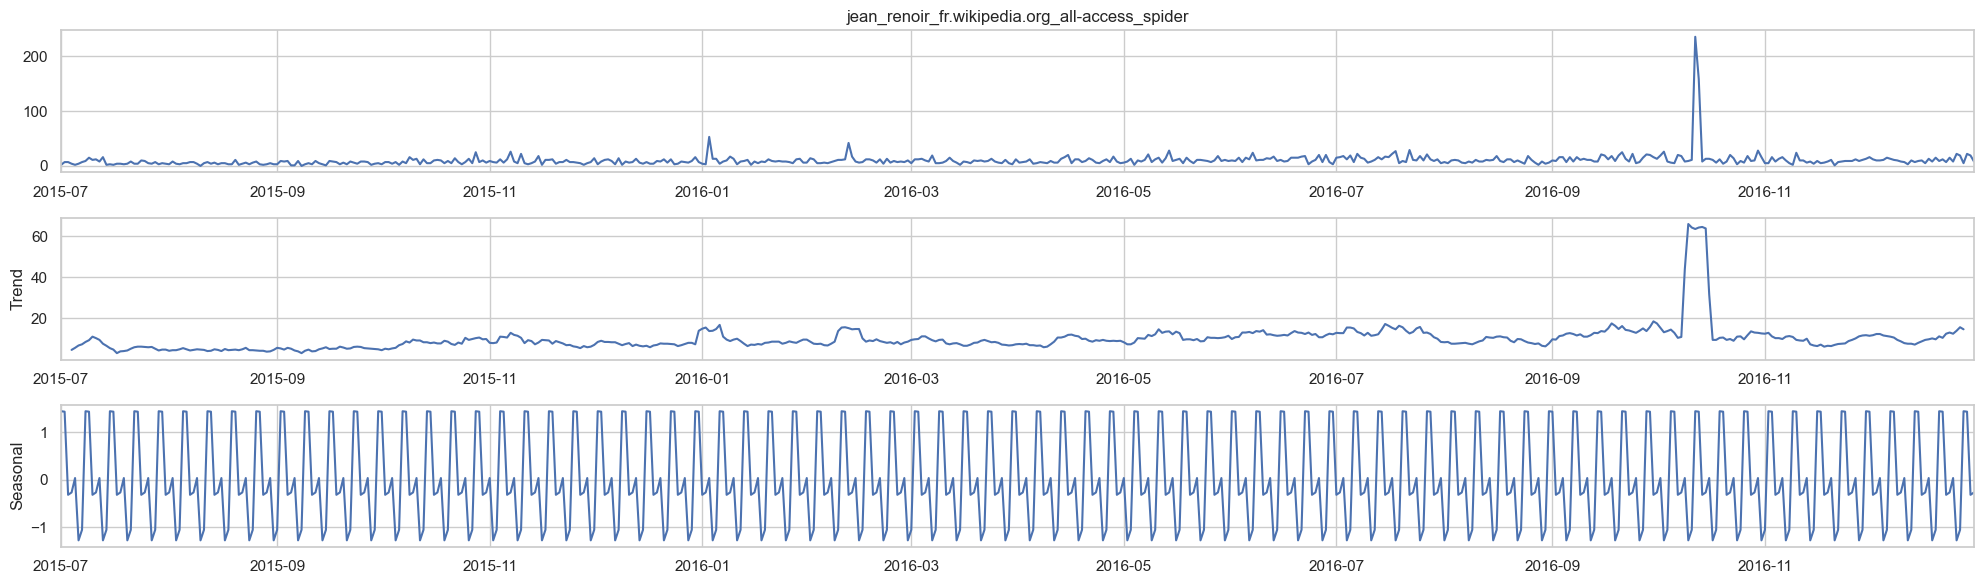

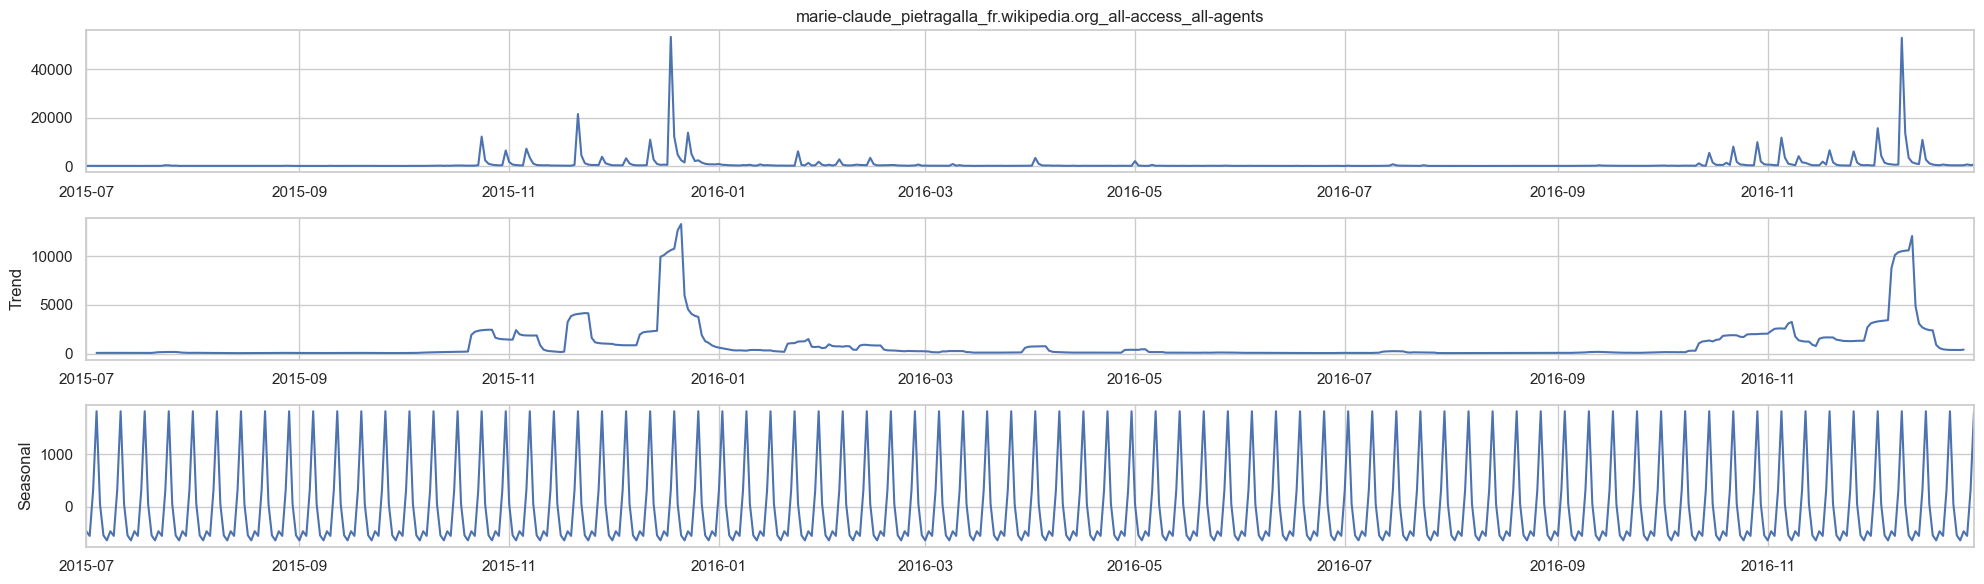

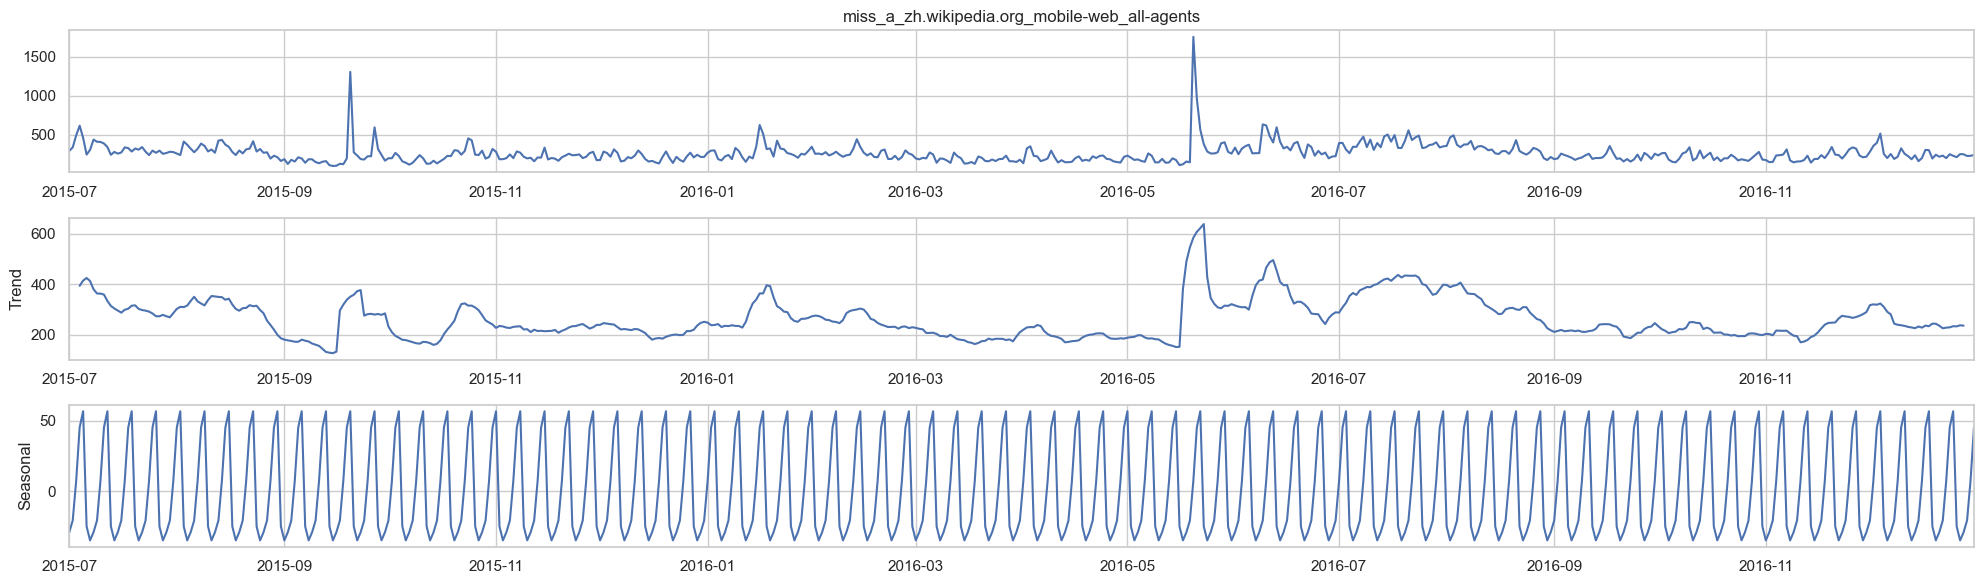

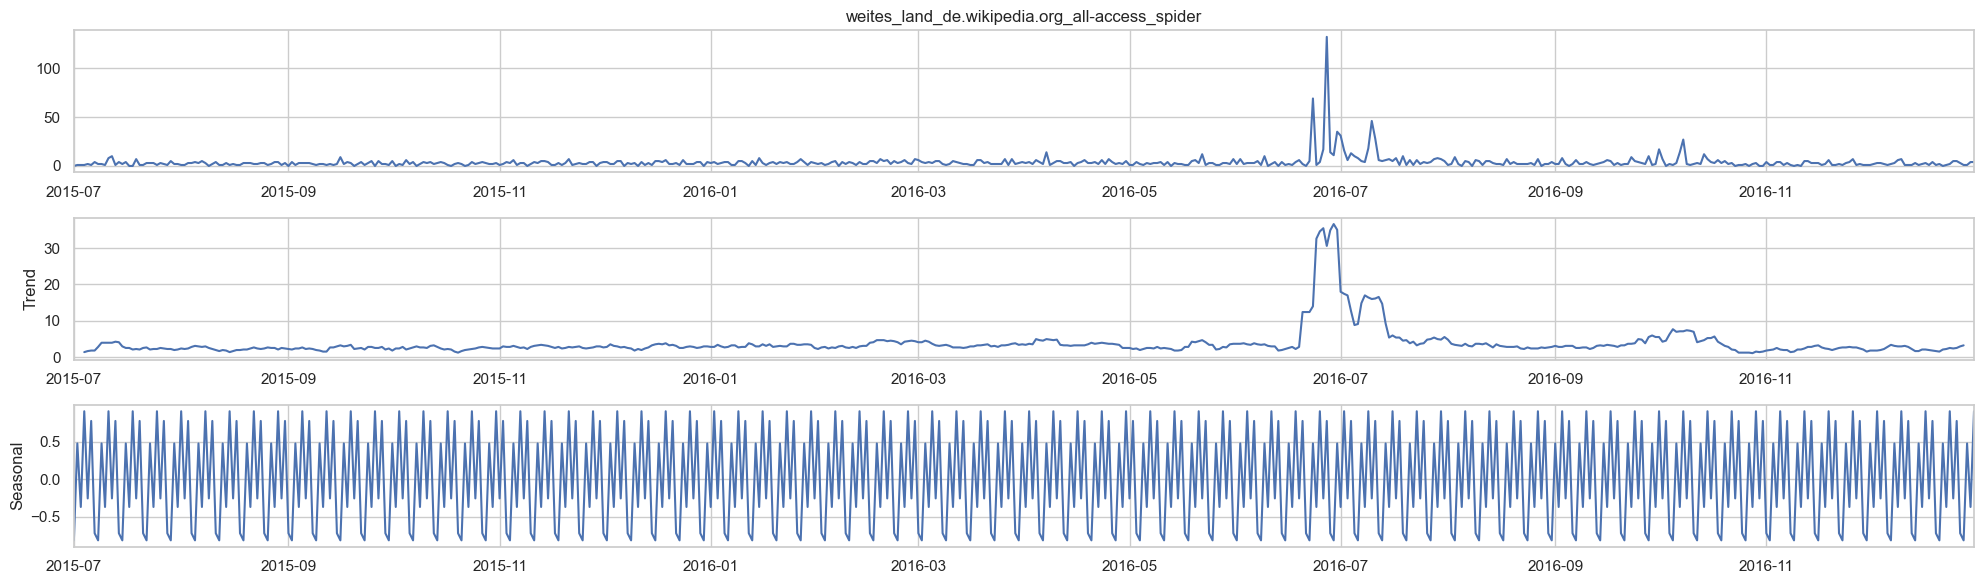

In [28]:
plt.rcParams['figure.figsize'] = (20, 6)

print('Stationary pages time-series decomposition')
#plot stationary time series
n = len(stationary_cols)
for i, col in enumerate(stationary_cols):
    model = sm.tsa.seasonal_decompose(df_sample[col], model='additive', period=7)
    model.plot(resid=False)

Non-Stationary pages time-series decomposition


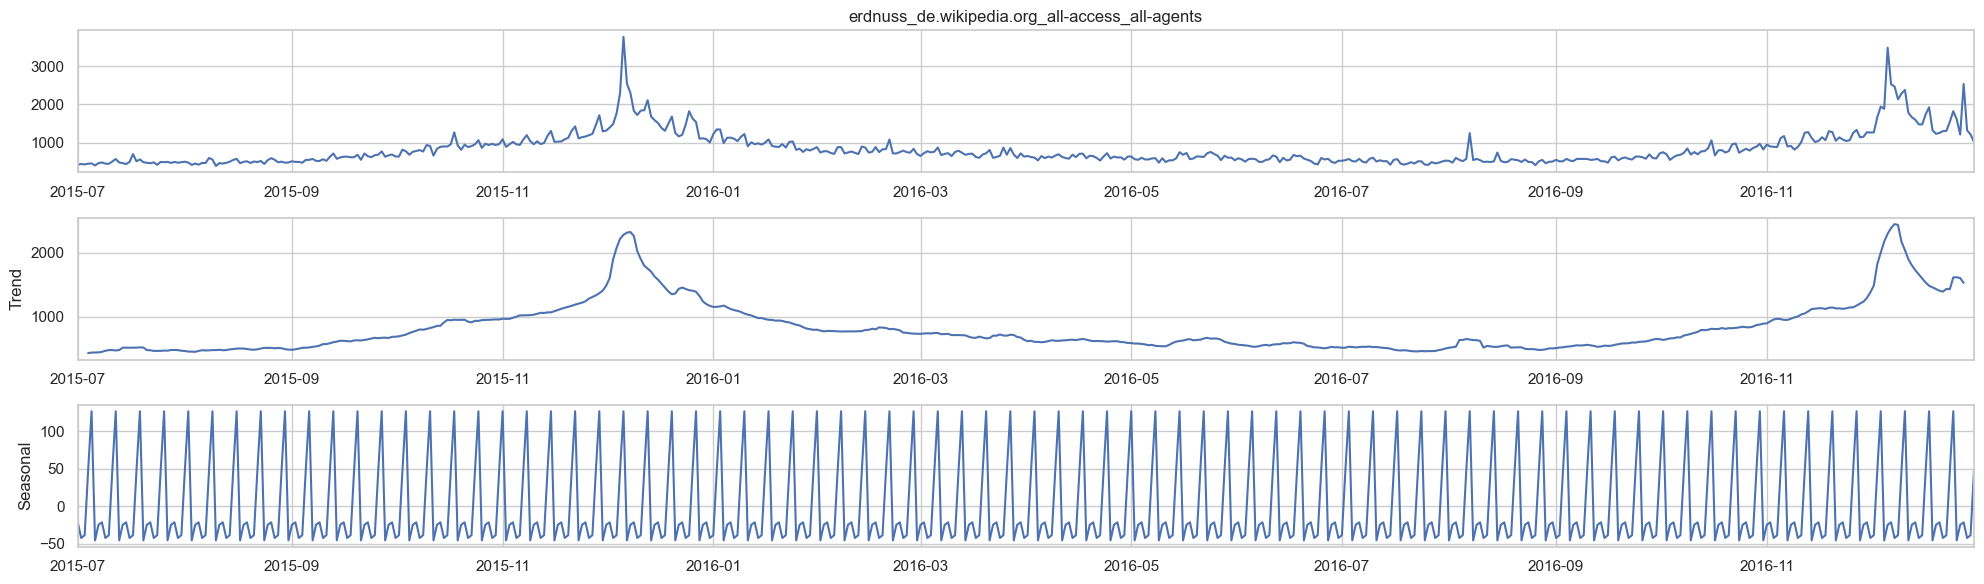

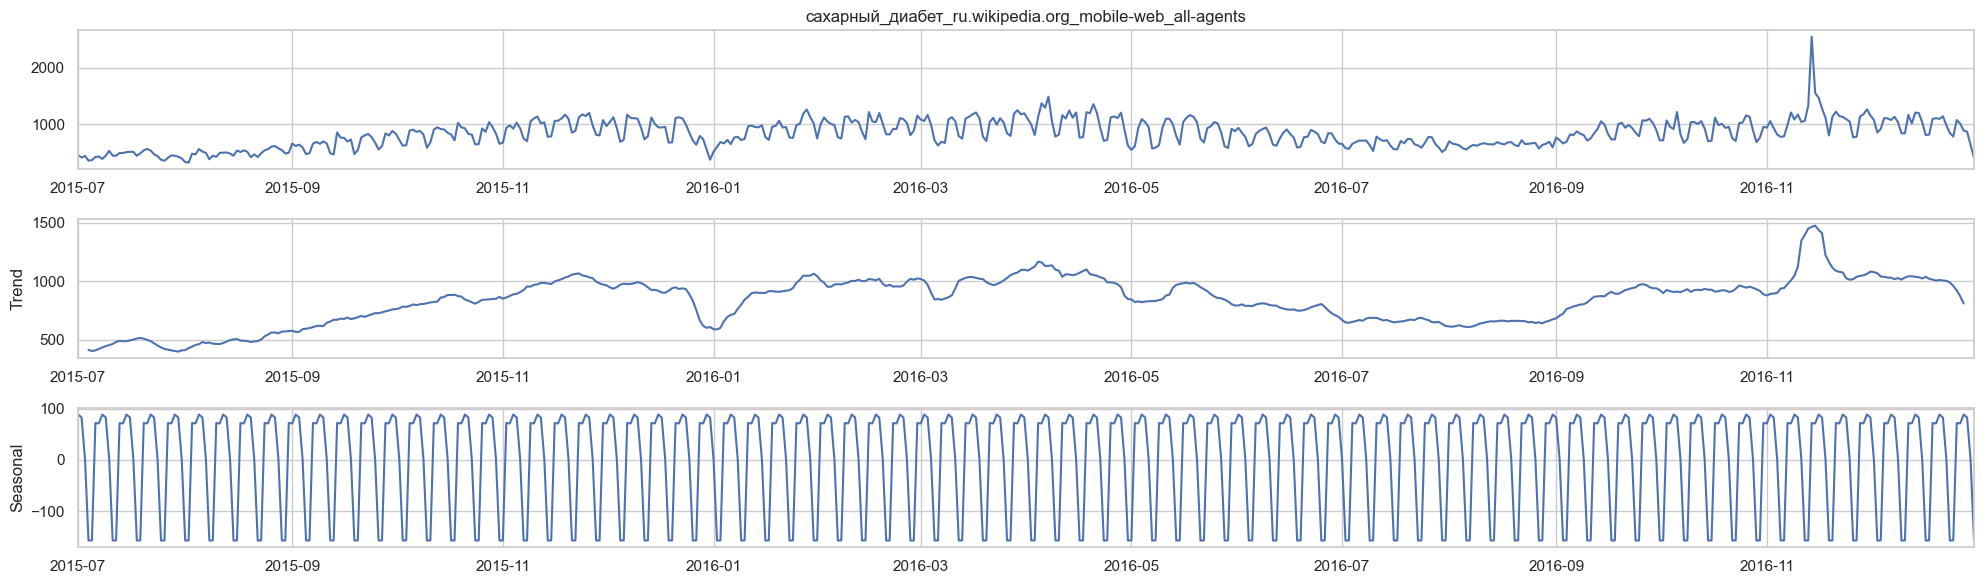

In [29]:
print('Non-Stationary pages time-series decomposition')
#plot non-stationary time series
n = len(non_stationary_cols)
for i, col in enumerate(non_stationary_cols):
    model = sm.tsa.seasonal_decompose(df_sample[col], model='additive')
    model.plot(resid=False)    

**Observations:** For stationary time series, we do not see any trend as expected. For non-stationary time series, there is no clear general pattern observed in trend. However, we do see weekly seasonality effect. 

## Missing value analysis

<AxesSubplot:>

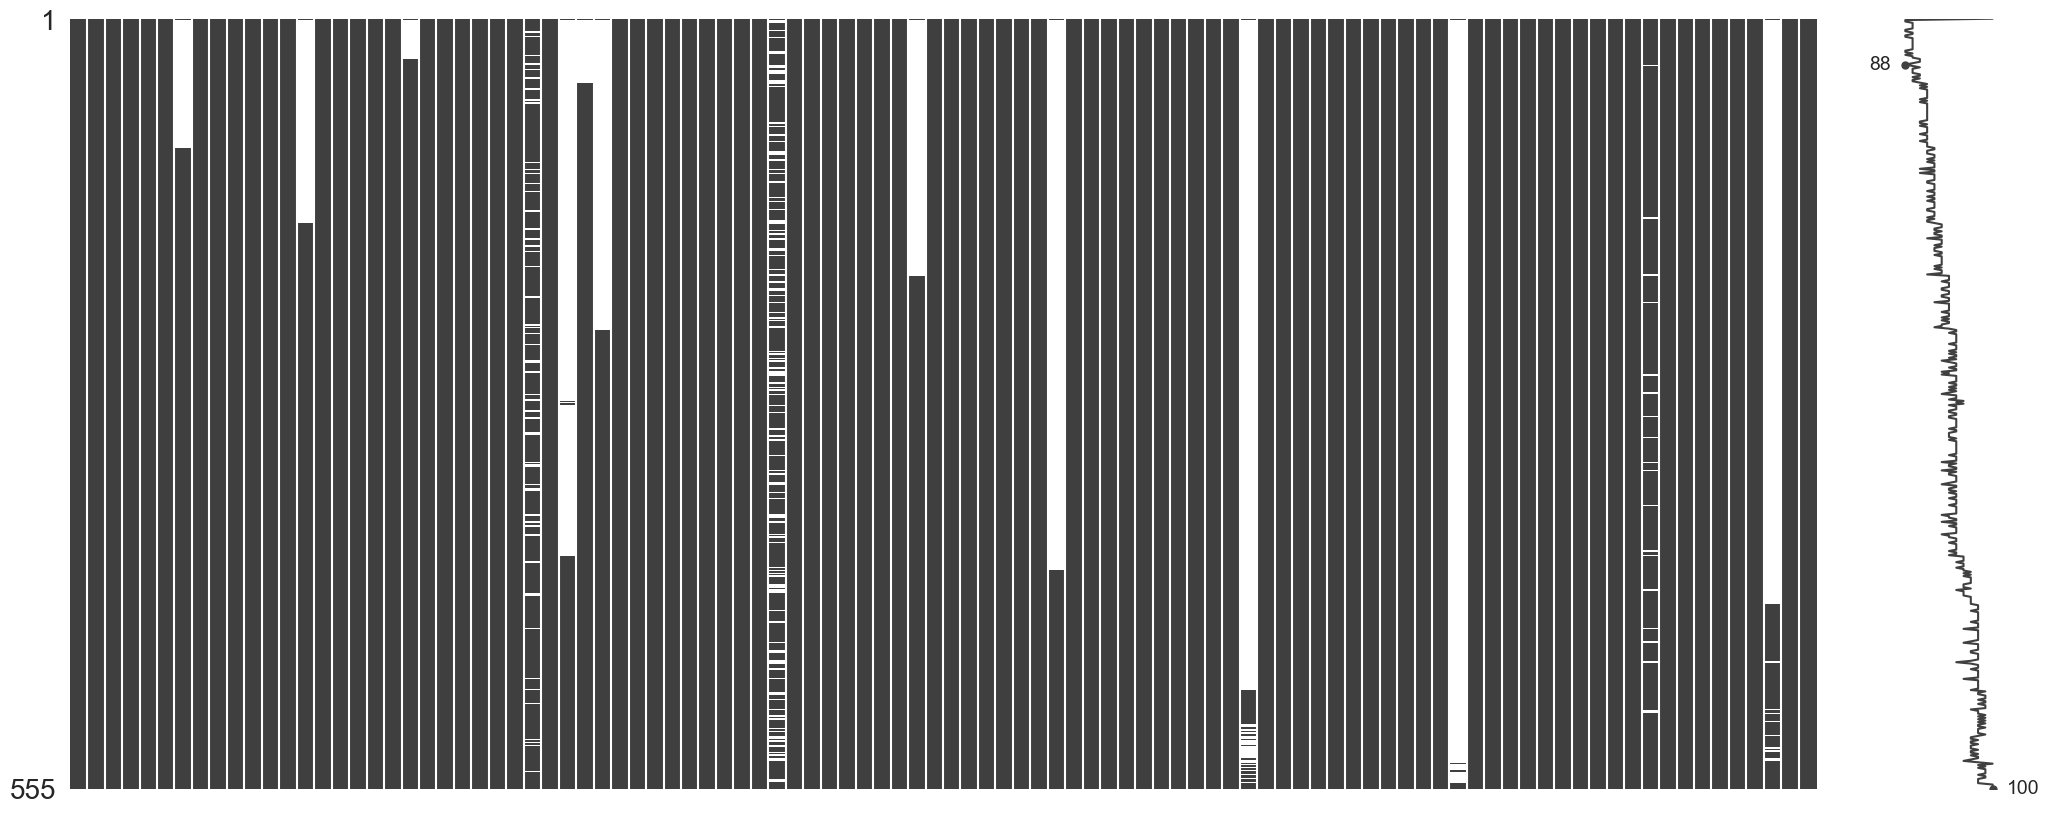

In [30]:
#Visualize missing values for random 100 pages
#!pip install missingno
import missingno as msno
msno.matrix(df.sample(100).T)

**Observation:** The visulization above shows that majority of the missing values seem to be occurring as as chunks in the farthest past (the pages likely didn't exist at that point). As we move towards more recent past, the number of missing values come down. Also, there are some time series' where NANs occur frequently. We can now compute relevant stats to further understand the distribution of missing values.

In [31]:
#print missing value basic stats
total_missing_points = df.isna().sum().sum()
total_points = df[date_cols].shape[0] * df[date_cols].shape[1]
total_pages = df.shape[0]

dfm = df[df.isna().any(axis=1)].copy()

print(f"total time series data points (across pages): {total_points}")
print(f"number of missing points (across pages): {total_missing_points}")
print(f"overall missing points percentage (across pages): {np.round(total_missing_points/total_points * 100, 2)}%")
print("")
print(f"total number of pages: {df.shape[0]}")
print(f"total number of pages with some missing points: {dfm.shape[0]}")
print(f"overall percentage of pages with some missing points: {np.round(dfm.shape[0]/total_pages * 100, 2)}%")

total time series data points (across pages): 69918750
number of missing points (across pages): 4355868
overall missing points percentage (across pages): 6.23%

total number of pages: 127125
total number of pages with some missing points: 19016
overall percentage of pages with some missing points: 14.96%


In [32]:
#helper function to compute missing_value stats for a given page
def missing_val_stats(ts):
    
    n = ts.shape[0]    
    visits = ts.isna().values
    
    total_nan = visits.sum()
    leading_nan, trailing_nan = 0,0
    
    #compute leading NANs 
    i = 0
    while i<n and visits[i]: i += 1
    leading_nan = i
        
    #compute trailing NANs
    i = n-1
    while i>=0 and visits[i]: i -= 1
    trailing_nan = (n-1 - i)
        
    #compute between_nan, avg_nan_prop
    between_nan, avg_nan_prop = 0, 0
    if total_nan < n: #atleast some valid values
        between_nan = total_nan - (leading_nan + trailing_nan)
        avg_nan_prop = np.round(between_nan / (n - (leading_nan + trailing_nan)), 2)
        
    return total_nan, leading_nan, trailing_nan, between_nan, avg_nan_prop

#helper function to get missing_value stats from the given dataframe
def get_missing_val_stats(df):
    
    dfm = df[df.isna().any(axis=1)].reset_index().rename(columns={'index': 'page_index'}).copy()
    dfm2 = dfm.set_index(['Page', 'page_index'])
    col_list = filter(lambda x: bool(re.match(r'\d{4}-\d{2}-\d{2}', x)) , dfm2.columns)
    dfm2 = dfm2[col_list]
    dfm2.columns = range(1, dfm2.columns.shape[0]+1)
    
    missing_stats = dfm2.apply(missing_val_stats, axis=1)
    ret = pd.DataFrame(data = missing_stats.tolist(), columns=['total_nan', 'leading_nan', 'trailing_nan', 'between_nan', 'avg_nan_prop'], index=dfm2.index).reset_index()
    return ret.set_index('page_index')
    
#helper function to plot missing_value_stats
def plot_missing_val_stats(missing_stats):
    fig, axes = plt.subplots(2,3, figsize=(15,8))

    sns.histplot(missing_stats['total_nan'], ax=axes[0][0])
    sns.histplot(missing_stats['leading_nan'],  ax=axes[0][1])
    sns.histplot(missing_stats['trailing_nan'],  ax=axes[0][2], bins=50)
    
    sns.histplot(missing_stats['between_nan'],  ax=axes[1][0], bins=50)
    sns.histplot(missing_stats['avg_nan_prop'],  ax=axes[1][1], bins=50)
    
    plt.show()

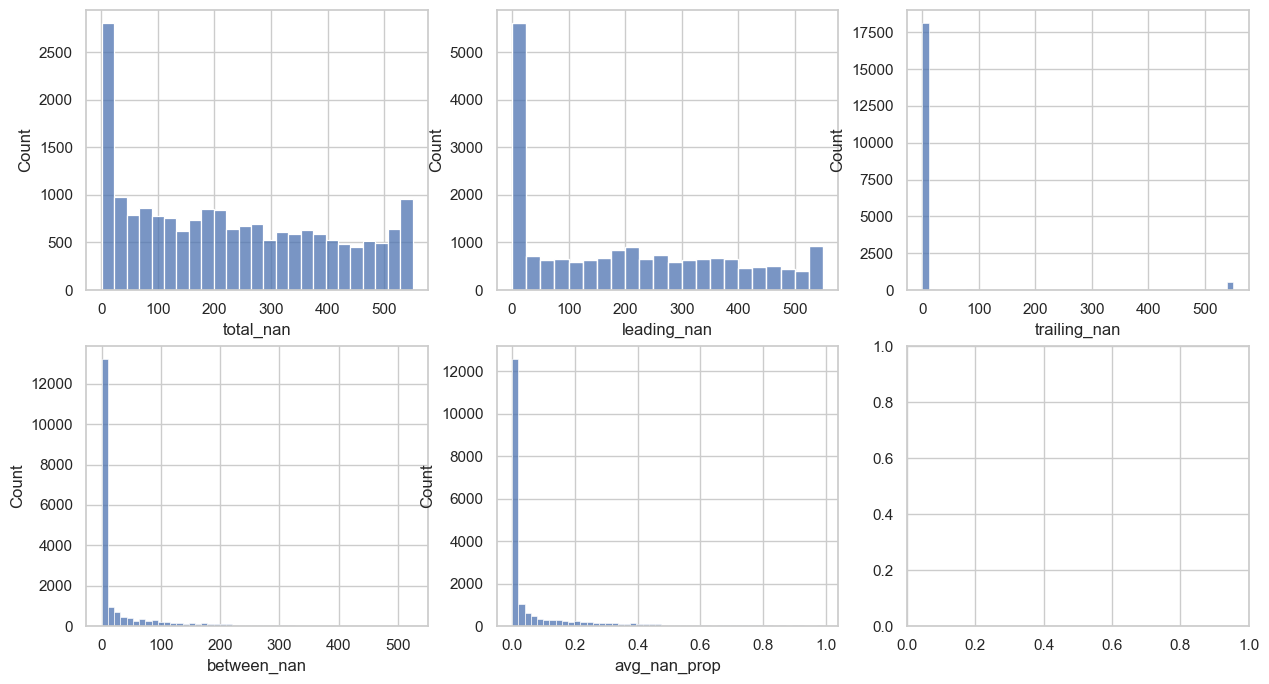

In [33]:
#check distributions of total_nan, leading_nan, and trailing_nan for pages
missing_stats = get_missing_val_stats(df)
plot_missing_val_stats(missing_stats)

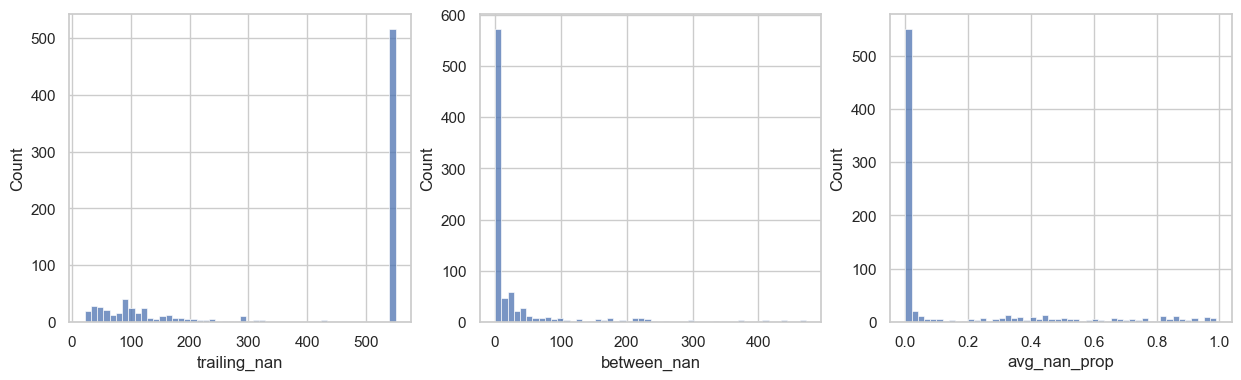

In [34]:
#further check distribution of pages where trailing_nan > 0
df_tmp = missing_stats[missing_stats['trailing_nan'] > 21]
fig, axes = plt.subplots(1,3, figsize=(15,4))
sns.histplot(df_tmp['trailing_nan'], ax=axes[0], bins=50)
sns.histplot(df_tmp['between_nan'], ax=axes[1], bins=50)
sns.histplot(df_tmp['avg_nan_prop'], ax=axes[2], bins=50)
plt.show()

**Observations:**

1. There are total 19103 pages having one or more missing values. We can further segregate missing values (or NANs) into the following categories. 
    
    1. **Leading NANs** - which occur as the consecutive sequence of NANs farthest back in time. A large enough leading NAN value signifies that the page didn't exist in that time frame.     
    
    2. **Trailing NANs** - which occur as the consecutive sequence of NANs in the most recent past. A large enough trailing NAN value signifies that the page may have been removed/discontinued/renamed at some point in the past.     
    
    3. **Between NANs** - These are genuine NAN values occurring when the page was in existence.

2. Around 530 pages have trailing_nan value > 500. Similarly there are 839 pages with trailing_nan value > 30. 

In [35]:
missing_stats['total_nan'].describe()

count    19016.000000
mean       229.063315
std        172.480548
min          1.000000
25%         71.000000
50%        207.500000
75%        372.000000
max        550.000000
Name: total_nan, dtype: float64

### Removing discontinued pages

All pages with missing values for last 30 days or more (that is trailing_nan >= 30) can be considered discontinued and safely removed from our analysis. For all pages which have values missing for last 7 days to 30 days, we can compute probability of it being discontinued as shown below. 

    P_discontinued = 1 - (P_nan ^ trailing_nan)
    
    where P_nan = probability of a specific time-series value being NAN (~avg_nan_prop)
    
All pages where P_discontinued > 0.95 can also be safely removed.        

In [36]:
#find pages with missing values since last 30 or more days
rem_indices = []
mask_30 = missing_stats['trailing_nan'] >= 30
print(f'number of pages with values missing for >= 30 days: {mask_30.sum()}')
rem_indices = missing_stats[mask_30].index.values.tolist()

number of pages with values missing for >= 30 days: 837


In [37]:
#for pages with values missing since last 7 to 30 days, compute probablity of it being discontinued based on average missing value proportion.
mask_7_30 = (missing_stats['trailing_nan'] >= 7) & (missing_stats['trailing_nan'] < 30)
p_nan = missing_stats[mask_7_30]['avg_nan_prop']
tr_nan = missing_stats[mask_7_30]['trailing_nan']

p_discontinued = 1 - np.power(p_nan, tr_nan)
index_tobe_rem = p_discontinued[p_discontinued > 0.95].index.values.tolist()
rem_indices = list(set(rem_indices + index_tobe_rem))

print('stats for pages with values missing for last 7 to 30 days')
print(f'total pages: {mask_7_30.sum()}')
print(f'pages with prob of discontinued > 0.95: {len(index_tobe_rem)}')

stats for pages with values missing for last 7 to 30 days
total pages: 100
pages with prob of discontinued > 0.95: 79


In [38]:
print(f'total pages to be removed: {len(rem_indices)}')

total pages to be removed: 916


In [39]:
#remove discontinued pages
df.drop(labels=rem_indices, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [40]:
df.shape

(126209, 555)

In [41]:
#recompute missing_stats
missing_stats = get_missing_val_stats(df)

In [42]:
missing_stats[['total_nan', 'avg_nan_prop']].describe()

total_nan  avg_nan_prop
count  18100.000000  18100.000000
mean     215.344696      0.072580
std      163.306593      0.158279
min        1.000000      0.000000
25%       66.000000      0.000000
50%      197.000000      0.000000
75%      350.000000      0.050000
max      549.000000      0.990000

### Remove sparse pages with very high total NANs or very high NAN rate 

We can remove the pages which satisfy the following conditions. 

    if page['avg_nan_prop']  > 0.5 then 
        rem_list.append(page)
    else if page['total_nan'] > 350 and page['avg_nan_prop'] > 0.3 then
        rem_list.append(page)
    
    remove all pages in rem_list


In [43]:
#find sparse pages 

mask_sparse_pages = (missing_stats['avg_nan_prop'] > 0.5) | ((missing_stats['total_nan'] > 350) & (missing_stats['avg_nan_prop'] > 0.3))
rem_indices = missing_stats[mask_sparse_pages].index.values.tolist()
print(f'number of sparse pages: {len(rem_indices)}')

number of sparse pages: 872


In [44]:
#remove sparse page and reset the index
df.drop(labels=rem_indices, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [45]:
diff = total_pages - df.shape[0]
print(f'discontinued and/or sparse pages removed: count - {diff}, percent - {np.round(diff/total_pages * 100, 2)}%')

discontinued and/or sparse pages removed: count - 1788, percent - 1.41%


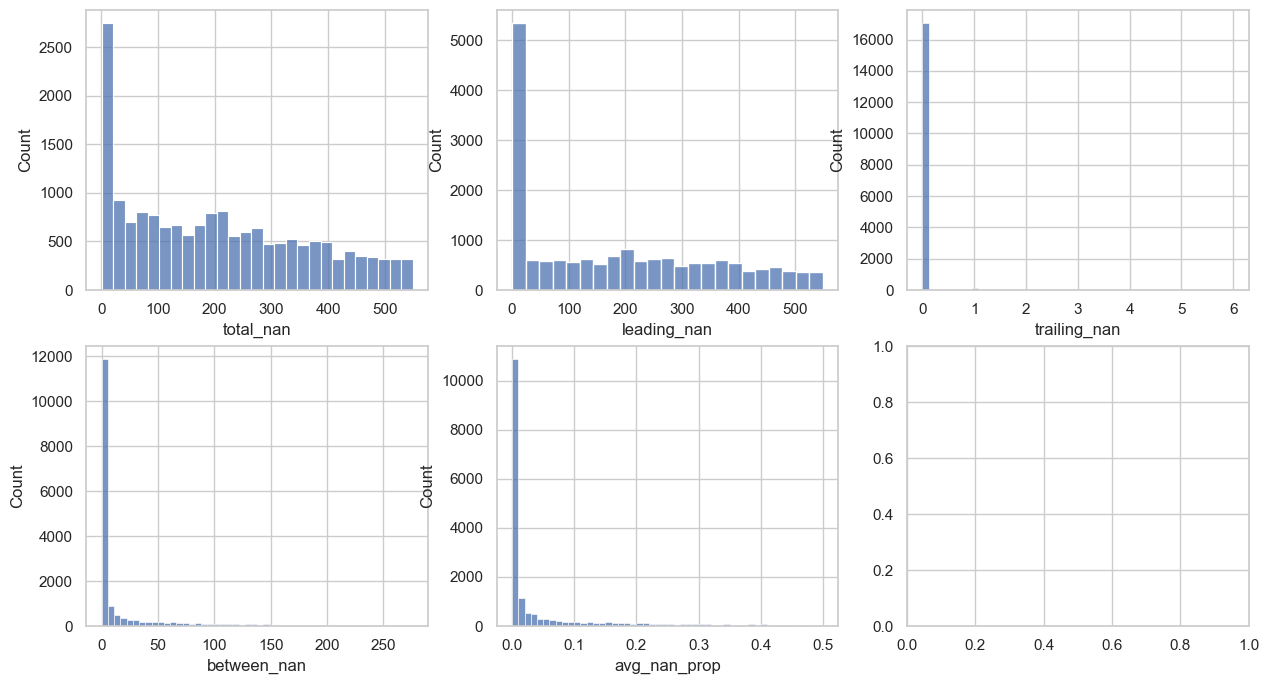

In [46]:
#check distributions of total_nan, leading_nan, and trailing_nan again
missing_stats = get_missing_val_stats(df)
plot_missing_val_stats(missing_stats)

## Missing value imputation

Now that we have removed discontinued and sparse page, in this section, we can impute missing values. 

In [47]:
df_backup = df.copy()

In [48]:
pq.write_table(pa.Table.from_pandas(df_backup), 'before_imputation.parquet')
#pq.read_pandas('before_imputation.parquet').to_pandas()

In [49]:
#prepare df_impute time series
stats_cols = ['total_nan', 'leading_nan', 'trailing_nan', 'between_nan', 'avg_nan_prop']
df_impute = pd.merge(df, missing_stats[stats_cols], left_index=True, right_index=True, how='left')
df_impute[stats_cols] = df_impute[stats_cols].fillna(0)

non_date_cols = df_impute.columns.drop(date_cols).values
df_impute = df_impute[np.concatenate((date_cols, non_date_cols))]

In [50]:
ma_imputation_cnt, tes_imputation_cnt = 0,0
round_scale=2

def get_weekly_avg(ser):
    ret = {}
    if(len(ser) >= 7):
        for day in range(0,7):
            ret[day] = np.round(np.mean(ser[day::7]),round_scale)
    else:
        mean_val = np.round(np.mean(ser),round_scale)
        for day in range(0,7):
            ret[day] = mean_val
    return ret

def fill_missing_val(df):
    global date_cols
    global adf_test
    global get_weekly_avg
    global ma_imputation_cnt 
    global tes_imputation_cnt
    n = len(date_cols)
    
    if(df['total_nan'] > 0):
        leading_nan = int(df['leading_nan'])
        trailing_nan = int(df['trailing_nan'])
        between_nan = int(df['between_nan'])
        between_len = n - leading_nan - trailing_nan
        
        #impute between nans with simple interpolation
        if(between_nan > 0):
            df[leading_nan: n - trailing_nan] = np.round(df.iloc[leading_nan: n - trailing_nan].astype('float').interpolate(method='linear', limit=n),round_scale)
        
        #create timeseries copy
        ts = pd.Series(df[date_cols].values, index=df[date_cols].index.astype('datetime64[ns]'), dtype='float')
        
        #impute trailing nans 
        trailing_imputed = False
        if(trailing_nan > 0):
            if(between_len >= 60):
                is_stationary = adf_test(ts[leading_nan : n-trailing_nan])
                if(not is_stationary):
                    m = sm.tsa.ExponentialSmoothing(ts[leading_nan : n-trailing_nan], trend='add', damped_trend=True, seasonal='add', seasonal_periods=7, freq='D').fit()            
                    f = np.round(m.predict(n - trailing_nan, n-1),round_scale)
                    df.iloc[n-trailing_nan: n] = np.where(f > 0, f, 0)
                    tes_imputation_cnt += 1
                    trailing_imputed = True

            if(not trailing_imputed): 
                
                if(between_len >= 7): #basic weekly seasonal imputation
                    df.iloc[n-trailing_nan: n] = list(map(lambda x: ts[x-7], range(n-trailing_nan, n)))
                else: #basic global mean
                    mean_val = ts[leading_nan: n-trailing_nan].mean()
                    df.iloc[n-trailing_nan: n] = [mean_val for _ in range(n-trailing_nan, n)]
                ma_imputation_cnt += 1
                
        #impute leading nans with weekly seasonal average
        if(leading_nan > 0):
            weekly_avg = get_weekly_avg(ts[leading_nan: n - trailing_nan])
            df.iloc[0:leading_nan] = list(map(lambda x: weekly_avg[x%7], range(0, leading_nan)))

    return df

df3 = df_impute.copy()
df3.loc[df_impute['total_nan'] > 0, df_impute.columns] = df_impute[df_impute['total_nan'] > 0].apply(fill_missing_val ,axis=1)
df3

C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


2015-07-01  2015-07-02  2015-07-03  2015-07-04  2015-07-05  \
0            18.00        11.0        5.00       13.00       14.00   
1            11.00        14.0       15.00       18.00       11.00   
2             1.00         0.0        1.00        1.00        0.00   
3            35.00        13.0       10.00       94.00        4.00   
4             8.51        15.0        6.95       12.76        6.35   
...            ...         ...         ...         ...         ...   
125332       21.00        22.0       13.00       13.00       13.00   
125333     1309.00      1529.0     1568.00     1333.00     1494.00   
125334        0.00         0.0        0.00        0.00        0.00   
125335        0.00         0.0        0.00        0.00        0.00   
125336        0.00         0.0        0.00        0.00        0.00   

        2015-07-06  2015-07-07  2015-07-08  2015-07-09  2015-07-10  ...  \
0             9.00        9.00       22.00        26.0       24.00  ...   
1            13.00       22.00       11.00        10.0        4.00  ...   
2             4.00        0.00        3.00         4.0        4.00  ...   
3            26.00       14.00        9.00        11.0       16.00  ...   
4             8.81       13.57        8.51        15.0        6.95  ...   
...            ...         ...         ...         ...         ...  ...   
125332       18.00       15.00       14.00        32.0       32.00  ...   
125333     1721.00     1568.00     1682.00      1661.0     1522.00  ...   
125334        0.00        0.00        0.00         0.0        0.00  ...   
125335        0.00        0.00        0.00         0.0        0.00  ...   
125336        0.00        0.00        0.00         0.0        0.00  ...   

                                                     Page  \
0                 2ne1_zh.wikipedia.org_all-access_spider   
1                  2pm_zh.wikipedia.org_all-access_spider   
2                   3c_zh.wikipedia.org_all-access_spider   
3              4minute_zh.wikipedia.org_all-access_spider   
4       52_hz_i_love_you_zh.wikipedia.org_all-access_s...   
...                                                   ...   
125332  звёздные_войны:_пробуждение_силы_ru.wikipedia....   
125333  звёздные_войны:_пробуждение_силы_ru.wikipedia....   
125334  леди_баг_и_супер-кот_ru.wikipedia.org_mobile-w...   
125335  мстители:_война_бесконечности_ru.wikipedia.org...   
125336   партия_роста_ru.wikipedia.org_desktop_all-agents   

                                   title  lang    acc_type    acc_orig  \
0                                   2ne1    zh  all-access      spider   
1                                    2pm    zh  all-access      spider   
2                                     3c    zh  all-access      spider   
3                                4minute    zh  all-access      spider   
4                       52_hz_i_love_you    zh  all-access      spider   
...                                  ...   ...         ...         ...   
125332  звёздные_войны:_пробуждение_силы    ru  all-access      spider   
125333  звёздные_войны:_пробуждение_силы    ru     desktop  all-agents   
125334              леди_баг_и_супер-кот    ru  mobile-web  all-agents   
125335     мстители:_война_бесконечности    ru     desktop  all-agents   
125336                      партия_роста    ru     desktop  all-agents   

        total_nan  leading_nan  trailing_nan  between_nan  avg_nan_prop  
0             0.0          0.0           0.0          0.0           0.0  
1             0.0          0.0           0.0          0.0           0.0  
2             0.0          0.0           0.0          0.0           0.0  
3             0.0          0.0           0.0          0.0           0.0  
4           291.0        291.0           0.0          0.0           0.0  
...           ...          ...           ...          ...           ...  
125332        0.0          0.0           0.0          0.0           0.0  
125333        0.0          0.0           0.0        

In [51]:
#check number of trailing_nans computed using seasonal avg vs triple exponential smoothing
print(ma_imputation_cnt, tes_imputation_cnt)

181 8


In [52]:
#confirm that all nan values have been imputed.
df3.isna().sum().sum()

0

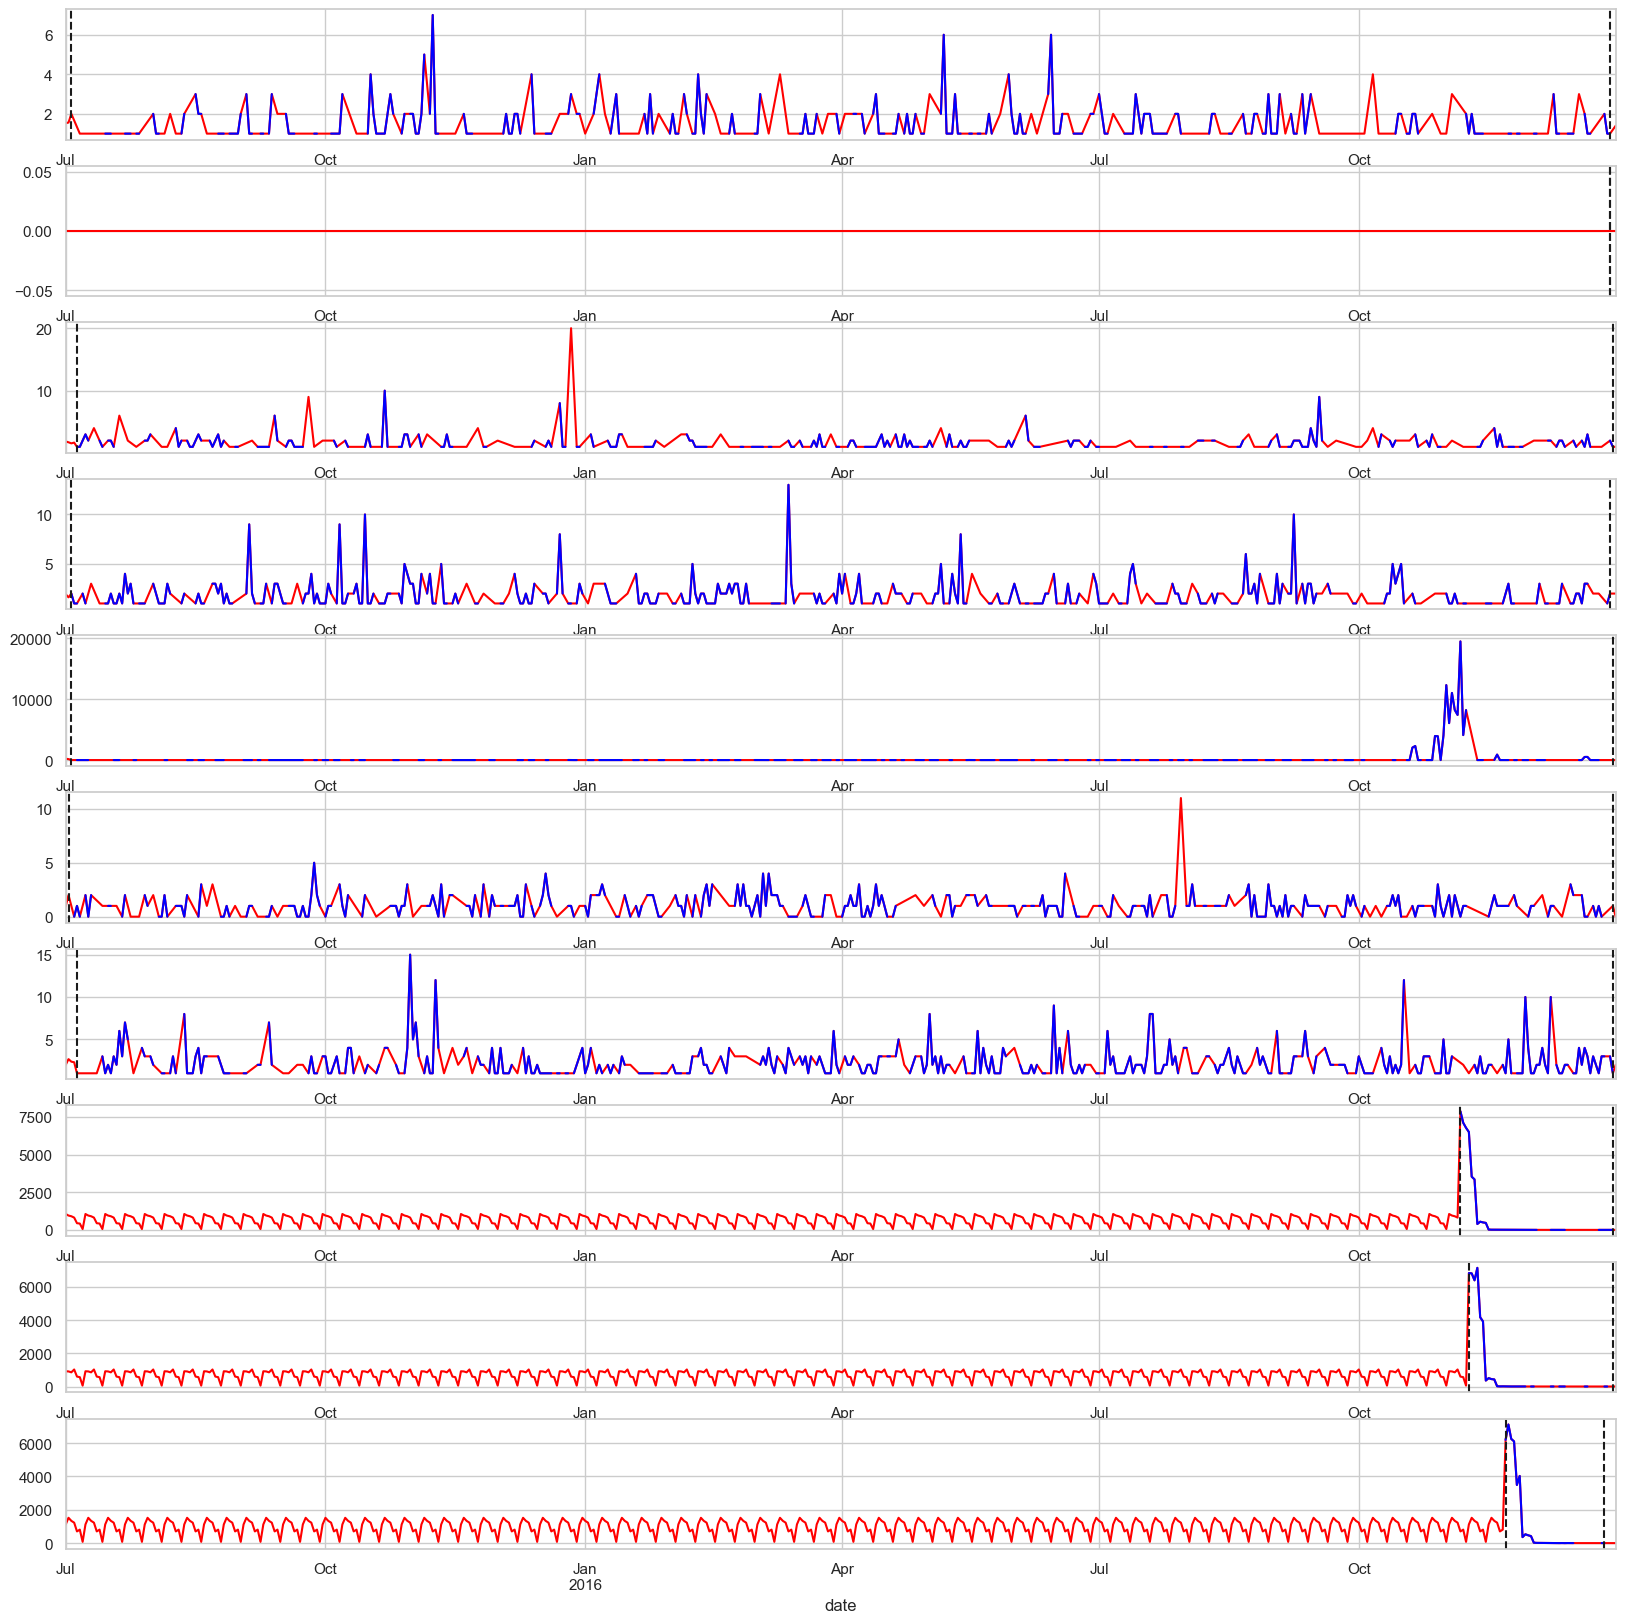

In [53]:
#visualize imputed missing values for a few pages

samples = missing_stats[(missing_stats['leading_nan'] > 0) & (missing_stats['trailing_nan'] > 0)].sample(10)
nan_pages = samples['Page']

before_impute = wide_to_long(df_impute[df_impute['Page'].isin(nan_pages)].copy())
after_impute = wide_to_long(df3[df3['Page'].isin(nan_pages)].copy())

date_range = before_impute.index.values

fig, axes = plt.subplots(10,1, figsize=(20,20))

for i,page in enumerate(before_impute.columns):
    page_stats = samples[samples['Page'] == page].iloc[0]
    start_date = date_range[page_stats['leading_nan']]
    end_date = date_range[len(date_range) - page_stats['trailing_nan'] - 1] 
    
    after_impute[page].plot(ax=axes[i], color='red')
    before_impute[page].plot(ax=axes[i], color='blue')
    
    #plot time series start and end dates 
    axes[i].axvline(start_date, color='k', linestyle='--')
    axes[i].axvline(end_date, color='k', linestyle='--')
    

## Aggregate time series at language level

In [54]:
#aggregate at lang level
dfa = df3.groupby('lang')[date_cols].sum().reset_index()

In [55]:
#convert to suitable time series format
tsdf = dfa.melt(id_vars = 'lang', value_vars = date_cols , var_name='date', value_name='visits')
tsdf['date'] = tsdf['date'].astype('datetime64')
tsdf = tsdf.pivot(index='date', columns='lang', values='visits')
tsdf.head(5)

lang                 de           en           es          fr           ja  \
date                                                                         
2015-07-01  14328814.16  91872176.21  16167604.81  9399041.21  13196795.11   
2015-07-02  14263512.59  91673021.19  15461579.84  9504531.34  14986157.03   
2015-07-03  13589629.06  87106965.13  14224284.51  9141672.30  13584090.38   
2015-07-04  12524700.51  90433329.95  13382774.72  9677815.85  16680273.82   
2015-07-05  14371518.17  92861747.85  14550545.55  9525408.35  16059241.86   

lang                 ru          zh  
date                                 
2015-07-01  10472982.78  5757508.76  
2015-07-02  10567539.41  5885129.00  
2015-07-03   9760040.54  5829426.25  
2015-07-04   9148939.88  5848968.79  
2015-07-05   9670402.07  6017794.92

In [56]:
#read en campaing data
exog_en_camp = pd.read_csv('Exog_Campaign_eng.csv')['Exog']

        

In [57]:
pq.write_table(pa.Table.from_pandas(tsdf), 'lang_time_series.parquet')
#pq.read_pandas('lang_time_series.parquet').to_pandas()

## Aggregated Time series analysis (for each language)

In [58]:
#retrieves dates corresponding to exog from the given ts
def getcampaigndates(ts, campaigns):
    ret = []
    if(campaigns is not None):
        ret = ts.index[campaigns[campaigns == 1].index.values]
    return ret

#plots time series along and marks campaign dates 
def plot_ts(ts, title='', campaigns=None):
    ax = ts.plot(figsize=(20,3))
    ax.set_title(title, fontdict={'fontsize':20})
    campaign_dates = getcampaigndates(ts, campaigns)
    
    for cd in campaign_dates:
        ax.axvline(cd, color='r', linestyle='-', alpha=0.5)


### Basic visualization

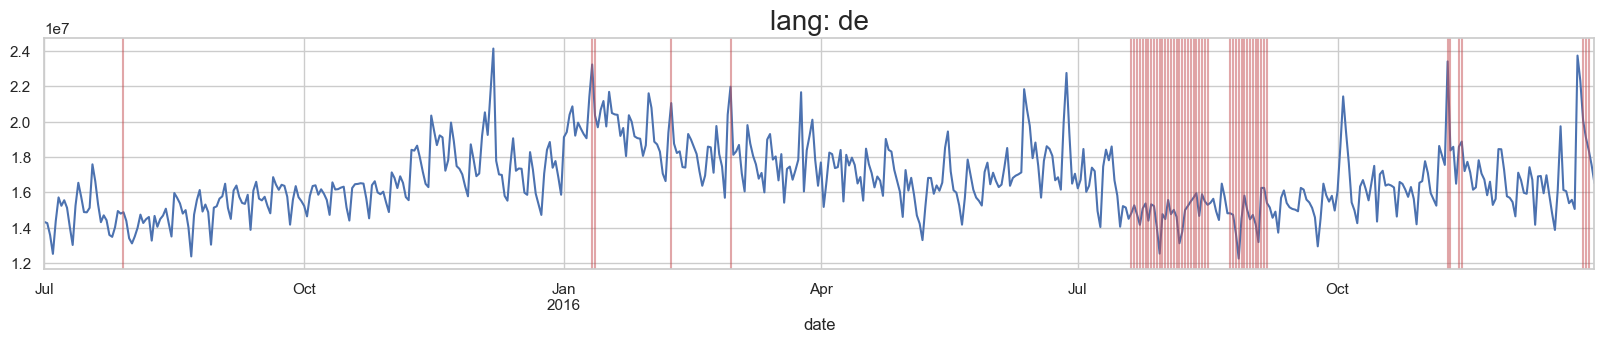

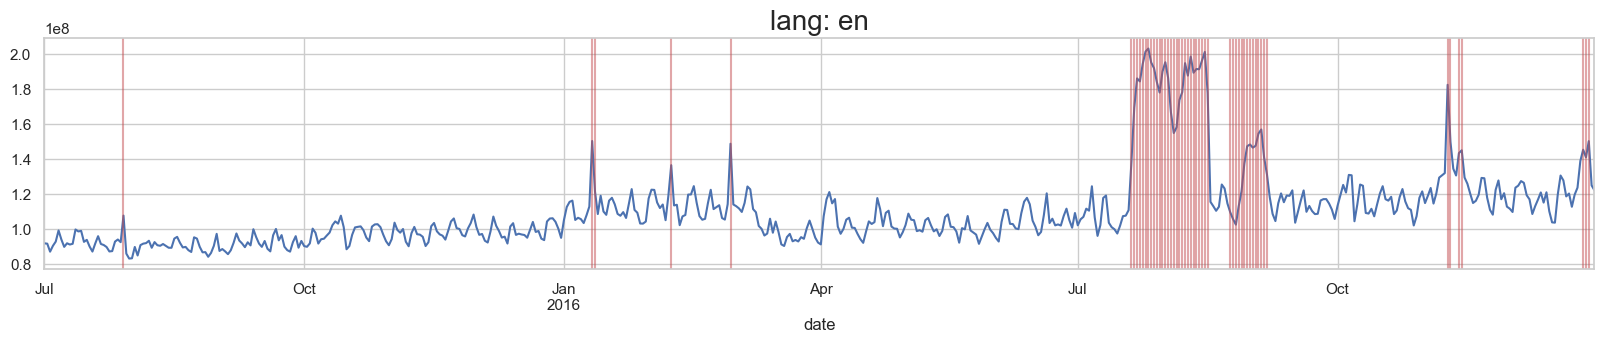

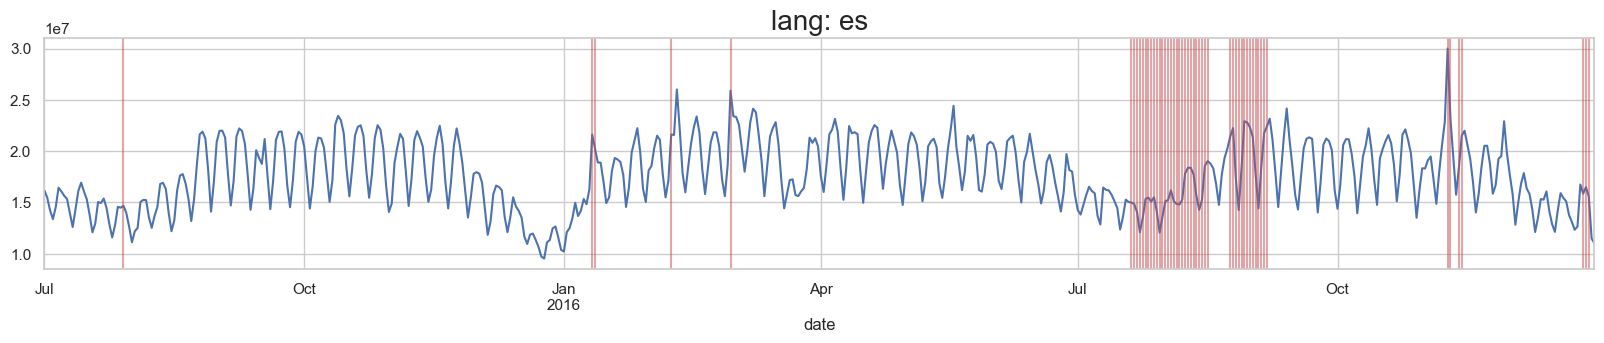

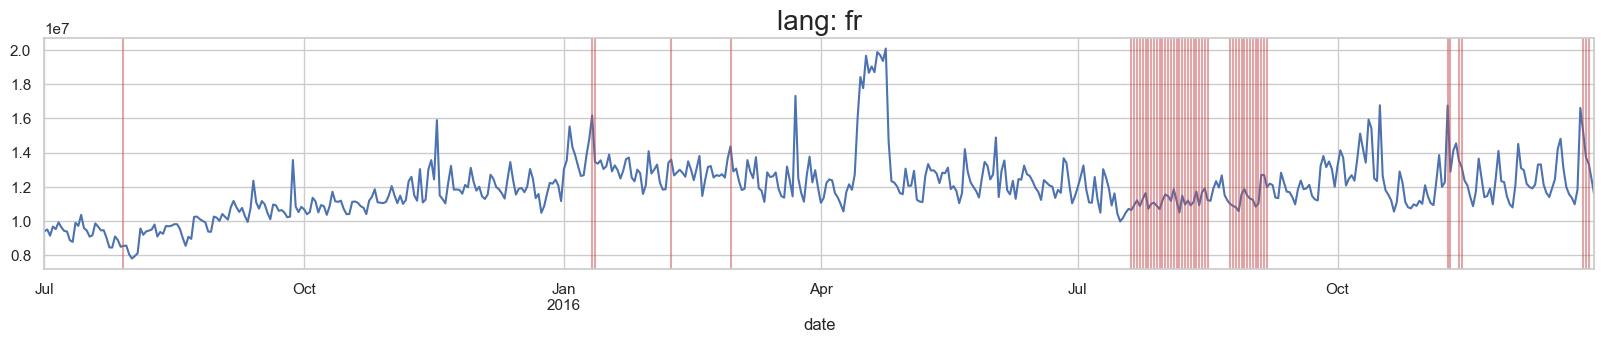

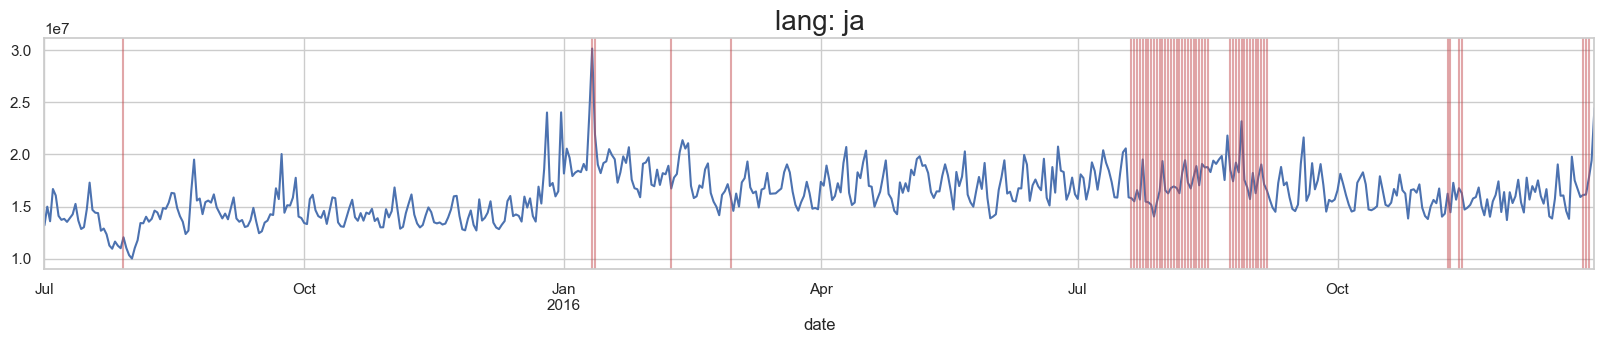

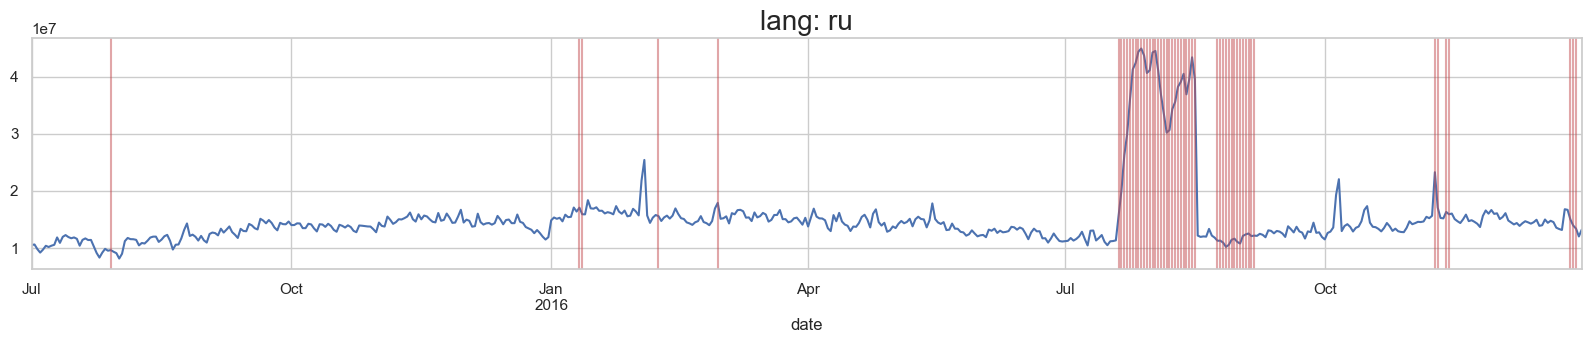

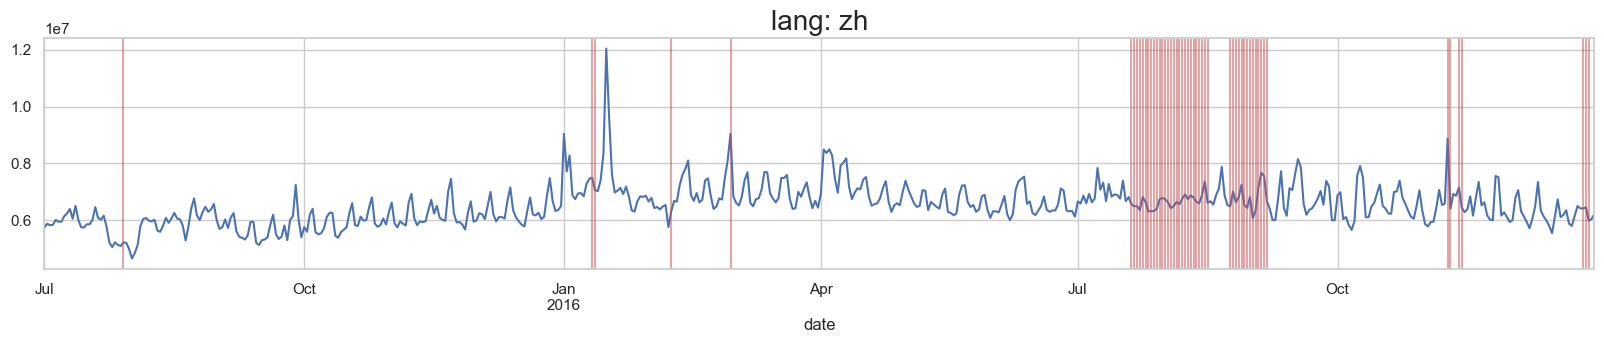

In [59]:
#plot time series for each language
for lang in tsdf.columns:
    plot_ts(tsdf[lang], 'lang: '+ lang, exog_en_camp)
    plt.show()

### Effect of campaigns

In [60]:
tsdf2 = tsdf.copy()
tsdf2['campaign_en'] = exog_en_camp.values
tsdf2 = tsdf2.melt(value_vars=tsdf.columns, id_vars='campaign_en')
tsdf2['value'] = tsdf2['value'] / 1000000

<AxesSubplot:xlabel='lang', ylabel='value'>

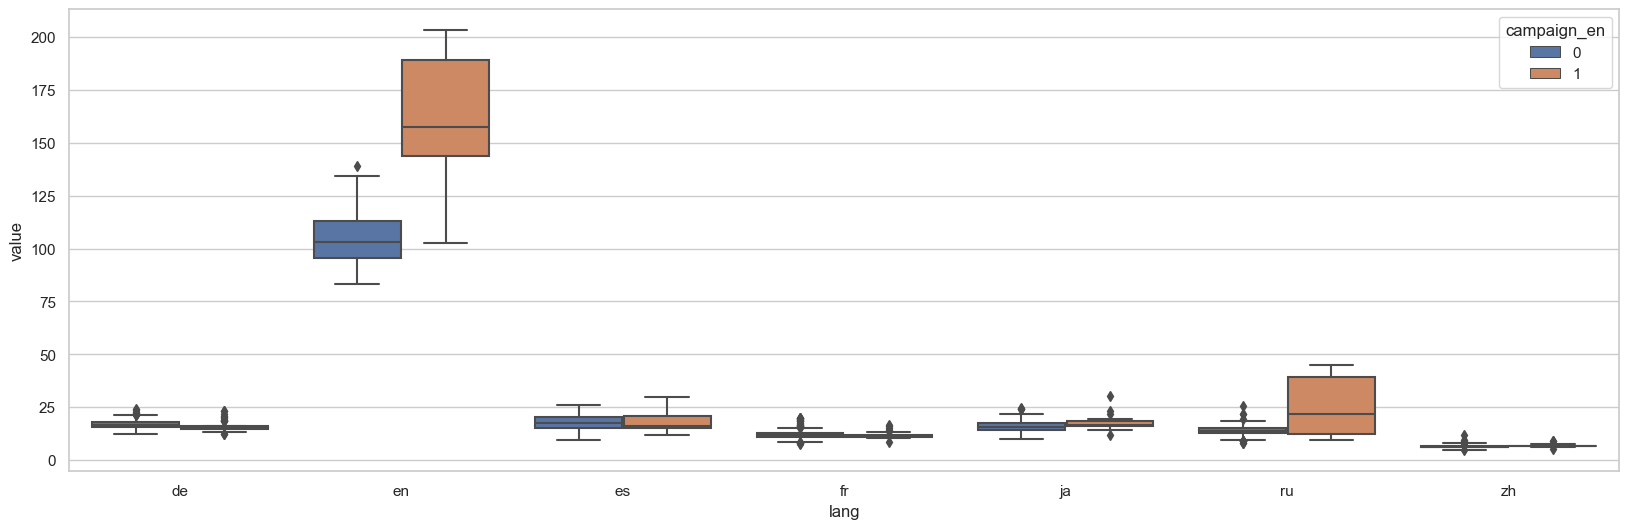

In [61]:
sns.boxplot(y='value', x='lang', hue='campaign_en', data=tsdf2)

In [62]:
#check campaign effect on varios languages
res = tsdf2.groupby(['lang', 'campaign_en'])['value'].mean().unstack()
res['campaign effect in %'] = np.round((res[1] - res[0])/res[0] * 100, 2)
res

campaign_en           0           1  campaign effect in %
lang                                                     
de            16.747304   15.919777                 -4.94
en           104.569724  161.975691                 54.90
es            17.680625   17.691768                  0.06
fr            11.925797   11.805829                 -1.01
ja            16.046981   17.377638                  8.29
ru            13.780405   25.624513                 85.95
zh             6.502000    6.750086                  3.82

**Observation:** We can observe that campaigns for 'en' pages had positive effect on total user visits. The %increase in visits is 55%. The absolute positive increase is 161 million visits. All other languages, except for 'ru', have no significant impact because of campaigns run for 'en' language. 'ru' language pages, interestingly, show ~86% increase on campaign days for 'en' language. Since we do not have campaign details about other languages, it is quite possible that similar campaigns were run on the same days for 'ru' as well. In the absence of any information, we will not use 'en' campaign information for 'ru' models. 

### Stationarity, decomposition, and differencing

In [63]:
#define helper functions
def printmd(string):
    display(Markdown(string))
    
#attempts to make series stationary by differencing
def diff_stationary(ts, max_order=2):
    d, dts, is_stationary = 0, ts, adf_test(ts)
    while(not is_stationary and d < max_order):
        d += 1
        dts = dts.diff()
        is_stationary = adf_test(dts)
    return is_stationary, d, dts

#removing seasonal effect
def sesasonal_diff(ts, period=7):
    ts2 = ts.diff(period).dropna()
    return adf_test(ts2), ts2
    
#returns mean effect of campaign on visits (in % increase/decrease).
def get_campaign_effect(ts, campaigns):
    df = pd.DataFrame(data={'visits': ts, 'campaign': campaigns.values}, index=ts.index)
    mean_no_camp = np.round(df[df['campaign'] == 0]['visits'].mean())
    mean_camp = np.round(df[df['campaign'] == 1]['visits'].mean())
    mean_diff = mean_camp - mean_no_camp
    effect = np.round((mean_camp - mean_no_camp) / mean_no_camp ,2)
    return mean_diff, effect

#returns a new timeseries after adding/subtracting campaign effects
def adjust_campaign_effect(ts, campaigns, effect, action='add', method='additive'):
    ts2 = ts.copy()
    indices = campaigns[campaigns == 1].index
    if(method == 'multiplicative'):
        ts2.iloc[indices] = ts2.iloc[indices] * (1 + effect) if(action == 'add') else ts2.iloc[indices] / (1 + effect)
    elif(method == 'additive'):
        ts2.iloc[indices] = ts2.iloc[indices] + effect if(action == 'add') else ts2.iloc[indices] - effect
    return ts2

def show_acf_pcf_plots(ts, name=''):
    fig, ax = plt.subplots(1,2, figsize=(20,3))
    plot_acf(ts, title=f'ACF {name}', ax=ax[0]) 
    plot_pacf(ts, title=f'PACF {name}', method='ywm',ax=ax[1])
    plt.show()


#### <br/> <span style="color:blue">1. Language: de </span> <br/>

**Original time series** (*Red lines correspond to campaign dates for English*)

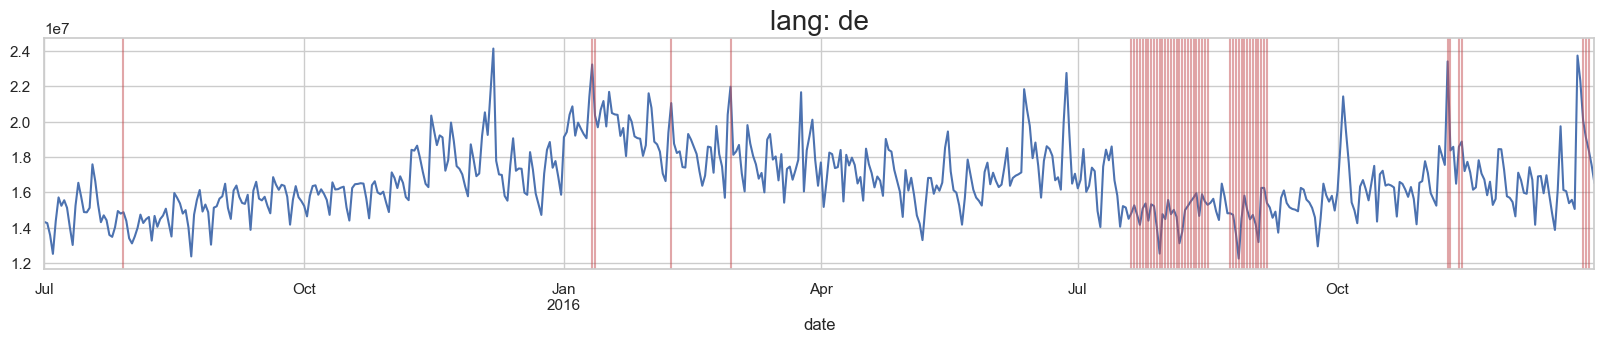

**Stationarity, ACF, and PACF**

Time series with **0-order** differencing and **no** seasonal differencing: **non-stationary**

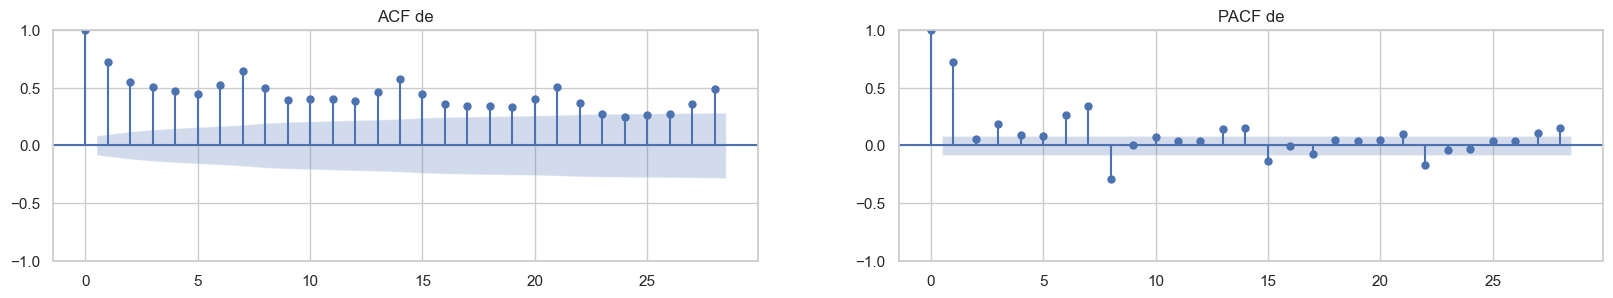

Time series with **1-order** differencing and **no** seasonal differencing: **stationary**

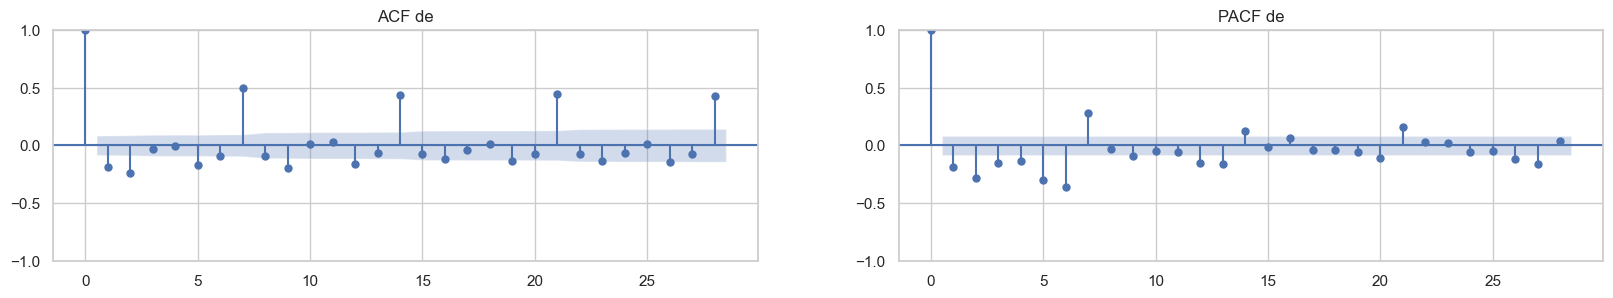

Time series with **2-order** differencing and **no** seasonal differencing: **stationary**

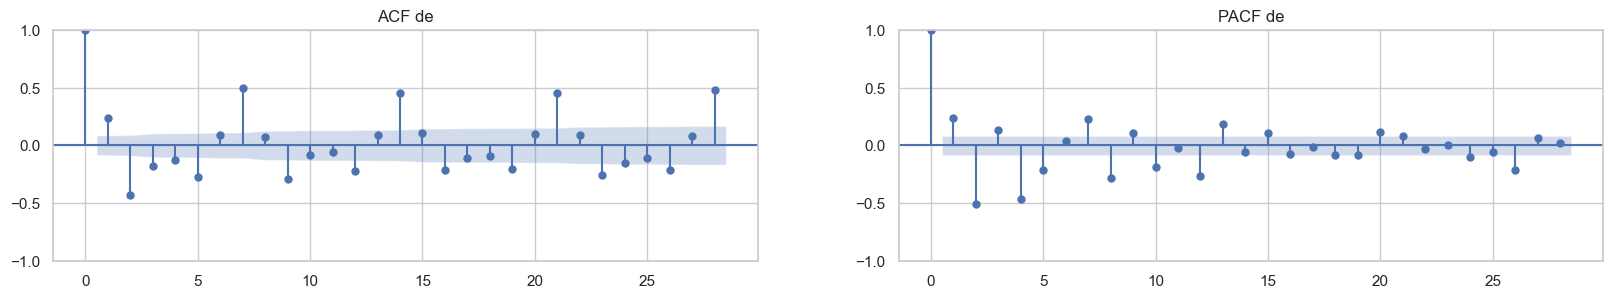

Time series with **0-order** differencing and **weekly** seasonal differencing: **stationary**

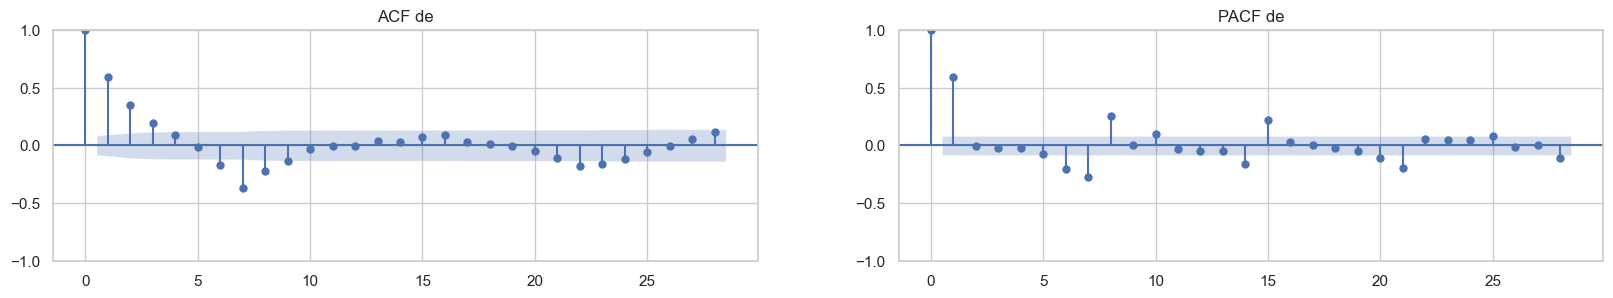

Time series with **1-order** differencing and **weekly** seasonal differencing: **stationary**

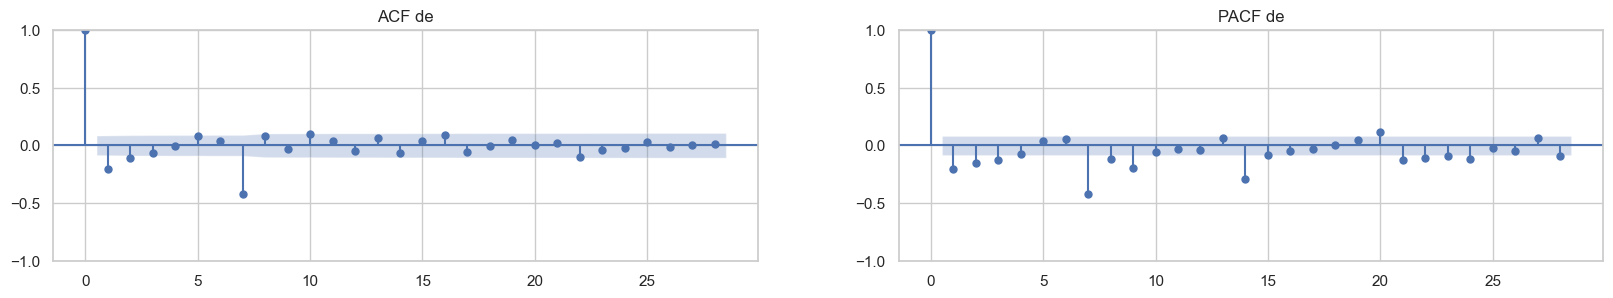

Time series with **2-order** differencing and **weekly** seasonal differencing: **stationary**

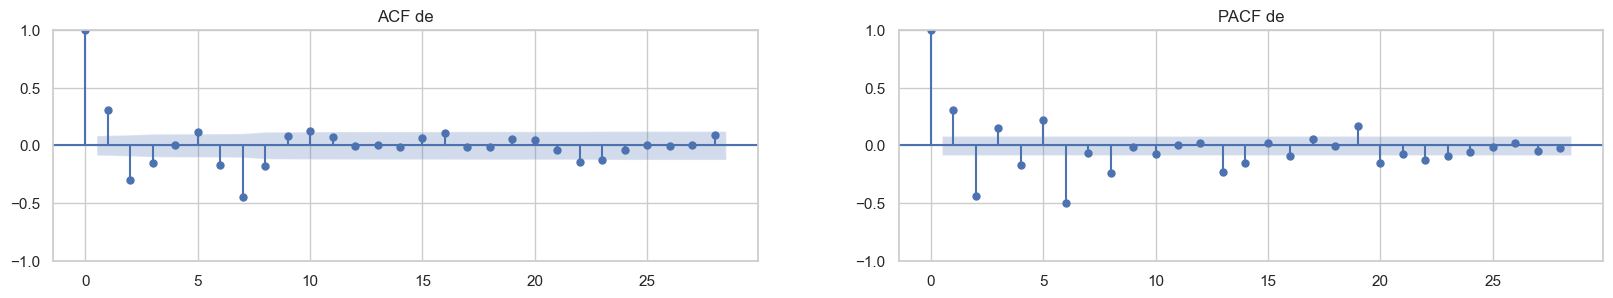

**Time Series Decomposition**

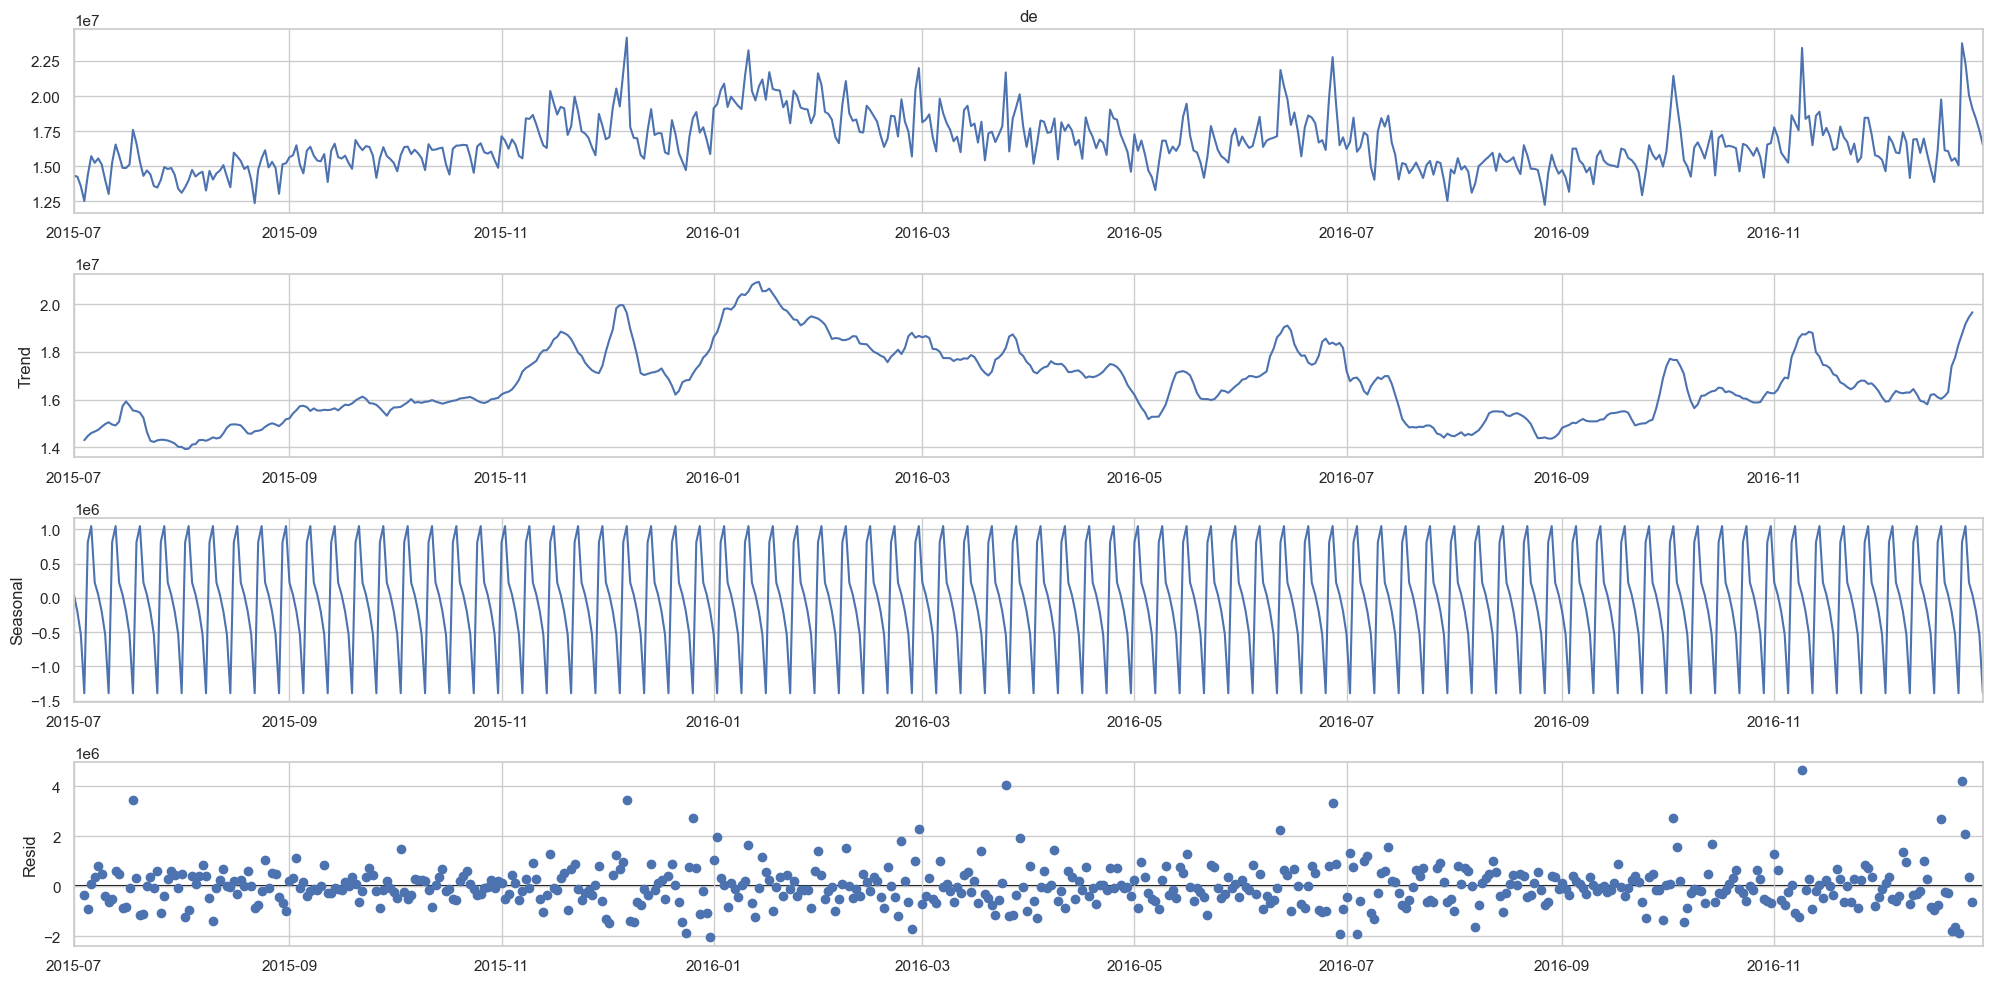

**Residuals are stationary**

#### <br/> <span style="color:blue">2. Language: en </span> <br/>

**Original time series** (*Red lines correspond to campaign dates for English*)

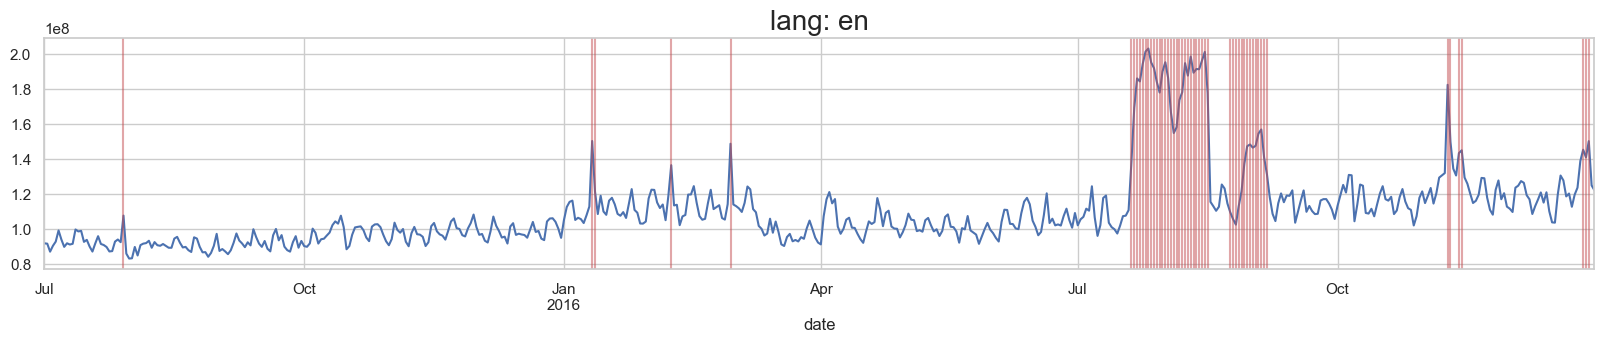

**Adjusted time series** (*after removing campaign effect*)

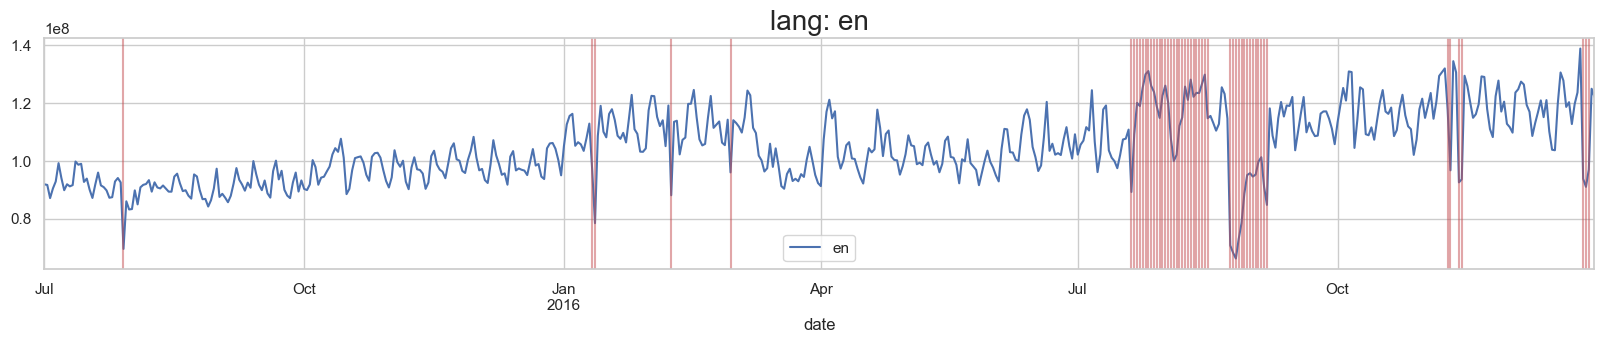

**Stationarity, ACF, and PACF**

Time series with **0-order** differencing and **no** seasonal differencing: **non-stationary**

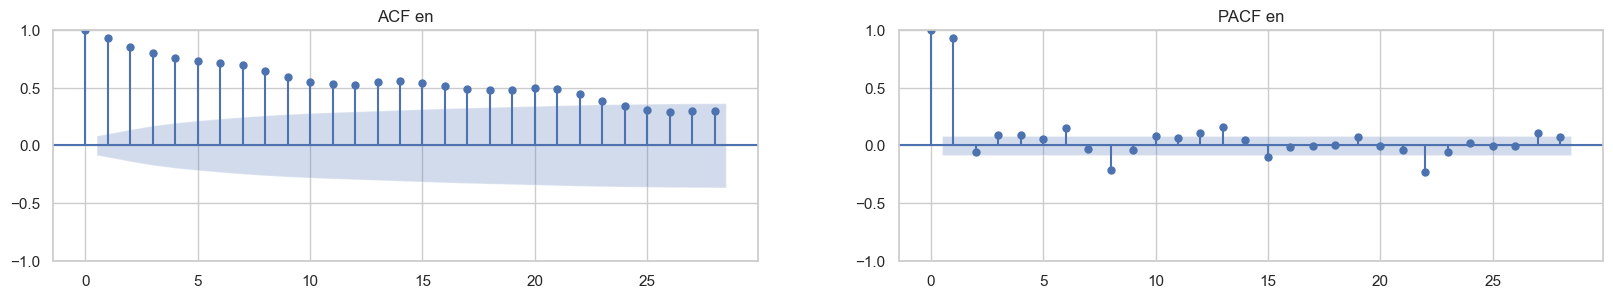

Time series with **1-order** differencing and **no** seasonal differencing: **stationary**

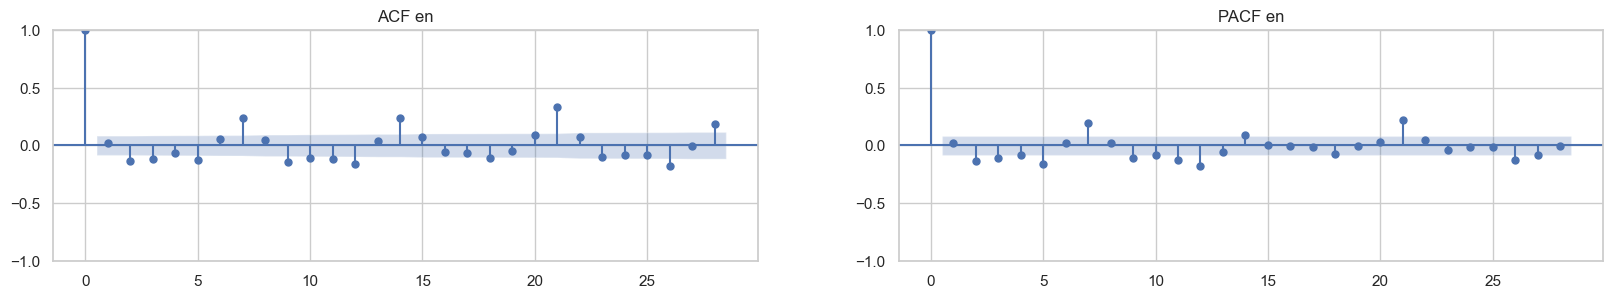

Time series with **2-order** differencing and **no** seasonal differencing: **stationary**

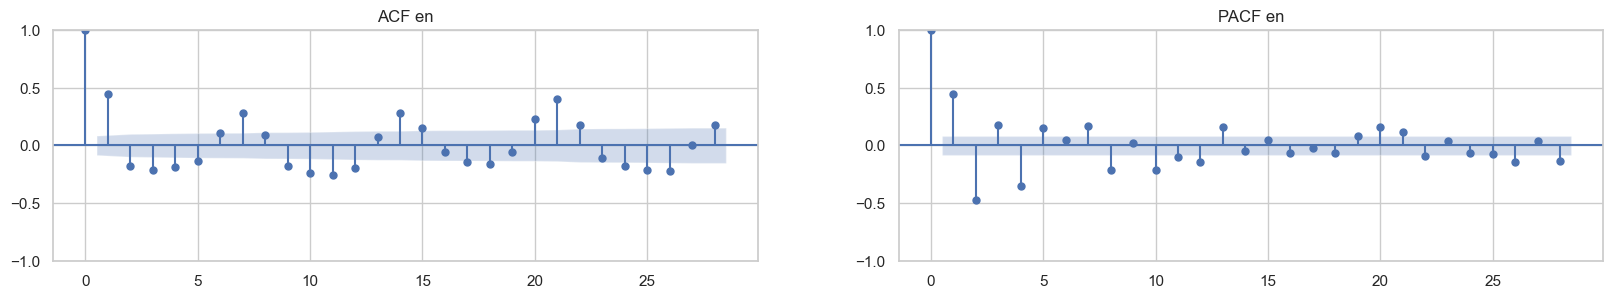

Time series with **0-order** differencing and **weekly** seasonal differencing: **stationary**

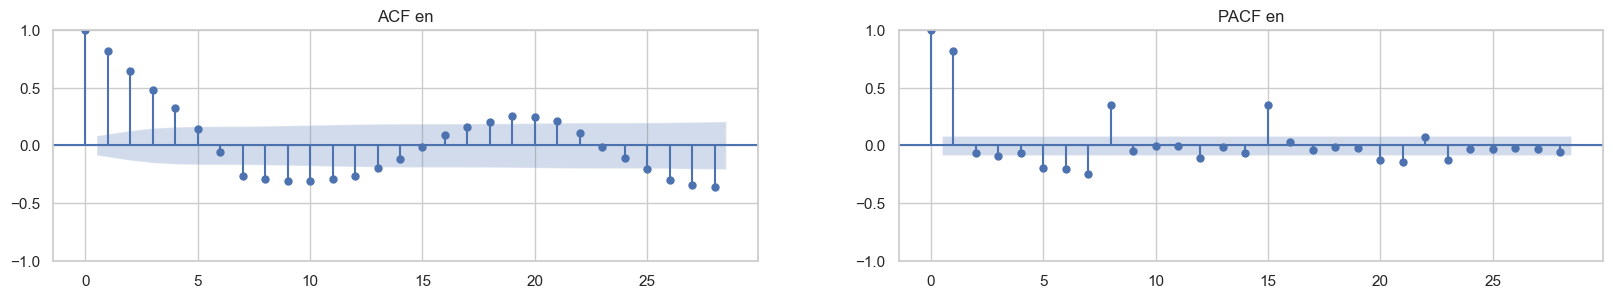

Time series with **1-order** differencing and **weekly** seasonal differencing: **stationary**

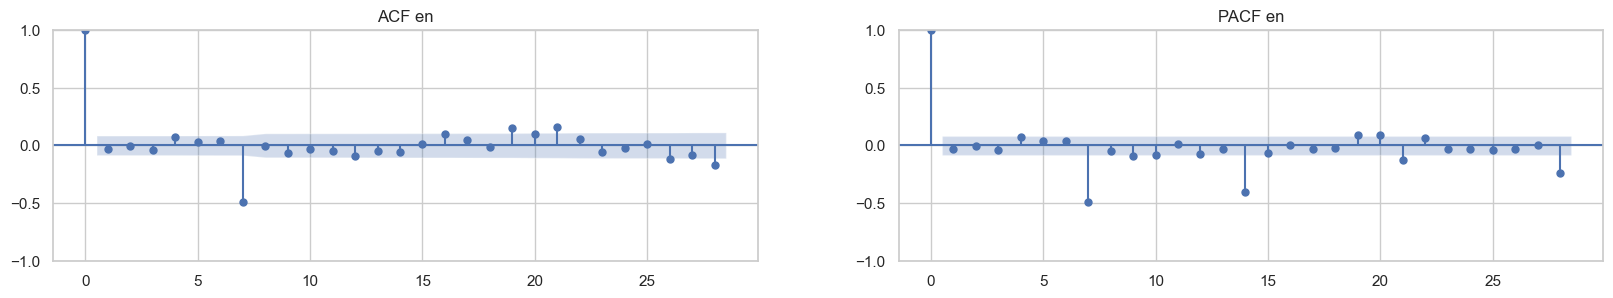

Time series with **2-order** differencing and **weekly** seasonal differencing: **stationary**

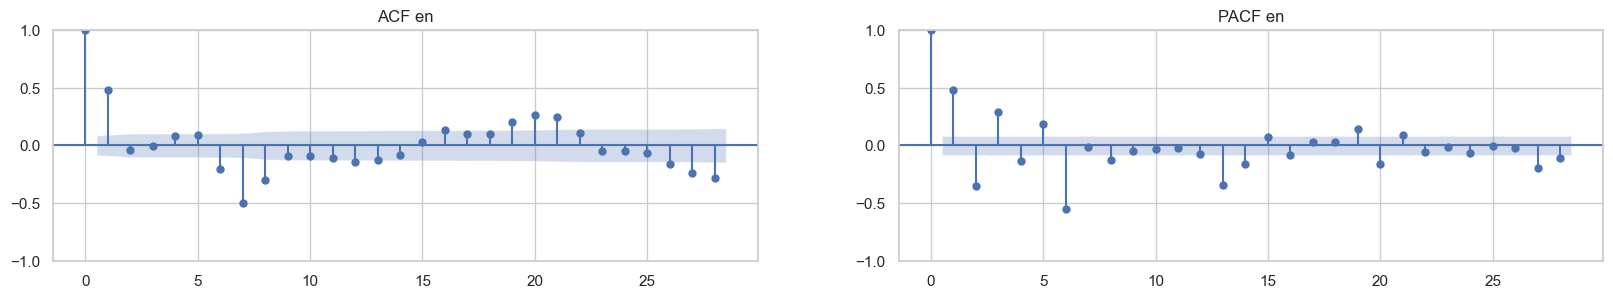

**Time Series Decomposition**

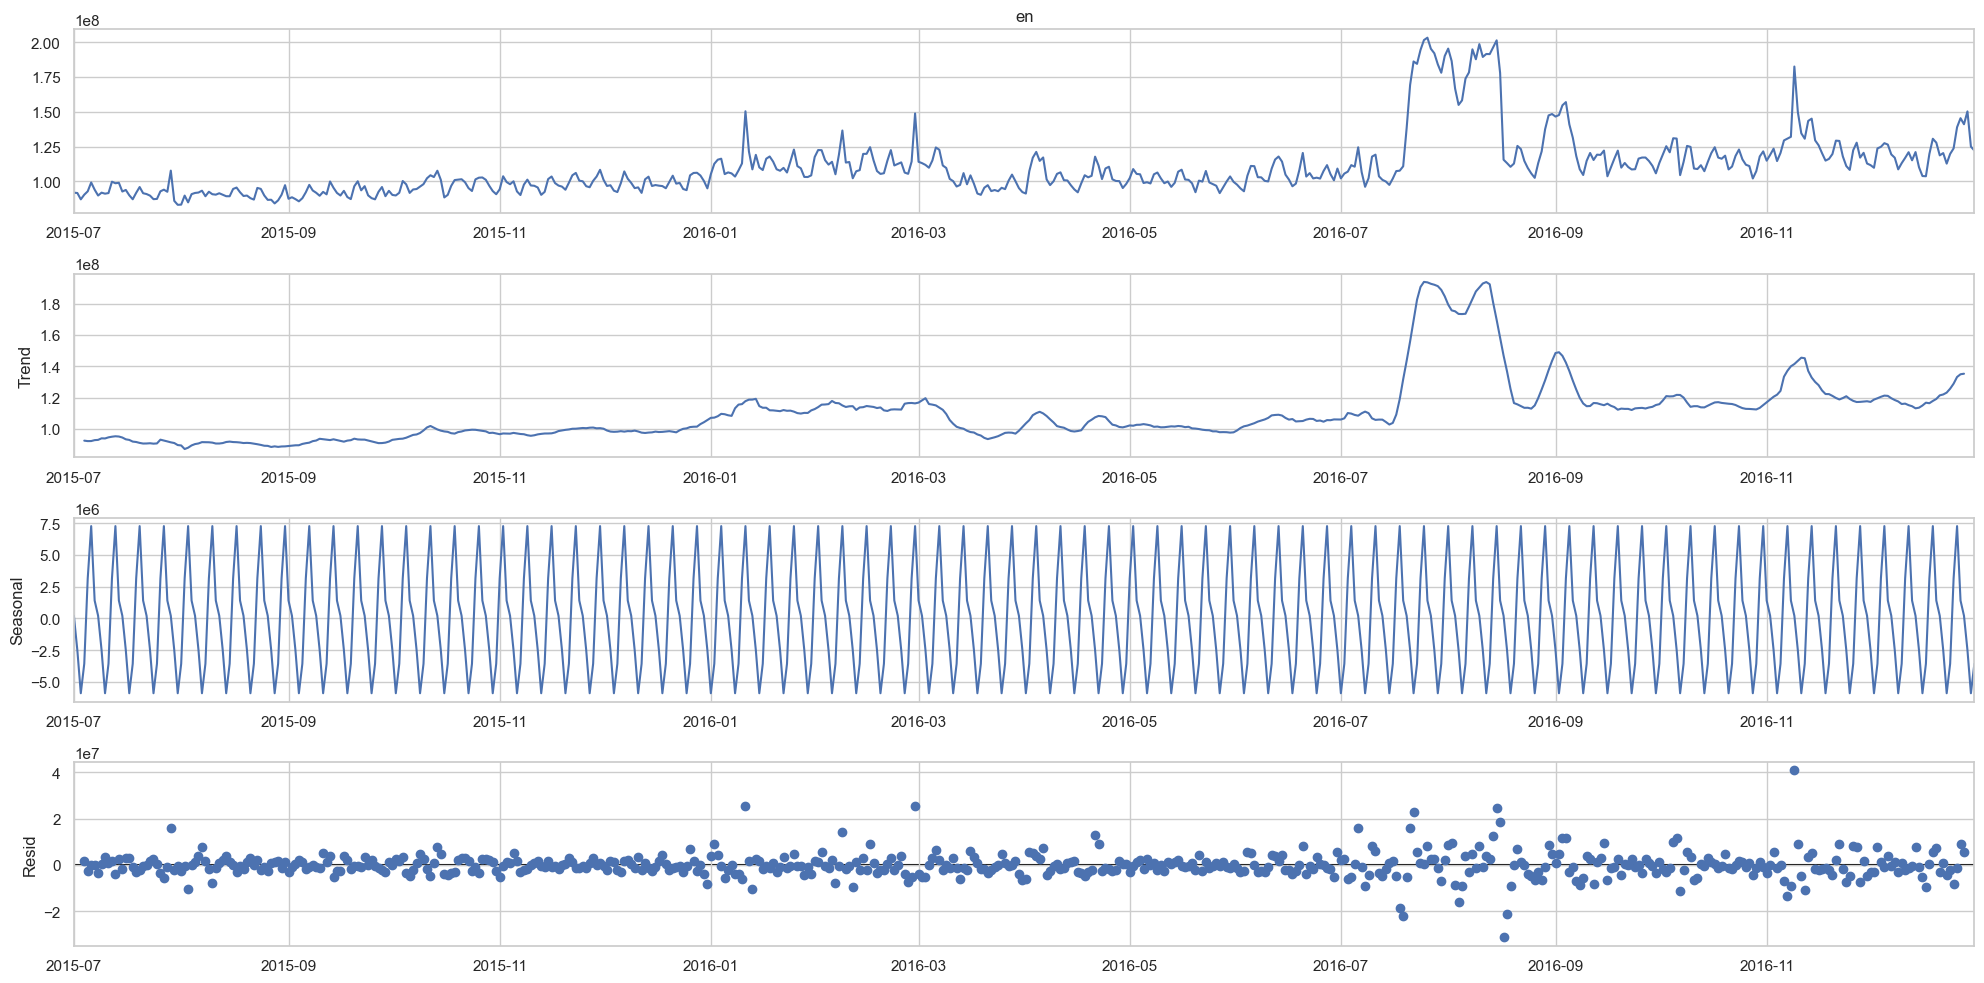

**Residuals are stationary**

#### <br/> <span style="color:blue">3. Language: es </span> <br/>

**Original time series** (*Red lines correspond to campaign dates for English*)

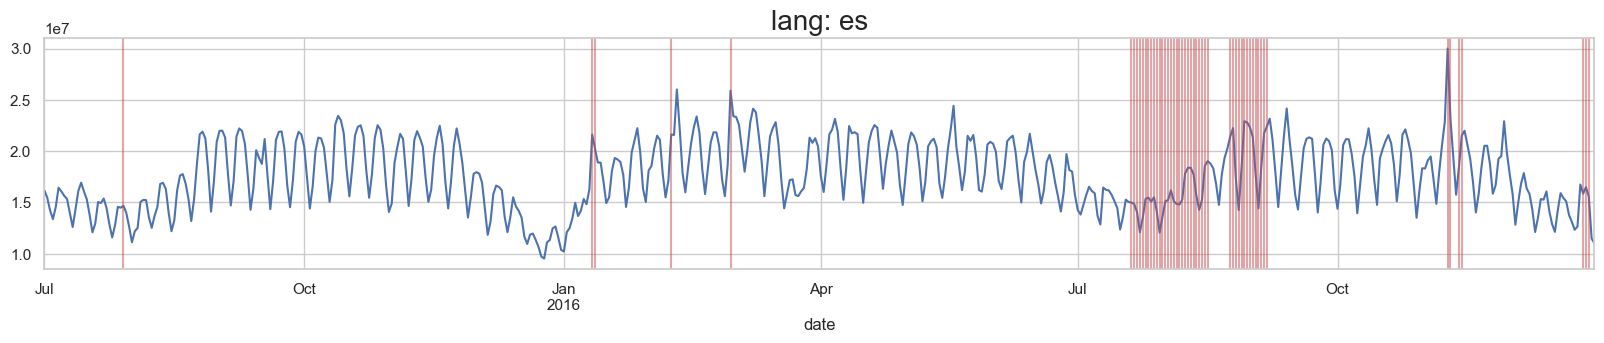

**Stationarity, ACF, and PACF**

Time series with **0-order** differencing and **no** seasonal differencing: **stationary**

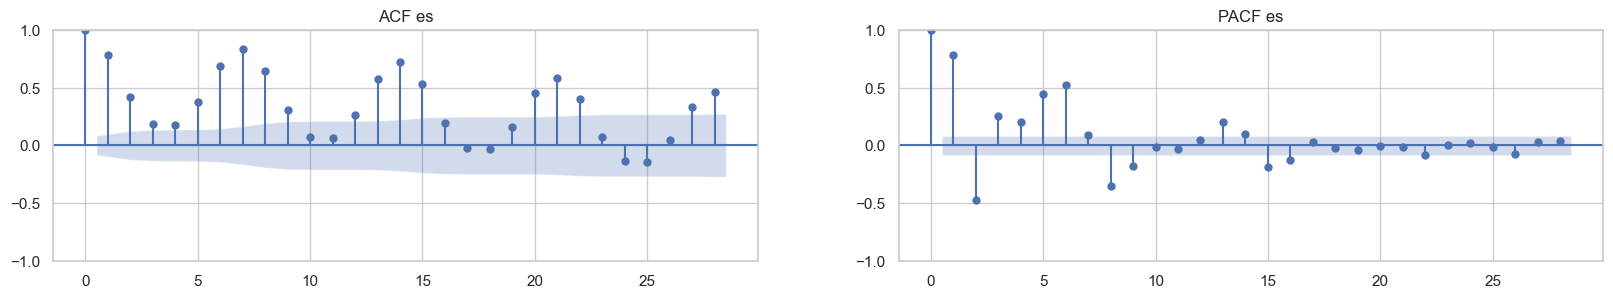

Time series with **1-order** differencing and **no** seasonal differencing: **stationary**

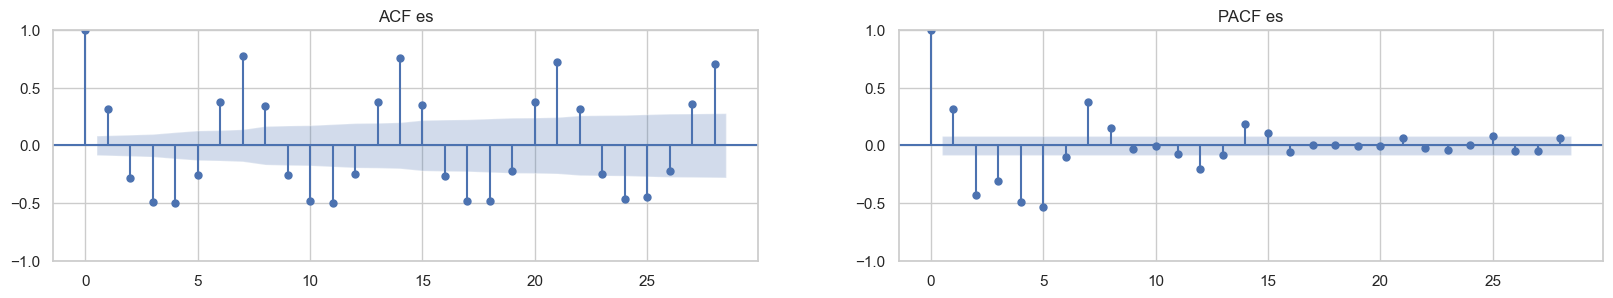

Time series with **2-order** differencing and **no** seasonal differencing: **stationary**

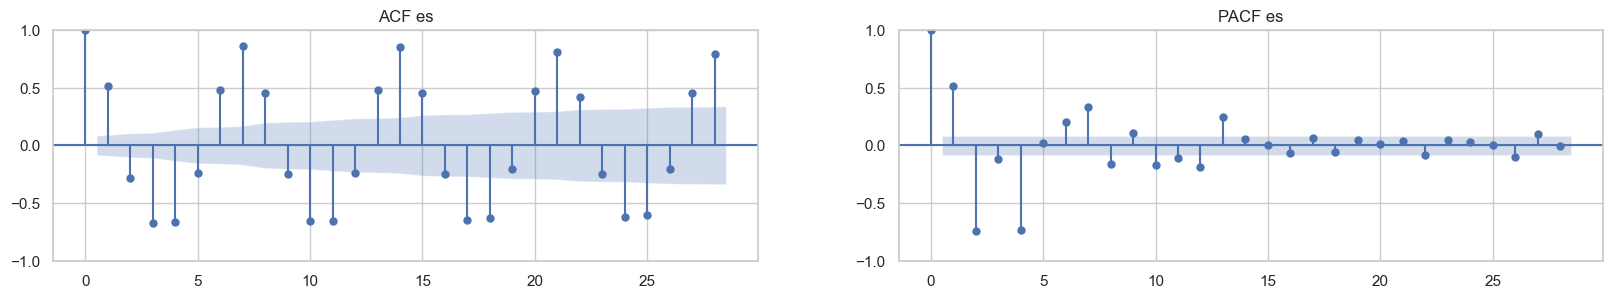

Time series with **0-order** differencing and **weekly** seasonal differencing: **stationary**

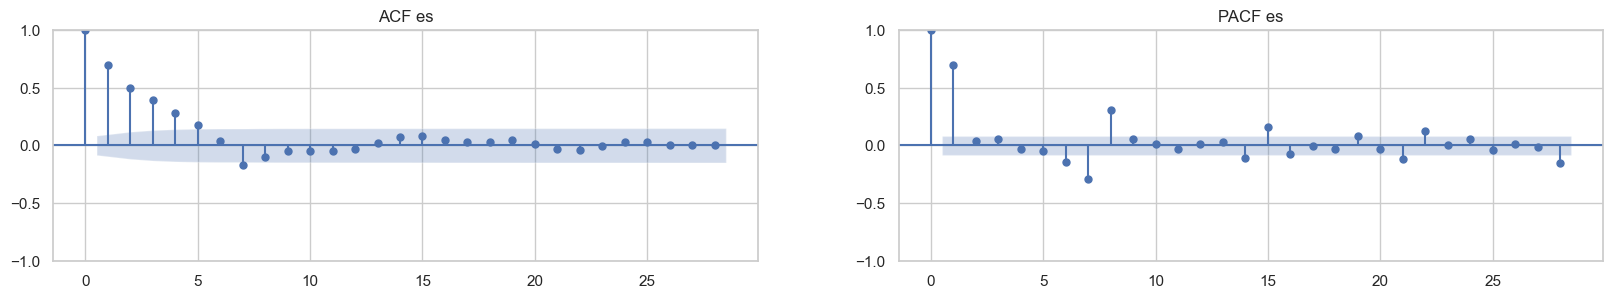

Time series with **1-order** differencing and **weekly** seasonal differencing: **stationary**

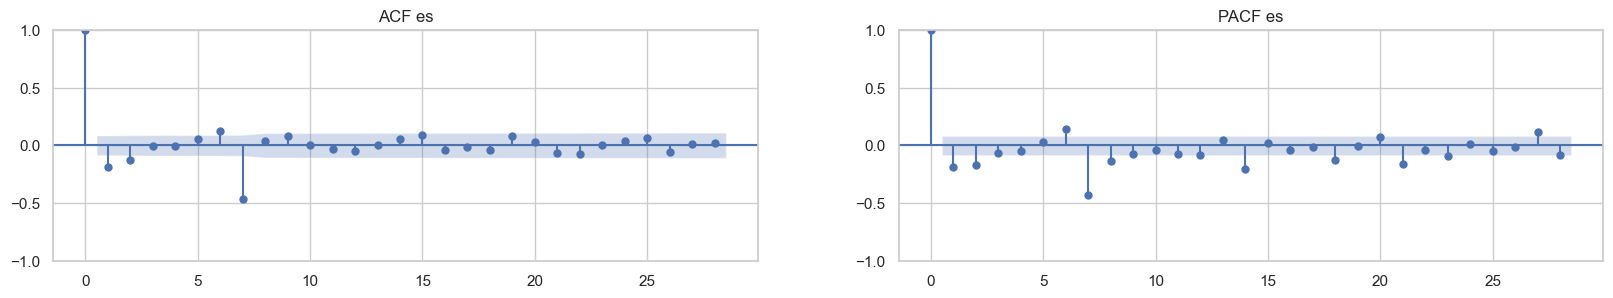

Time series with **2-order** differencing and **weekly** seasonal differencing: **stationary**

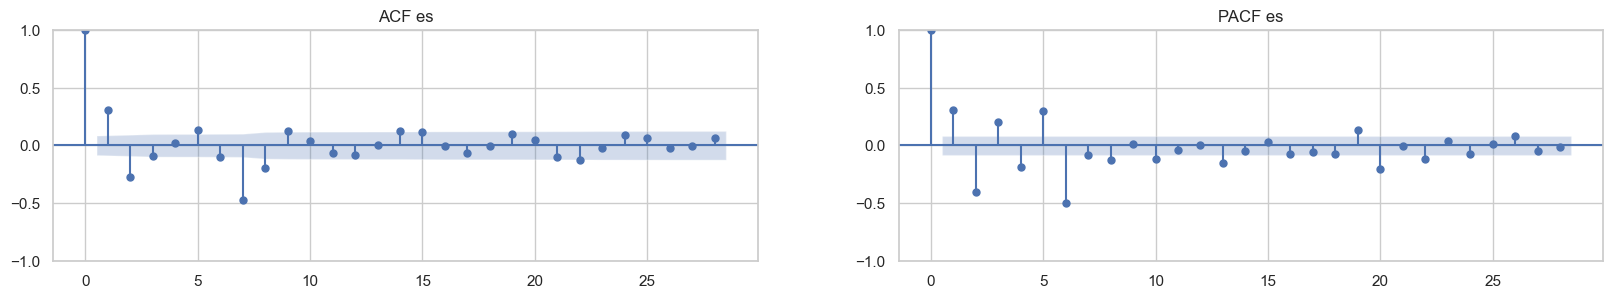

**Time Series Decomposition**

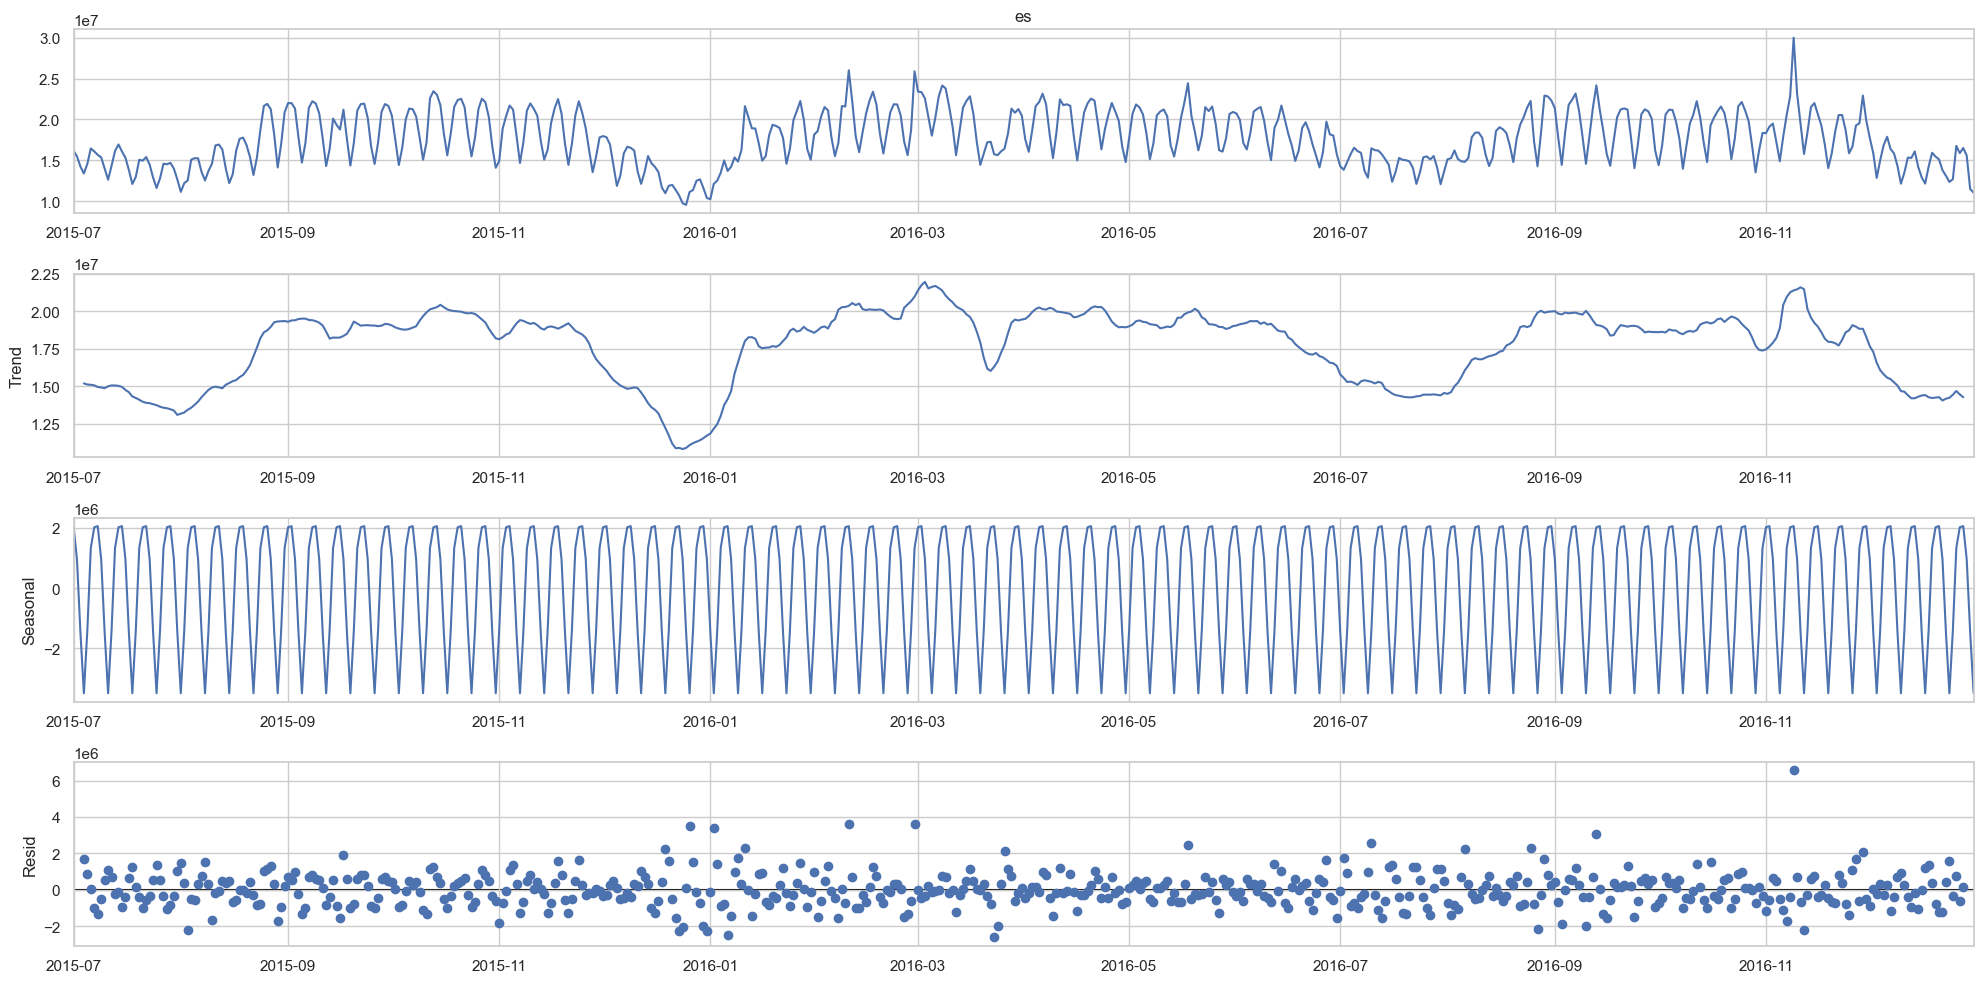

**Residuals are stationary**

#### <br/> <span style="color:blue">4. Language: fr </span> <br/>

**Original time series** (*Red lines correspond to campaign dates for English*)

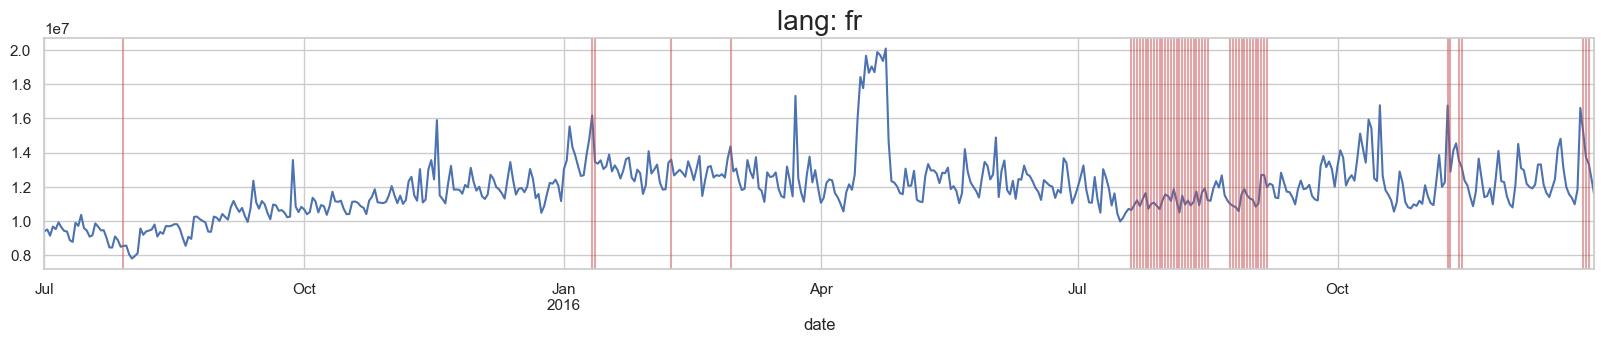

**Stationarity, ACF, and PACF**

Time series with **0-order** differencing and **no** seasonal differencing: **stationary**

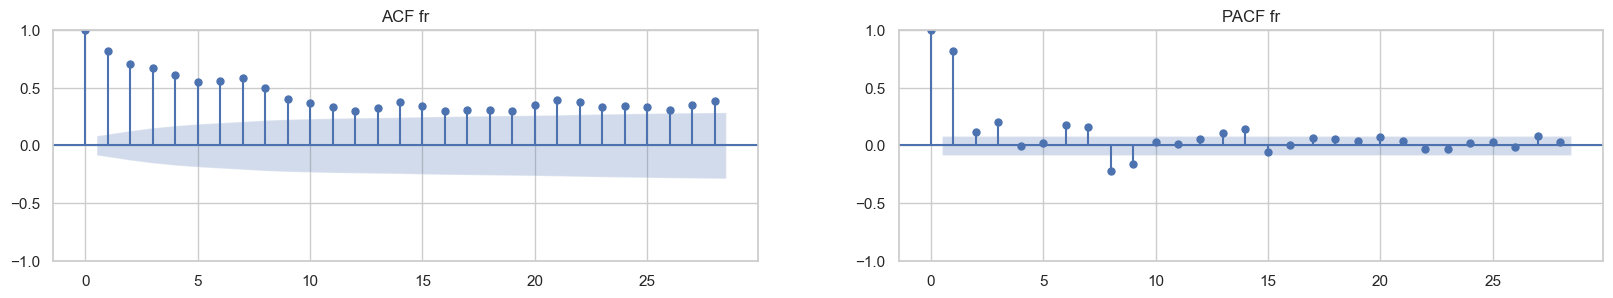

Time series with **1-order** differencing and **no** seasonal differencing: **stationary**

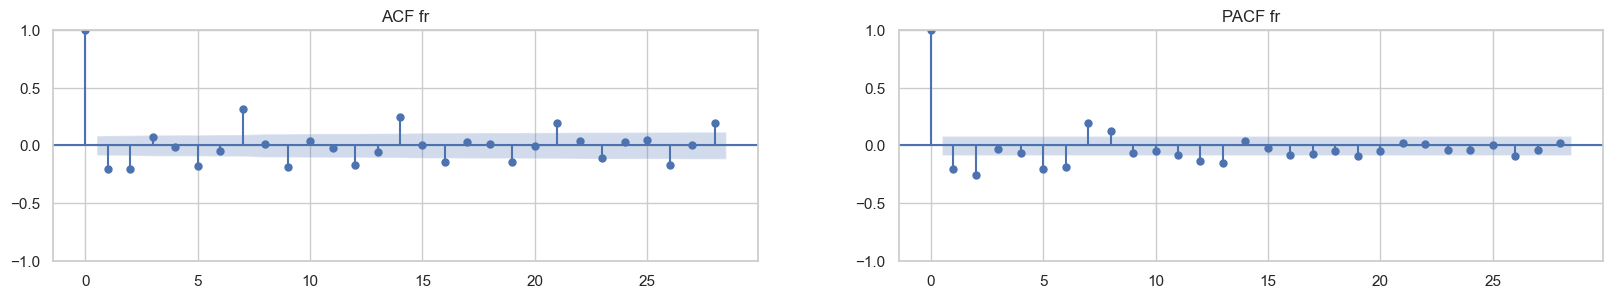

Time series with **2-order** differencing and **no** seasonal differencing: **stationary**

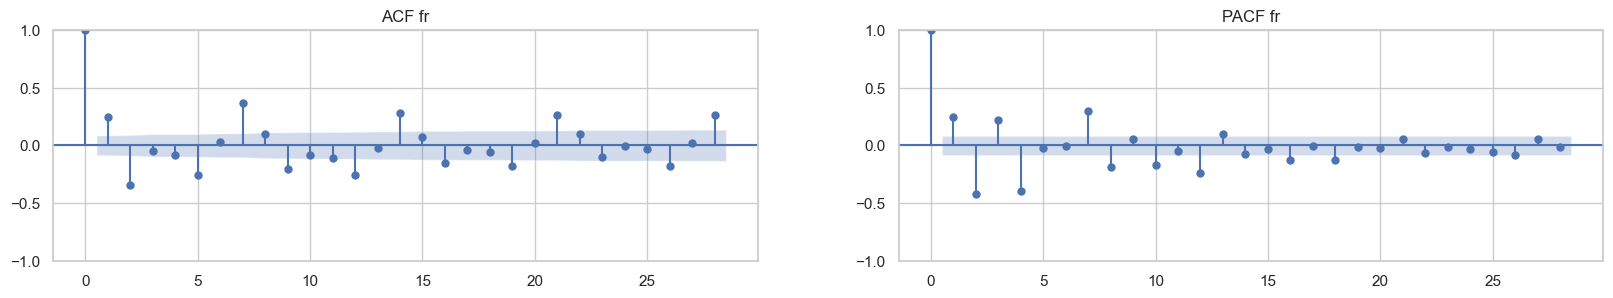

Time series with **0-order** differencing and **weekly** seasonal differencing: **stationary**

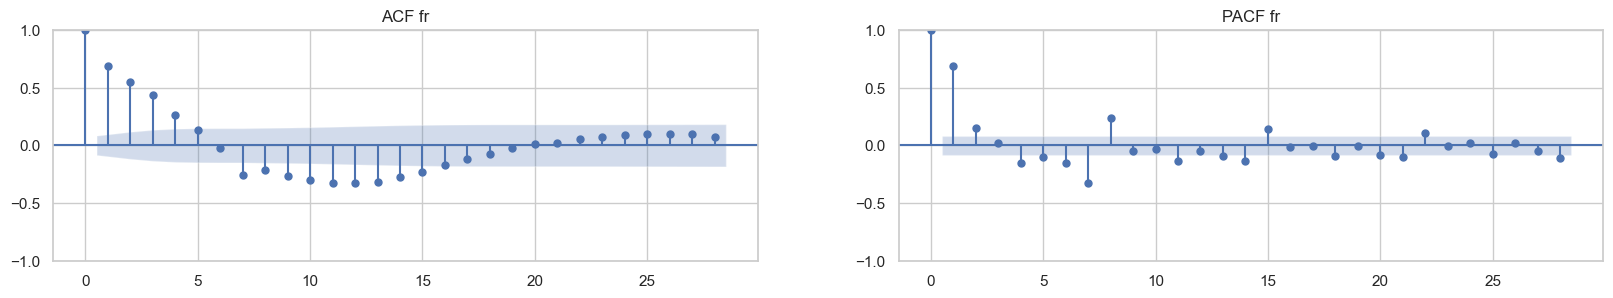

Time series with **1-order** differencing and **weekly** seasonal differencing: **stationary**

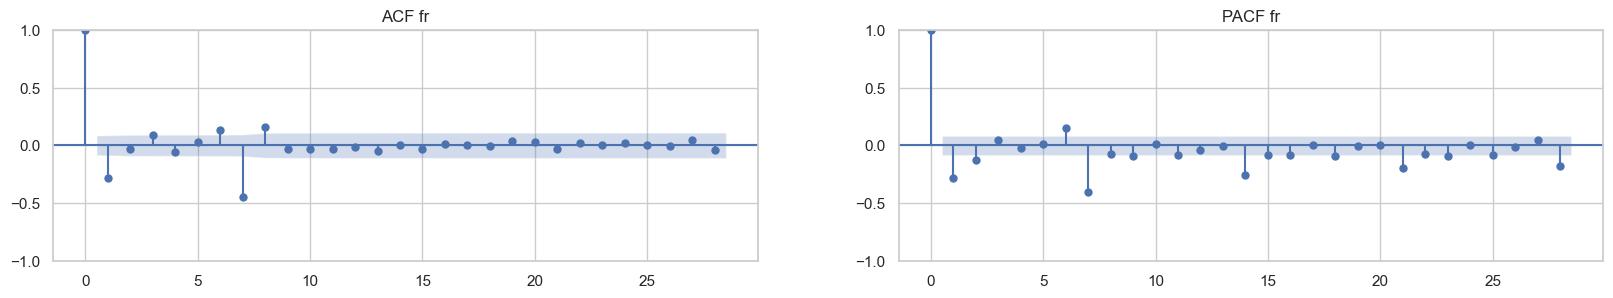

Time series with **2-order** differencing and **weekly** seasonal differencing: **stationary**

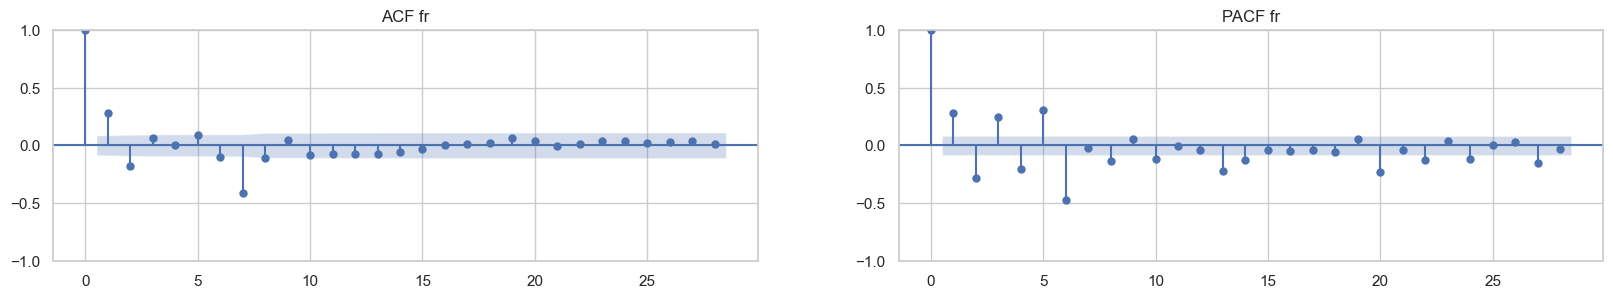

**Time Series Decomposition**

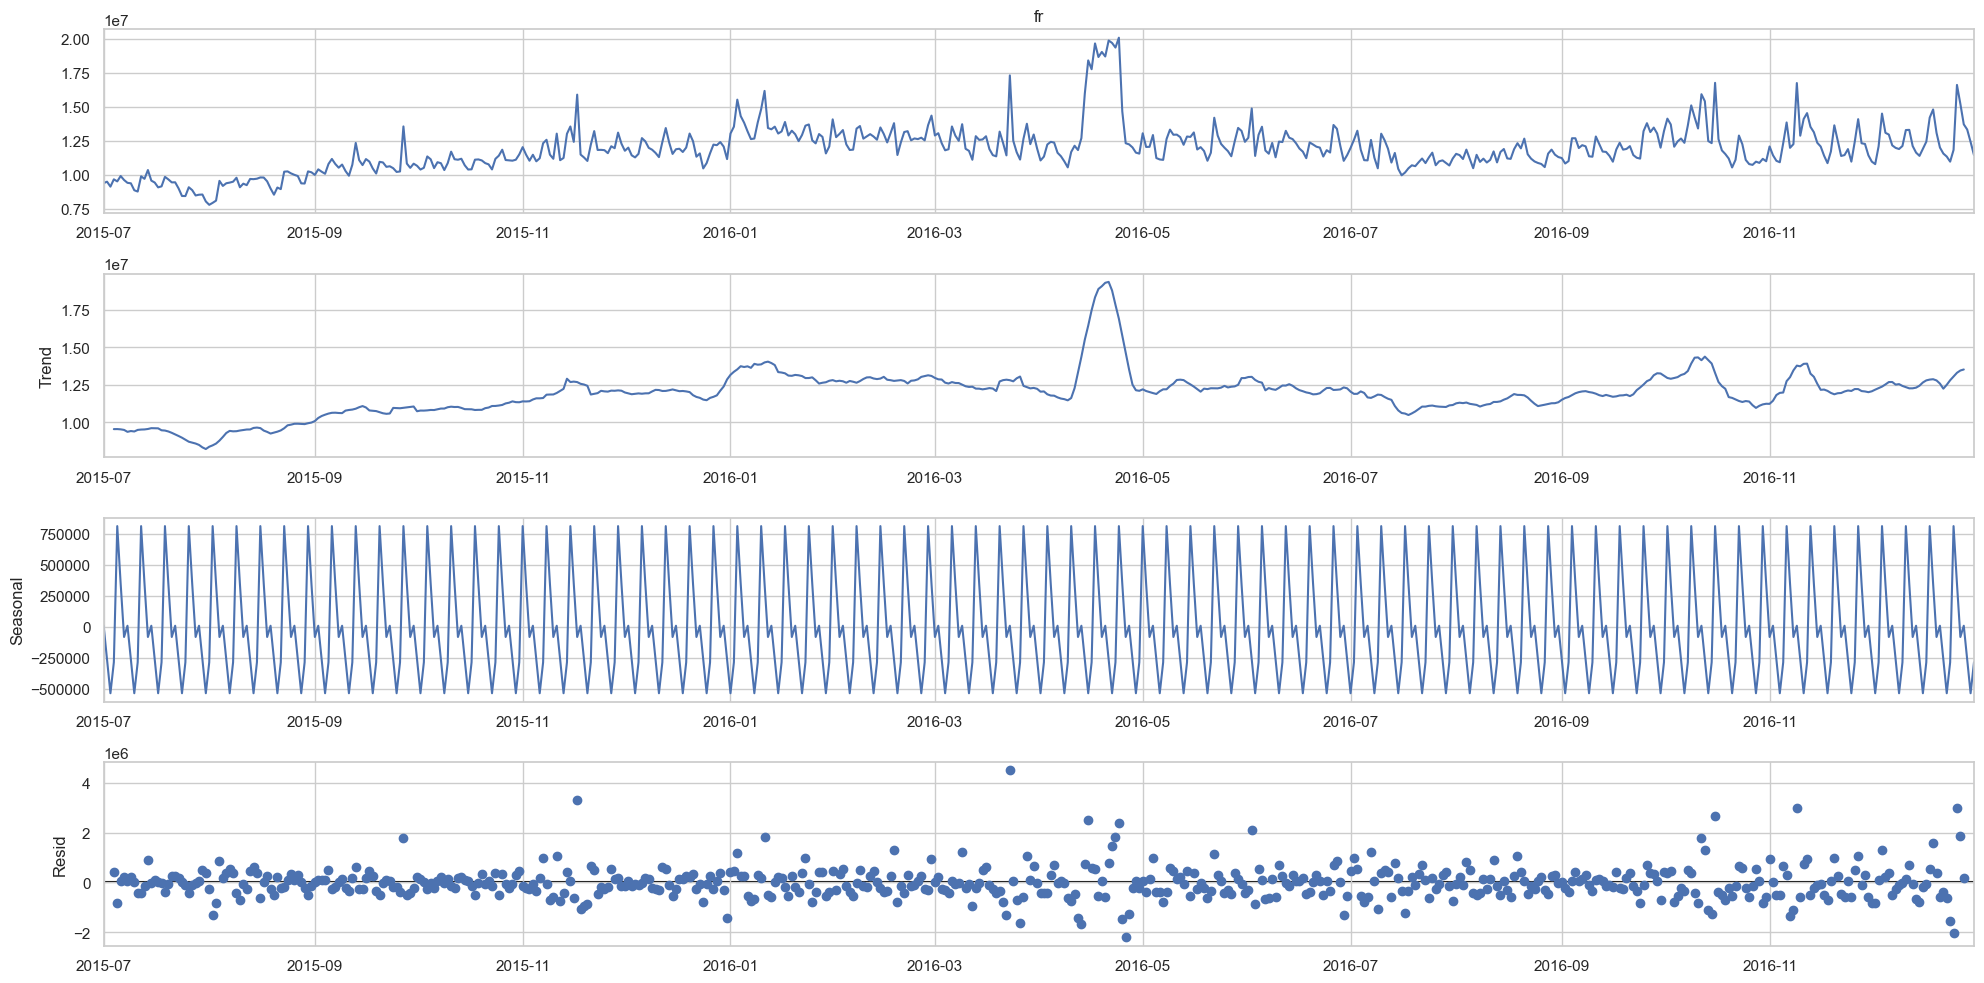

**Residuals are stationary**

#### <br/> <span style="color:blue">5. Language: ja </span> <br/>

**Original time series** (*Red lines correspond to campaign dates for English*)

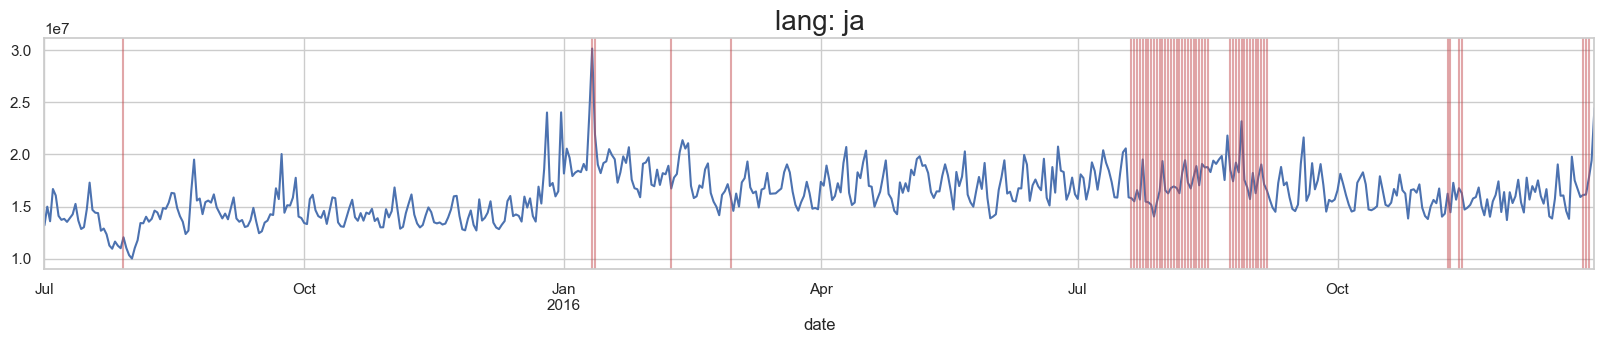

**Stationarity, ACF, and PACF**

Time series with **0-order** differencing and **no** seasonal differencing: **stationary**

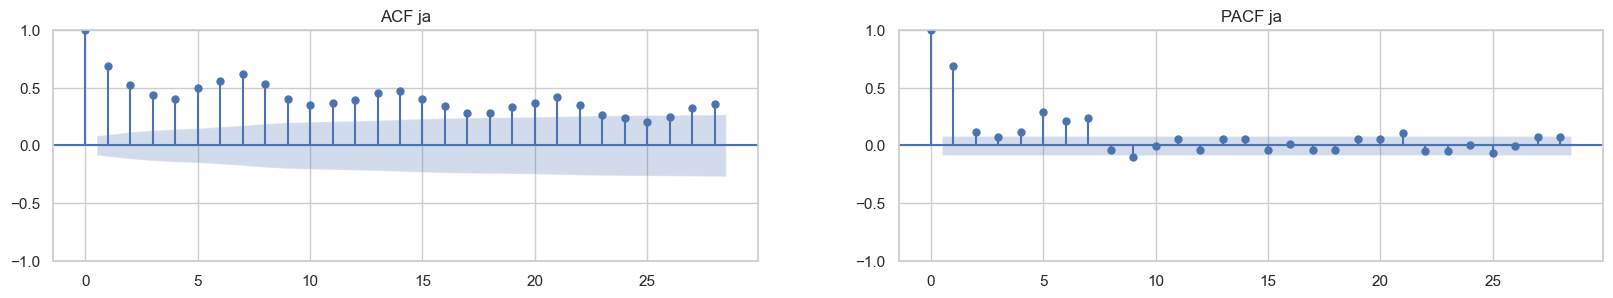

Time series with **1-order** differencing and **no** seasonal differencing: **stationary**

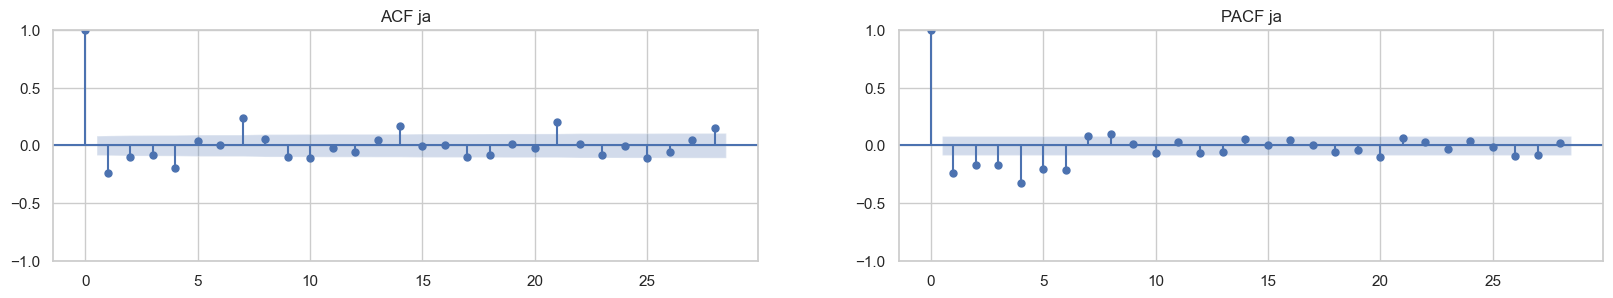

Time series with **2-order** differencing and **no** seasonal differencing: **stationary**

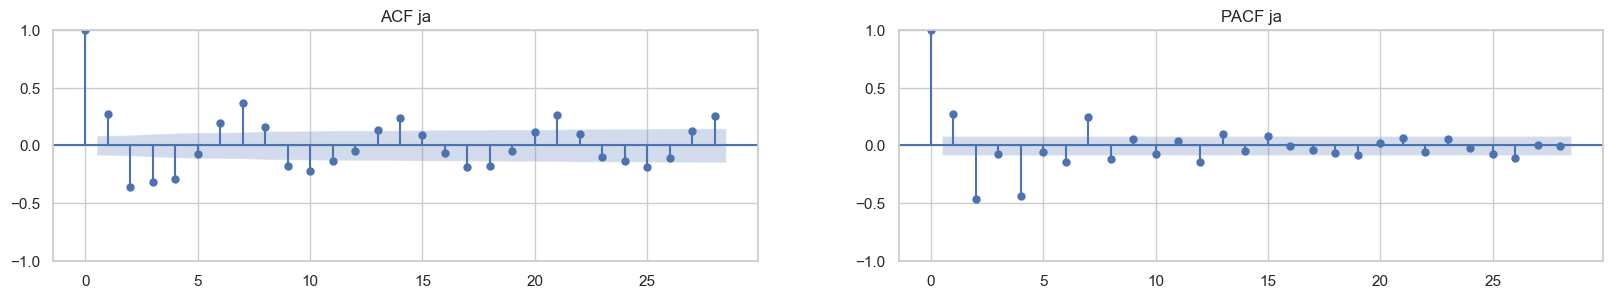

Time series with **0-order** differencing and **weekly** seasonal differencing: **stationary**

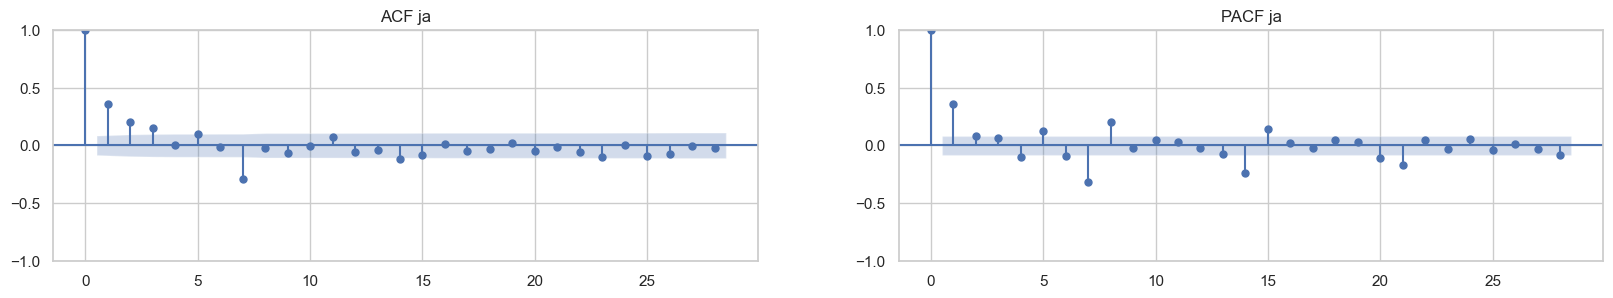

Time series with **1-order** differencing and **weekly** seasonal differencing: **stationary**

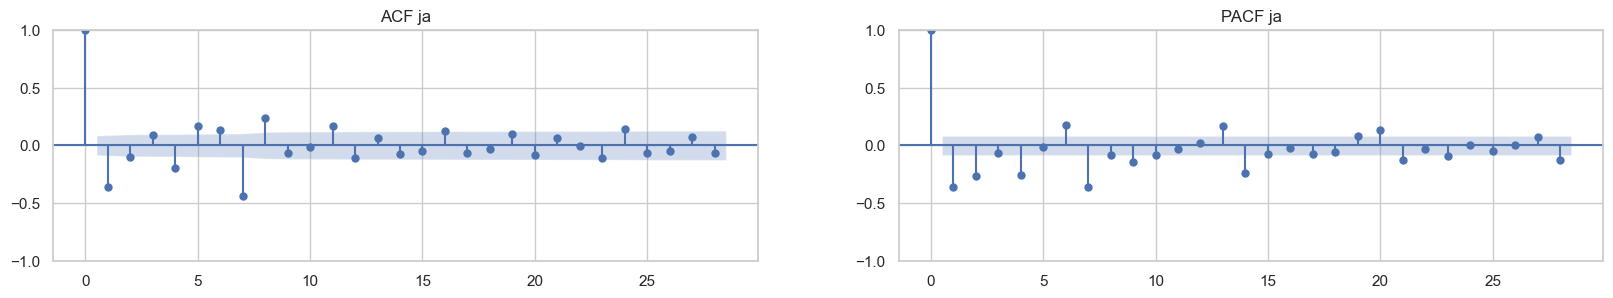

Time series with **2-order** differencing and **weekly** seasonal differencing: **stationary**

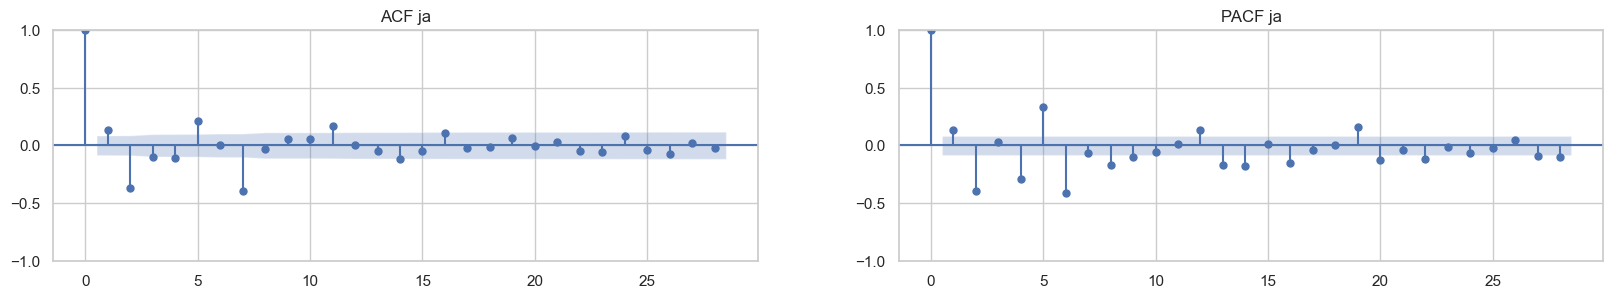

**Time Series Decomposition**

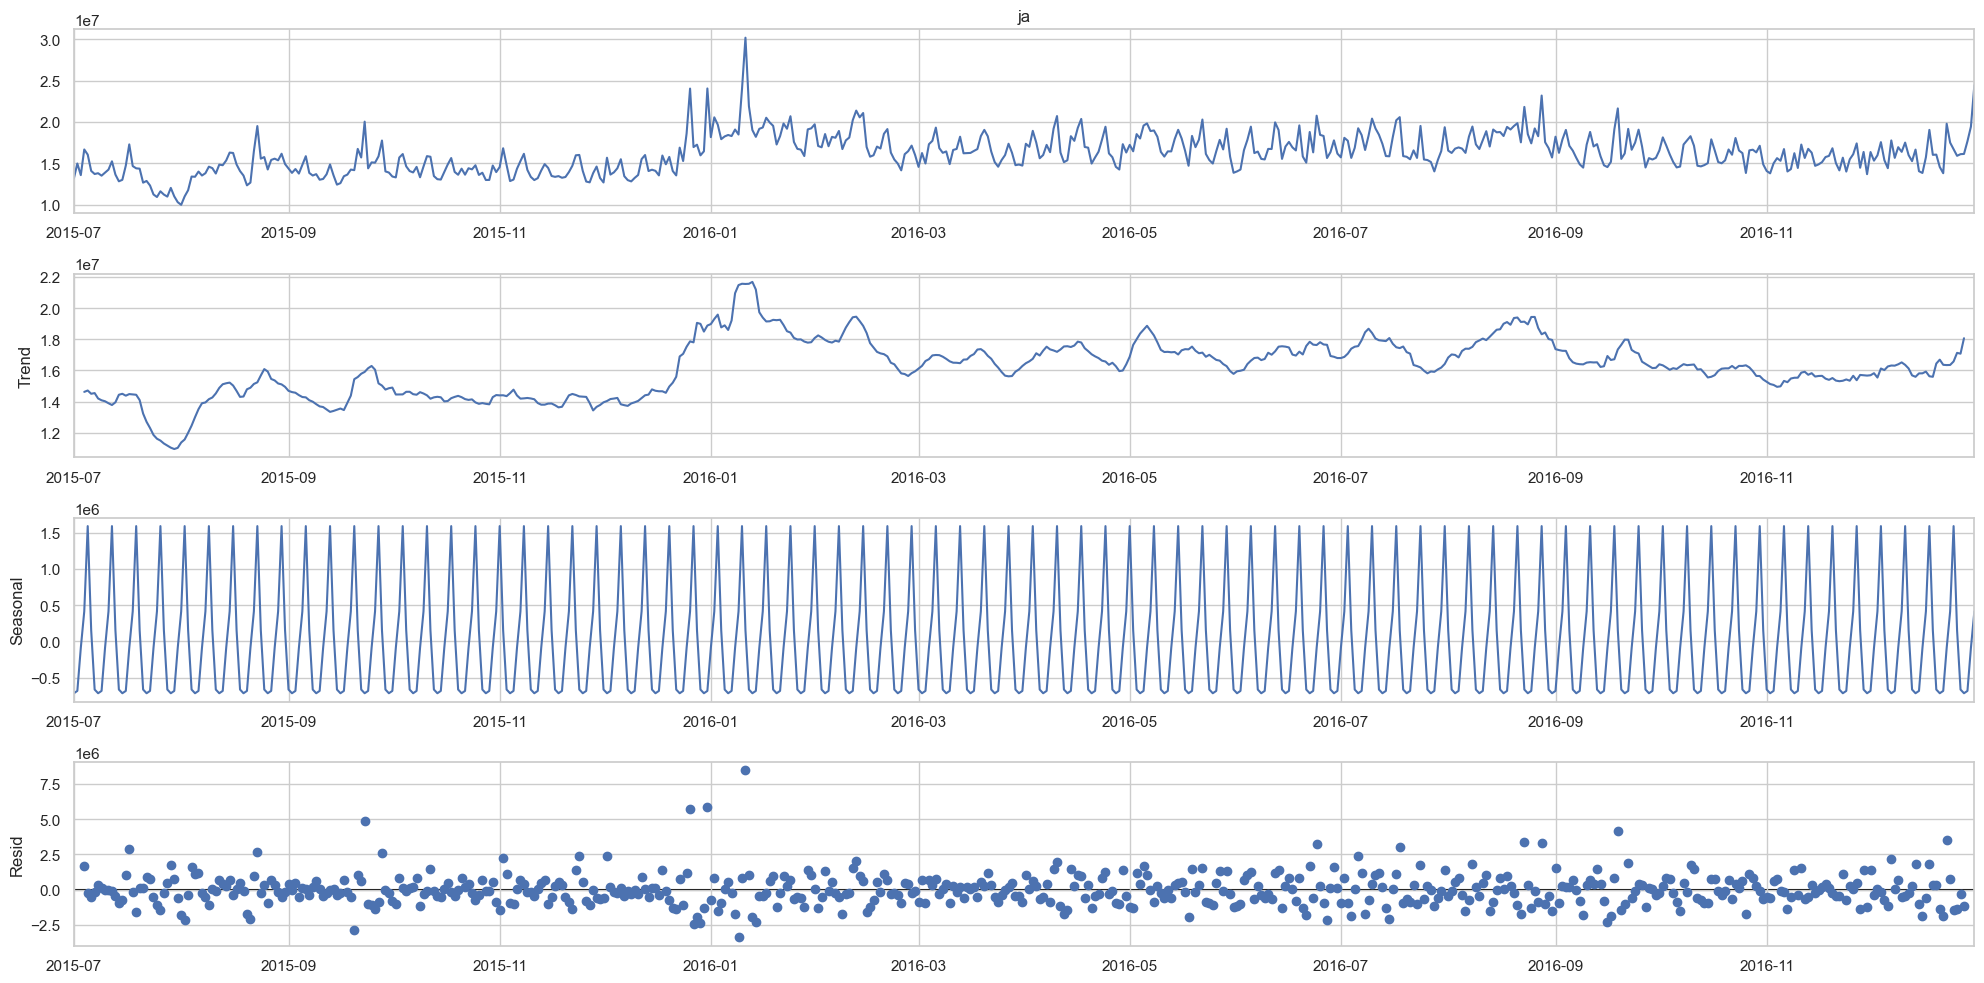

**Residuals are stationary**

#### <br/> <span style="color:blue">6. Language: ru </span> <br/>

**Original time series** (*Red lines correspond to campaign dates for English*)

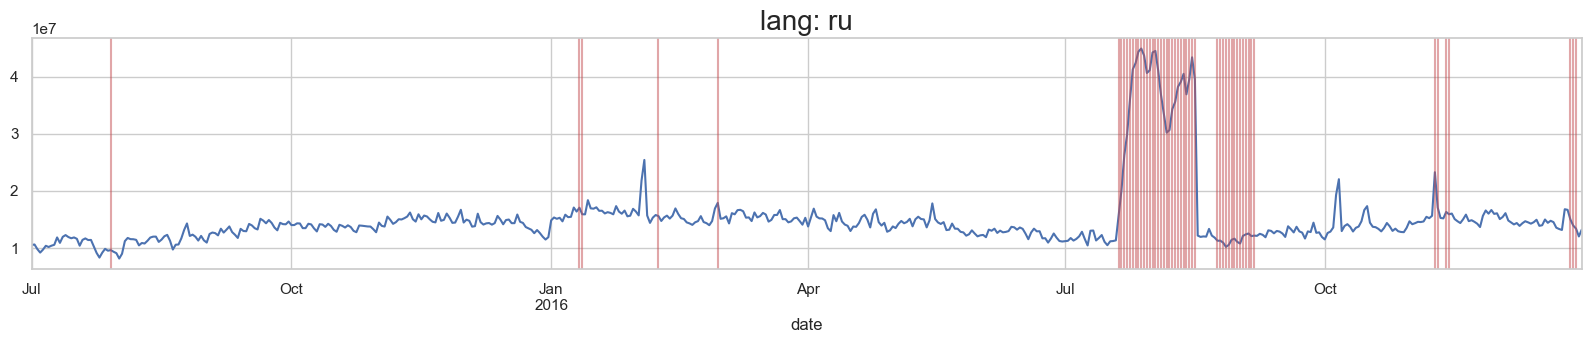

**Stationarity, ACF, and PACF**

Time series with **0-order** differencing and **no** seasonal differencing: **stationary**

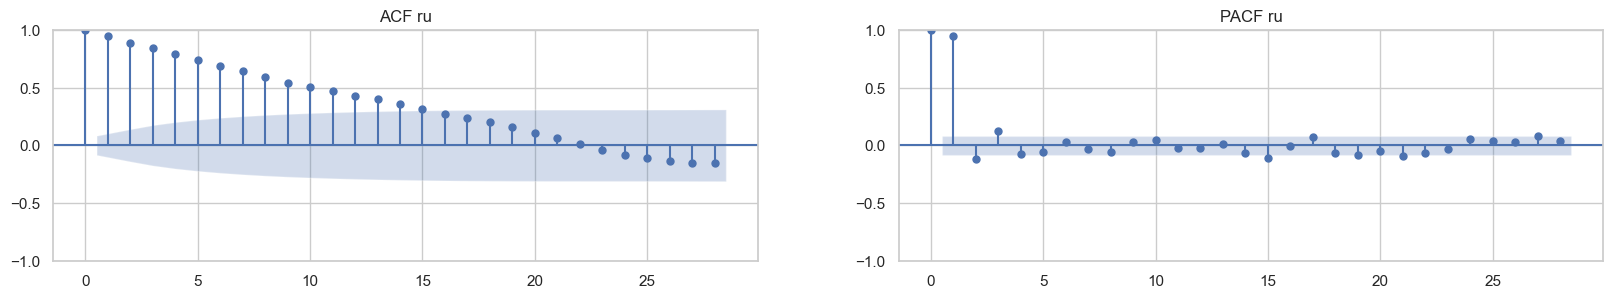

Time series with **1-order** differencing and **no** seasonal differencing: **stationary**

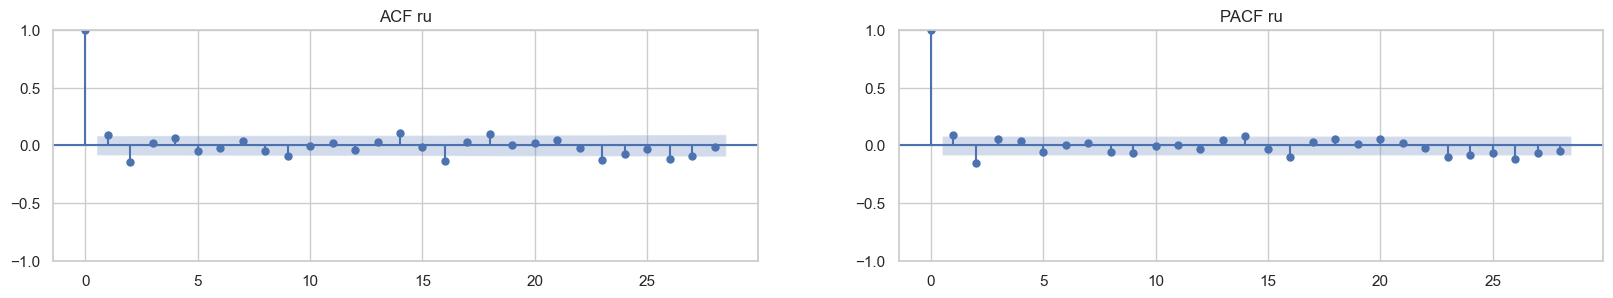

Time series with **2-order** differencing and **no** seasonal differencing: **stationary**

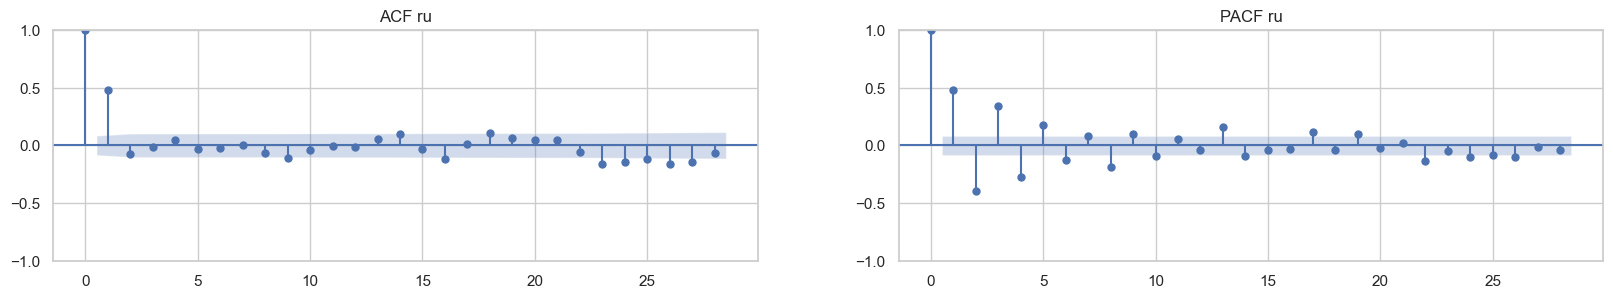

Time series with **0-order** differencing and **weekly** seasonal differencing: **stationary**

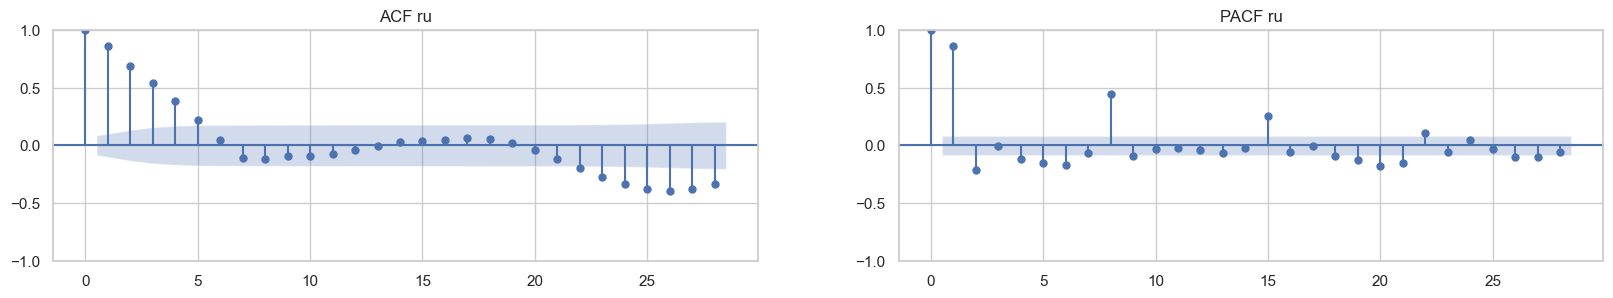

Time series with **1-order** differencing and **weekly** seasonal differencing: **stationary**

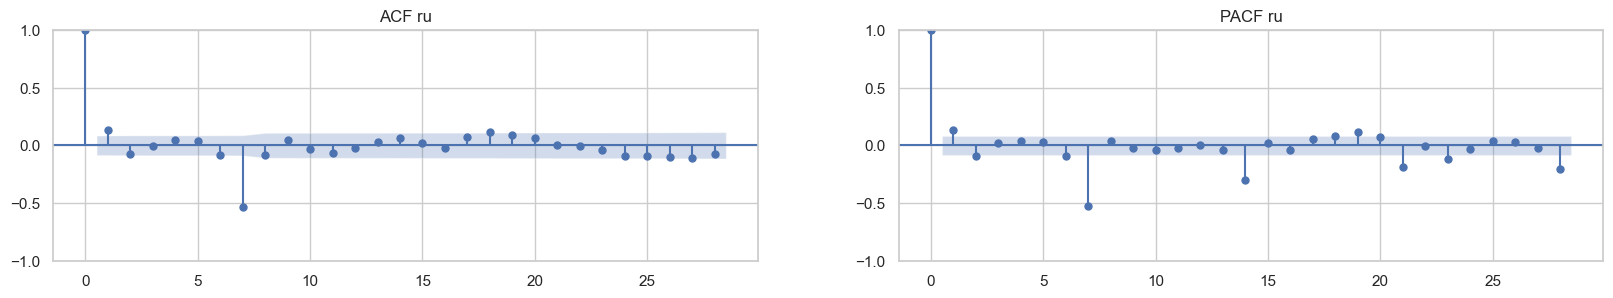

Time series with **2-order** differencing and **weekly** seasonal differencing: **stationary**

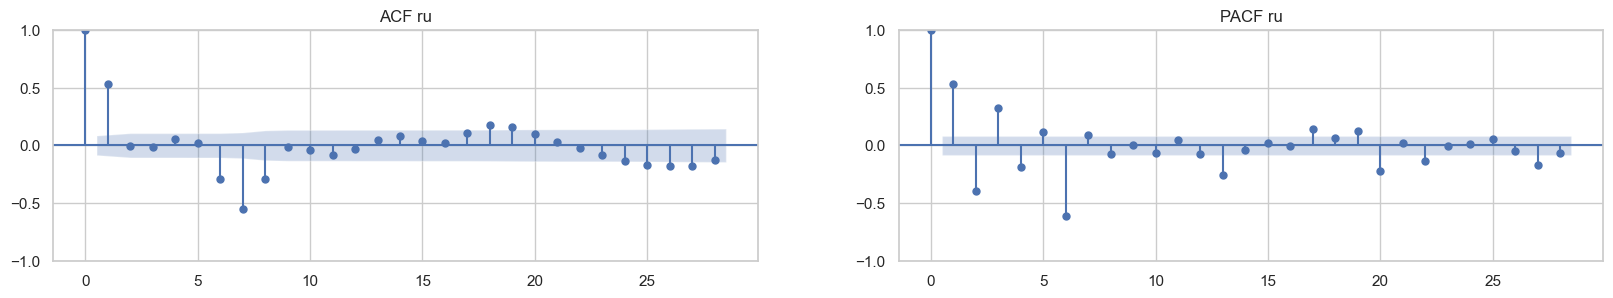

**Time Series Decomposition**

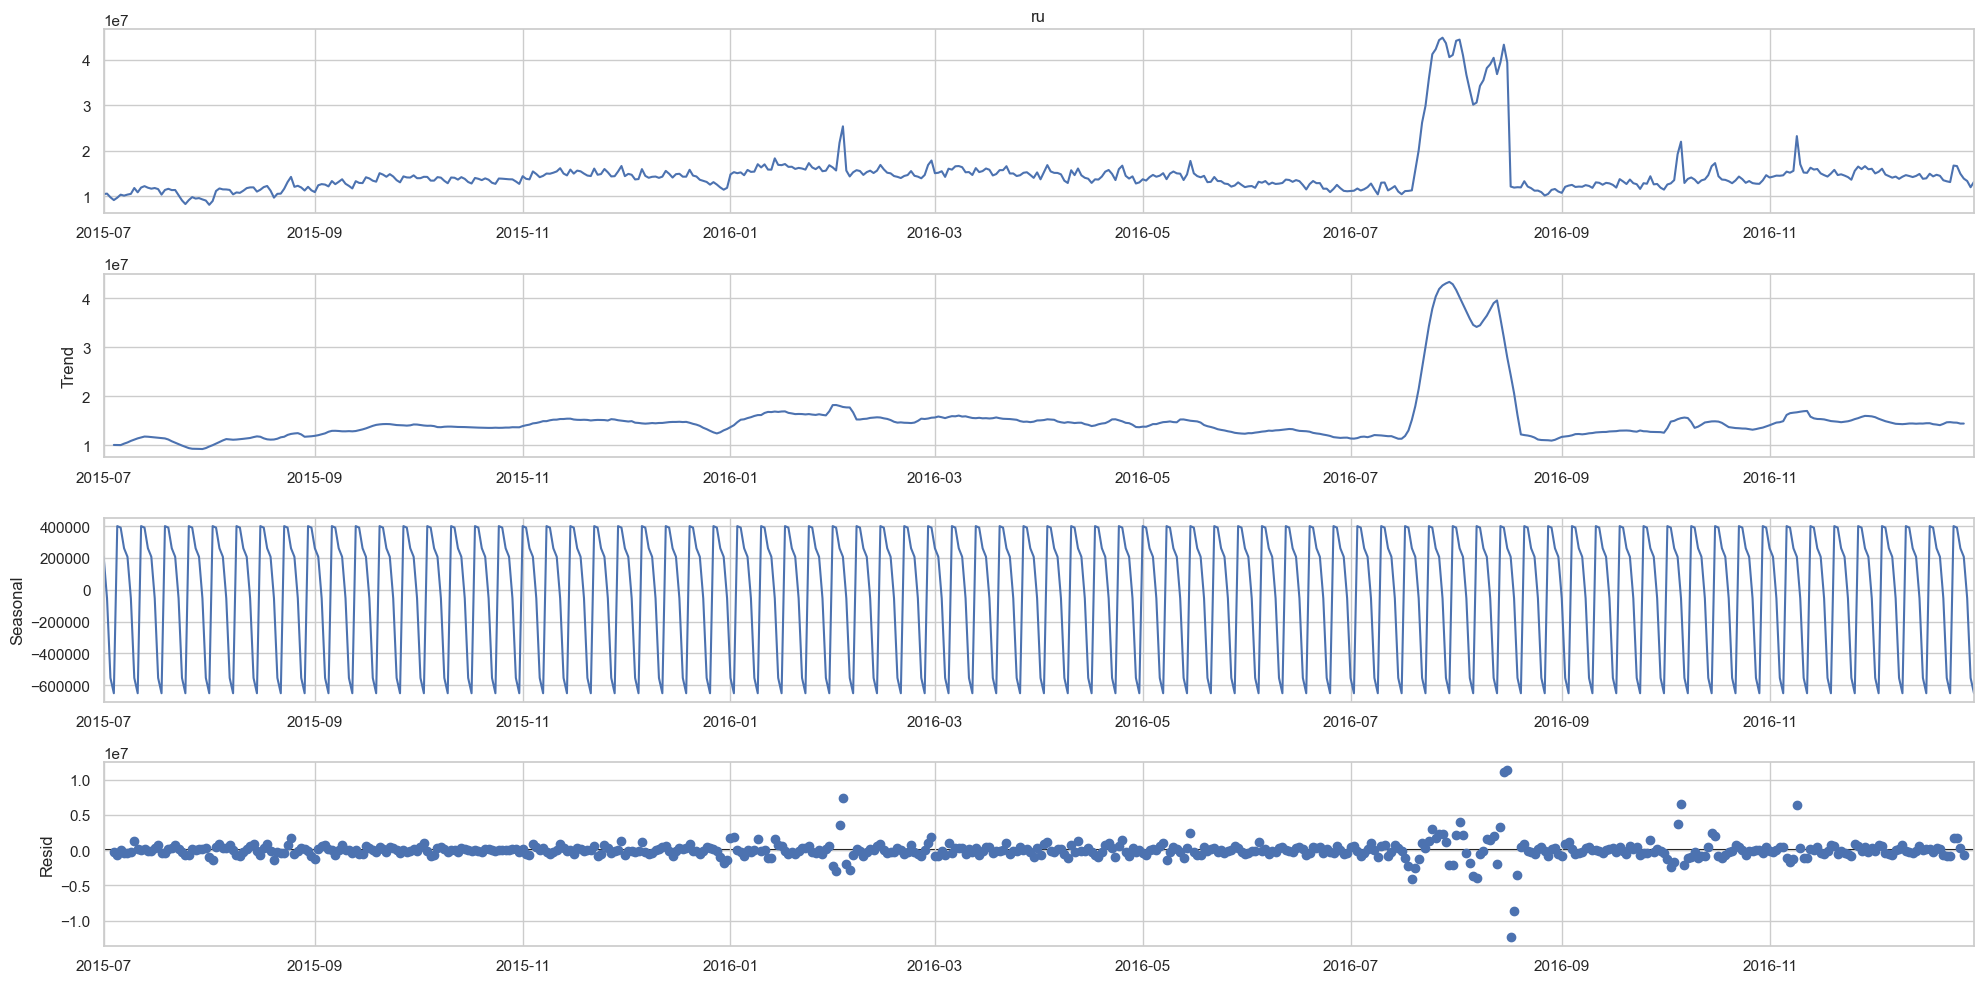

**Residuals are stationary**

#### <br/> <span style="color:blue">7. Language: zh </span> <br/>

**Original time series** (*Red lines correspond to campaign dates for English*)

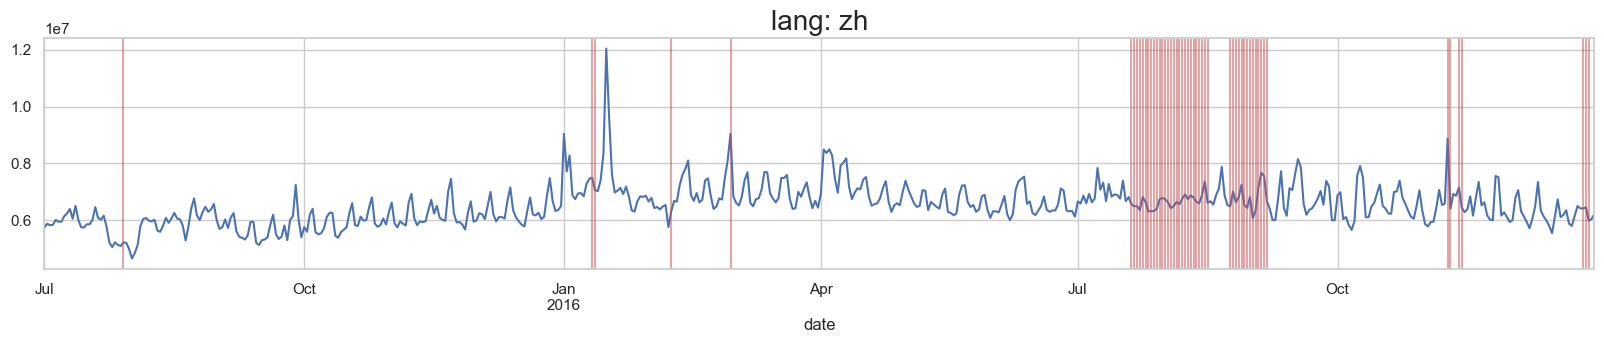

**Stationarity, ACF, and PACF**

Time series with **0-order** differencing and **no** seasonal differencing: **non-stationary**

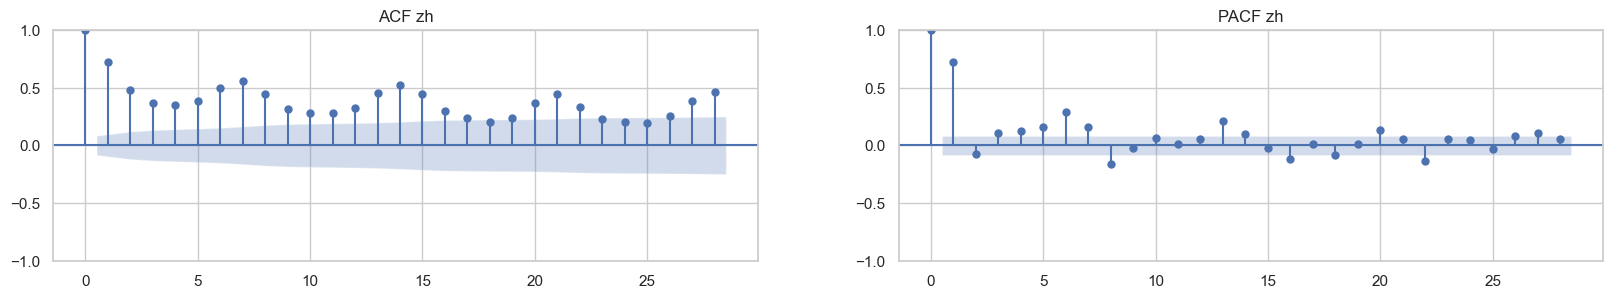

Time series with **1-order** differencing and **no** seasonal differencing: **stationary**

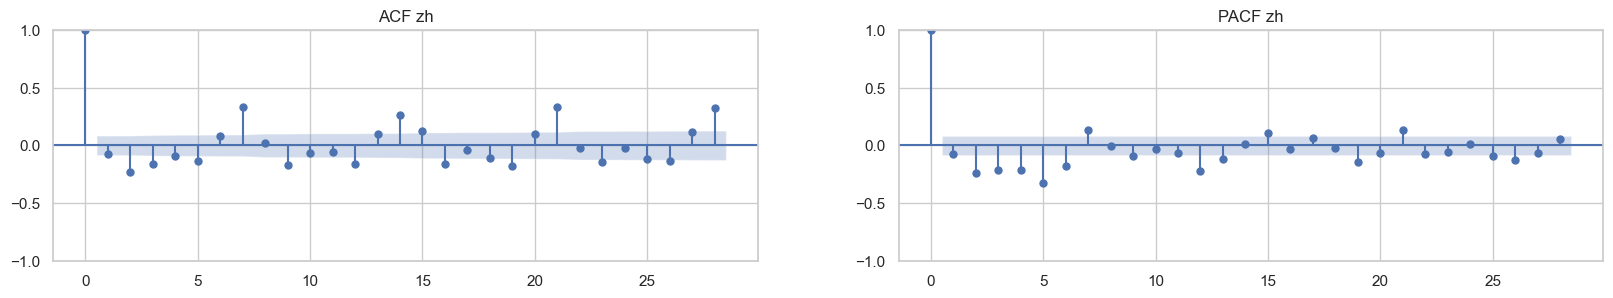

Time series with **2-order** differencing and **no** seasonal differencing: **stationary**

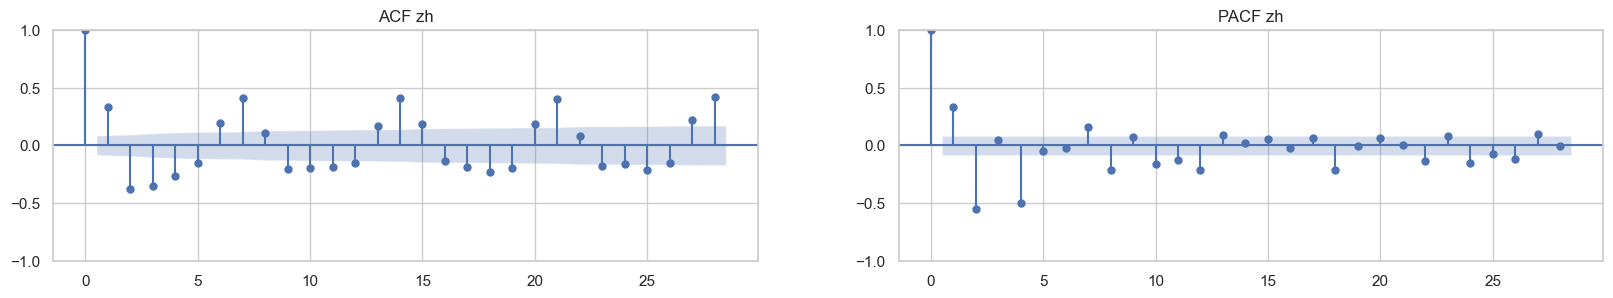

Time series with **0-order** differencing and **weekly** seasonal differencing: **stationary**

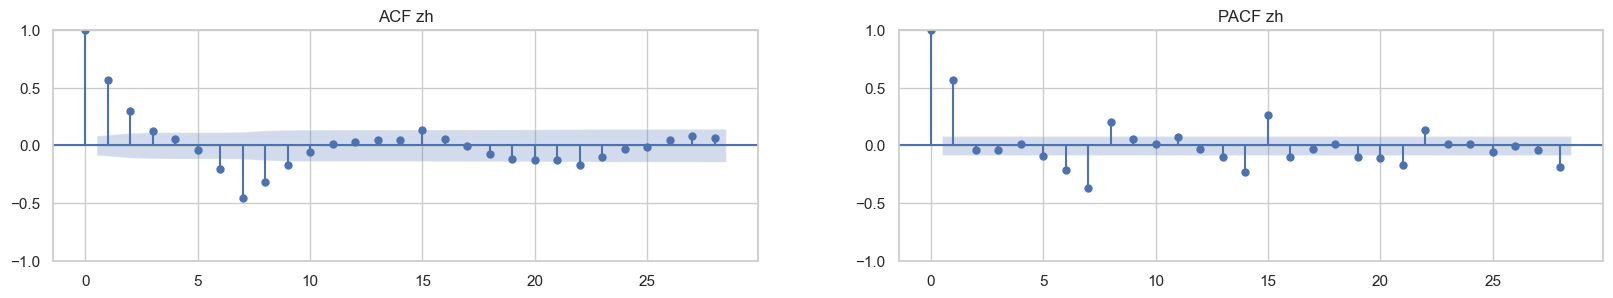

Time series with **1-order** differencing and **weekly** seasonal differencing: **stationary**

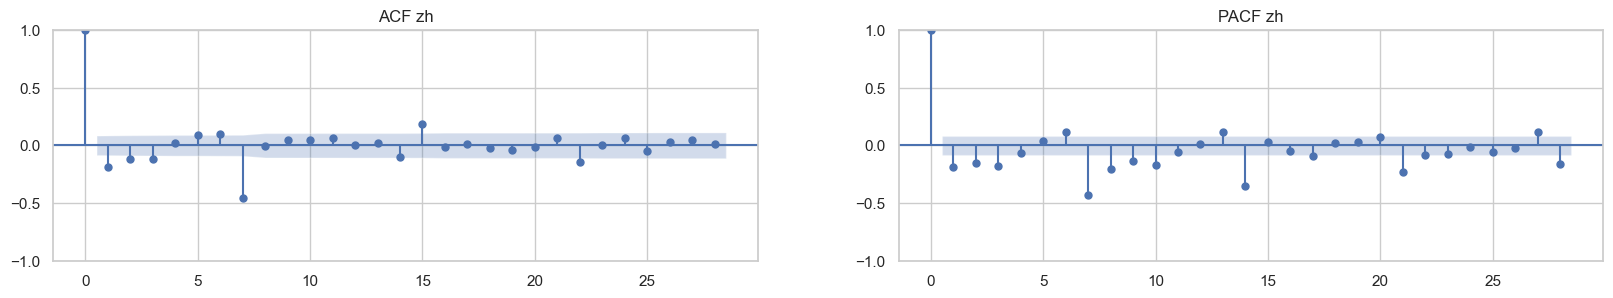

Time series with **2-order** differencing and **weekly** seasonal differencing: **stationary**

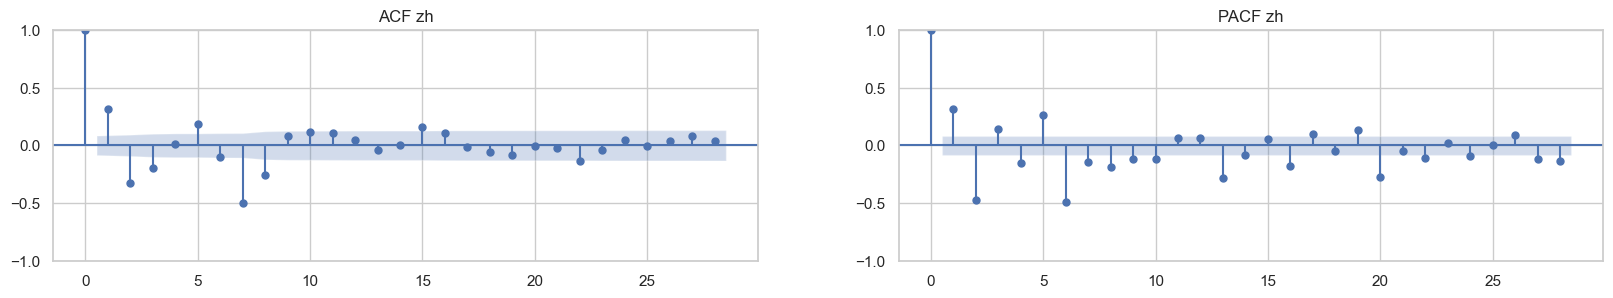

**Time Series Decomposition**

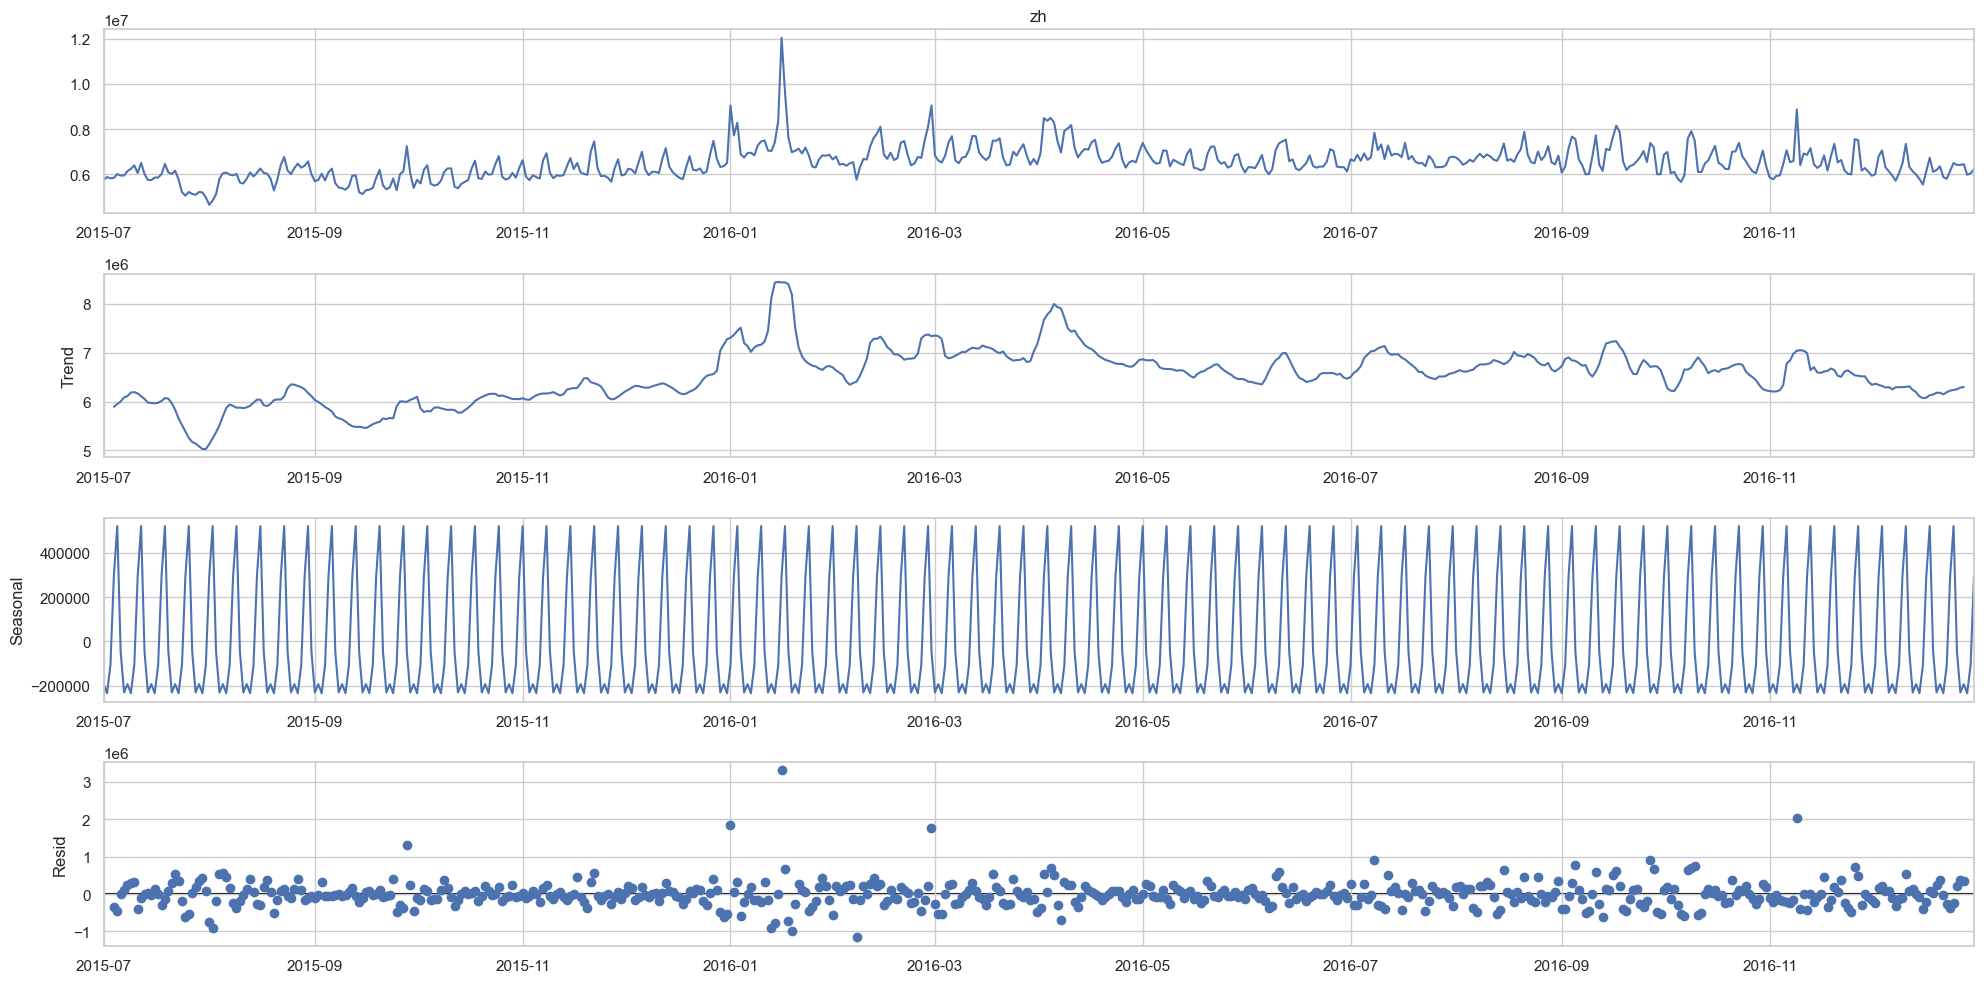

**Residuals are stationary**

In [64]:
plt.rcParams['figure.figsize'] = (20, 10)

# Analysis for each aggregated time series
for i, lang in enumerate(tsdf.columns):
    printmd(f'#### <br/> <span style="color:blue">{i+1}. Language: {lang} </span> <br/>')
    ts = tsdf[lang]
    max_order = 3
    
    #plot original time series
    printmd(f'**Original time series** (*Red lines correspond to campaign dates for English*)')
    plot_ts(ts, 'lang: '+ lang, exog_en_camp)
    plt.show()
    
    if(lang == 'en'):
        meandiff, effect = get_campaign_effect(ts, exog_en_camp)
        ts2 = adjust_campaign_effect(ts, exog_en_camp, meandiff ,action='sub', method='additive')
        ts3 = adjust_campaign_effect(ts, exog_en_camp, effect ,action='sub', method='multiplicative')
        printmd(f'**Adjusted time series** (*after removing campaign effect*)')
        #plot_ts(ts2, 'lang: '+ lang, exog_en_camp)
        plot_ts(ts3, 'lang: '+ lang, exog_en_camp)
        plt.legend()
        plt.show()
    
    #ACF and PACF plots and stationarity
    printmd(f'**Stationarity, ACF, and PACF**')
    
    for sp in [0,7]:
        for d_order in [0,1,2]:
            ts2 = ts.copy()
            if(d_order > 0):
                ts2 = ts2.diff(d_order).dropna()
            if(sp > 0):
                ts2 = ts2.diff(sp).dropna()
            
            season_period = 'weekly' if (sp > 0) else 'no'
            is_st = adf_test(ts2)
            stationarity = 'stationary' if(is_st) else 'non-stationary'
            printmd(f'Time series with **{d_order}-order** differencing and **{season_period}** seasonal differencing: **{stationarity}**')
            show_acf_pcf_plots(ts2, lang)
            plt.show()
    
    #decomposition:
    printmd(f'**Time Series Decomposition**')     
    model = sm.tsa.seasonal_decompose(ts, model='additive')
    model.plot()
    plt.show()
    
    #check stationaroty of resid
    is_resid_stationary = adf_test(model.resid.dropna())
    if(is_resid_stationary):
        printmd(f'**Residuals are stationary**')     
    else:
        printmd(f'**Residuals are non-stationary**')     
        

**Observations:** 

## Time series Modeling 

### train-test split

In [65]:
### train-test split
test_size = 30
tsdf_full = tsdf.copy()
tsdf_full['campaign_en'] = exog_en_camp.values
tsdf_full.index = pd.DatetimeIndex(tsdf_full.index, freq = 'D')

train_df = tsdf_full.loc[tsdf_full.index < tsdf_full.index[-test_size]].copy()
test_df = tsdf_full.loc[tsdf_full.index >= tsdf_full.index[-test_size]].copy()

#to be passed as cv parameter in gridsearchcv
train_test_indices = [[list(range(0, train_df.shape[0])), list(range(train_df.shape[0], tsdf_full.shape[0]))]]

print(train_df.shape)
print(test_df.shape)

(520, 8)
(30, 8)


### Utility functions

In [66]:
#function to report performance
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae, 
    mean_absolute_percentage_error as mape
)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3)) 
    print('MAPE:', round(mape(actual, predicted), 3))
    
#helper function to plot forecasts
def plot_forecasts(ts, y_hat, campaigns=None):
        
    horizon = y_hat.shape[0] - ts.shape[0]
    overlap = 20
    
    fig, axes = plt.subplots(2,1, figsize=(20,6))
    
    #plot predicitons for full ts
    ts.plot(ax=axes[0])
    y_hat.plot(ax=axes[0])   
    
    #plot zoomed in future forecasts
    ts[-overlap:].plot(ax=axes[1])
    y_hat[-horizon-overlap:].plot(ax=axes[1])
    
    if(campaigns is not None):
        campaign_dates = getcampaigndates(ts, campaigns)
        for cd in campaign_dates:
            axes[0].axvline(cd, color='r', linestyle='-', alpha=0.2)
            axes[1].axvline(cd, color='r', linestyle='-', alpha=0.2)
    
    plt.show()
    

def get_campaigns(lang):
    return tsdf_full['campaign_en'] if (lang == 'en') else None

### Hyperparameter tuning functions

In [67]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
import random as random

#helper function to retrieve param value from parameter dictionary
def paramval(param_dict, key, default_val=None):
    val = default_val
    if(param_dict is not None and key is not None):
        if(type(key) is str):
            val = param_dict[key] if(key in param_dict) else None
        elif(hasattr(key, '__iter__')):
            val = [param_dict[k] if(k in param_dict) else default_val for k in key]
    return val

#Base wrapper over time series classes with basic sklearn estimator interface 
class TimeSeriesEstimator(BaseEstimator):
    
    def __init__(self, **kwargs):
        self._id = random.randint(0,1000)
        self._parameters = {}
        self._score = None
        self._exog_vars = None
        
    def fit(self, X, y=None): pass; #implementation should come from derived classes
        
    def get_params(self, deep=True):
        return self._parameters
    
    def set_params(self, **parameters):
        self._parameters = parameters
        
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
    
        return self
    
    def get_endog_exog(self, X, mp=None):
        exog_vars = None 
        if(mp is not None):
            self._exog_vars = exog_vars = paramval(mp, 'exog_vars') 
        else: 
            exog_vars = self._exog_vars
            
        endog, exog = None, None
        if(exog_vars is not None):
            exog = X[exog_vars]
            
        endog = X[X.columns[0]]
        return endog, exog

#custom time series score function (mape)
def ts_score(est, X, y=None):
    score = 0
    if(est is not None):
        if(est._score is not None):
            return est._score
        elif(est._model_fit is not None):
            y_actual, exog = est.get_endog_exog(X)
            y_pred = est._model_fit.forecast(steps=y_actual.shape[0], exog=exog)
            est._score = score = round(mape(y_actual, y_pred), 3)
    return -score #return negative so that gridsearch can pick the one with lowest MAPE

#SARIMAX base wrapper
class SarimaxTimeEstimator(TimeSeriesEstimator):
     
    def fit(self, X, y=None):
        #read params
        mp = self.get_params()        
        
        #retrieve endog and exog from params
        endog, exog = self.get_endog_exog(X, mp)
        if('p' in mp or 'd' in mp or 'q' in mp):
            order = paramval(mp, ['p','d','q'], 0)
        else:
            order = None
        if('P' in mp or 'D' in mp or 'Q' in mp or 's' in mp):
            seasonal_order = paramval(mp, ['P','D','Q','s'], 0)
        else:
            seasonal_order = None
            
        model = SARIMAX(endog, exog=exog, order=paramval(mp, ['p','d','q'], 0), seasonal_order=paramval(mp, ['P','D','Q','s'], 0)) 
        self._model_fit = model.fit(disp=False)
        
        return self    

#helper function to hyper tune model parameters and return results in dataframe
def hyper_tune(gs, X):
    gs.fit(X, None)
    
    res = pd.DataFrame(gs.cv_results_['params']).assign(
    mape = -gs.cv_results_['mean_test_score'])
    res = res.sort_values(by='mape', ascending=True)
    res = res[~res['mape'].isna()]
    
    return gs.best_params_, res


## ARIMA family of models

In [68]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

def get_sarimax_params(ts_params):
    s_params = {
        'order': paramval(ts_params, ['p','d','q'], 0),
        'seasonal_order': paramval(ts_params, ['P','D','Q','s'], 0)
    }
    return s_params
        
def get_sarimax_model(ts, exog, s_params):
    
    model = SARIMAX(ts, exog=exog, **s_params) 
    model = model.fit(disp=False)

    return model

def run_sarimax(lang, tsdf_full, train_df, test_df, test_size, parameters):
    
    train_ts = train_df[lang].copy()
    test_ts = test_df[lang].copy()
    horizon = 0
    
    #fetch campaign details (if applicable)
    campaigns, campaigns_test, campaigns_train, campain_en_data_full, campain_en_data_pred = get_campaigns(lang), None, None, None, None
    if(campaigns is not None):
        campaigns_test = campaigns[-test_size:]
        campaigns_train = campaigns[:train_ts.shape[0]]
        campain_en_data_full = campaigns.append(pd.Series([0]*horizon)).reset_index(drop=True)
        campain_en_data_pred = campaigns_test.append(pd.Series([0]*horizon)).reset_index(drop=True)
    
    gs_ts = GridSearchCV(SarimaxTimeEstimator(), parameters, cv=train_test_indices, scoring=ts_score, refit=False)
    best_params, tuning_res = hyper_tune(gs_ts, tsdf_full[['en', 'campaign_en']])
    model_params = get_sarimax_params(best_params)
    
    print('hyperparameter tuning result:')
    print(tuning_res.head(10))
    print(f'Parameters with best MAPE: {best_params}')
    print(f'Building final model:')    
    
    #build final model   
    model = get_sarimax_model(tsdf_full[lang], campaigns, model_params)
    
    #forecast/predict
    y_forecast = model.forecast(steps=test_df.shape[0], exog=campaigns_test)
    y_pred = model.predict(0, tsdf_full.shape[0]+horizon-1, exog=campain_en_data_pred)
    y_pred2 = model.predict(0, tsdf_full.shape[0]-1, exog=campaigns)
    
    # Plot and evaluate performance
    performance(tsdf[lang], y_pred2)
    plot_forecasts(tsdf[lang], y_pred, campaigns = campain_en_data_full)

### ARIMA model

In [69]:
#run ARIMA for 'en'
parameters = {
    'p' : [7],
    'd' : [1],
    'q' : [3,5,7]
}
run_sarimax('en', tsdf_full, train_df, test_df, test_size, parameters)

NotFittedError: All estimators failed to fit

### SARIMA model

In [ ]:
#run SARIMA for 'en'
parameters = [
    { 
        'p' : [3,6],
        'd' : [1],
        'q' : [3,5,7],
        'P' : [0,1],
        'D' : [1],
        'Q' : [1,3,5],
        's' : [7]
    },
    { 
        'p' : [3,6,7,14,21,24],
        'd' : [1],
        'q' : [3,5,7],
        'P' : [0,1],
        'D' : [1]
    }
]

run_sarimax('en', tsdf_full, train_df, test_df, test_size, parameters)

### SARIMAX model with campaigns exogenous variable

In [ ]:

parameters = [
    { 
        'exog_vars': [['campaign_en']],
        'p' : [3,6],
        'd' : [1],
        'q' : [3,5,7],
        'P' : [0,1],
        'D' : [1],
        'Q' : [1,3,5],
        's' : [7]
    },
    { 
        'exog_vars': [['campaign_en']],
        'p' : [3,6,7,14,21,24],
        'd' : [1],
        'q' : [3,5,7],
        'P' : [0,1],
        'D' : [1]
    }
]


run_sarimax('en', tsdf_full, train_df, test_df, test_size, parameters)

**Observations:**

**For ARIMA model, the best MAPE score is 6.5%. For SARIMA and SARIMAX models, the best MAPE score is 4.1%.**

## Forecasting using Prophet

In [ ]:
from prophet import Prophet

def prepare_phophet_df(df, lang, campaigns):
    ret = df.copy()[[]]
    ret['ds'] = pd.to_datetime(ret.index)
    ret['y'] = df[lang]
    if(campaigns is not None):
        ret['campaign'] = campaigns.values
    return ret
    
for lang in tsdf.columns:
    
    campaigns, campaigns_test = get_campaigns(lang), None
    tsdf_pr = prepare_phophet_df(tsdf_full, lang, campaigns)    
    
    m = Prophet(weekly_seasonality=True)
    
    if(campaigns is not None):
        m.add_regressor('campaign')
        campaigns_test = campaigns[-test_size:]
    
    m.fit(tsdf_pr[:-test_size])
    
    future = m.make_future_dataframe(periods=test_size, freq='D')
    if(campaigns is not None):
        future['campaign'] = campaigns.values
        
    #plot results
    forecast = m.predict(future)
    
    fig = m.plot(forecast, figsize=(10,4));
    ax = fig.axes[0]
    ax.set_title(f'language: {lang}')
    
    ts = tsdf_pr['ds']
    
    #plot campaign lines
    if(campaigns is not None):
        camp_dates_all = ts.index[campaigns[campaigns == 1].index]
        camp_dates_test = ts.index[campaigns_test[campaigns_test == 1].index]
    
        for cd in camp_dates_all:
            ax.axvline(cd, color='r', linestyle='-', alpha=0.2)
    
    plt.show()
    
    performance(tsdf_pr['y'], forecast['yhat'])

**OBservations:** 

1. For 'en' time-series, we got MAPE of 5.8%. 

2. The lowest MAPE of 5% was recorded for 'zh' page time-series. The highest MAPE was recorded for 'ru' pages at 16.5%. This is expected, as for 'ru' pages, we see a very high increase in visits during campaign days for 'en' language. Since we have consciously not added campaign effect in any non-english pages, the MAPE is high.

## Questionnaire 

#### 1. Defining the problem statements and where can this and modifications of this be used?

Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. The problem statement is as follow. The ask is to understand the per page view report for different wikipedia pages across regions and forecasting the number of views so that Ad Ease can predict and optimize the ad placement for their clients who belong to different regions. Since data at individual page level is sparse, we aggregate views at language level and forecast. These forecasts can then be potentially redistributed at individual pages to identify pages which are likely to get maximum views. The advertisements should be placed on such pages to increase its reach and garner maximum clicks.

### 2. Write 3 inferences you made from the data visualizations

1. Time series data at individual pages is often sparse. When we checked a small sample of individual pages, most of them had stationary time series. The ones with non-stationary time series had weekly seasonality effects.

2. After aggregating data at language levels, all aggregated time series became non-stationary. All time series became stationary after applying first-order differencing and/or weekly seasonal differencing. We could confirm this through ACF/PCAF plots and stationarity tests. 

3. We observed that 'en' campaigns had positive impact on number of views on 'en' pages. The average increase was around 55%. Interestingly, the number of views on 'ru' pages increased around 85% during the 'en' campaign days. This could be because of several reasons. First, campaign designed for 'en' pages may also have reached 'ru' viewers. Second, there could have been similar campaign running on the same days for 'ru' pages, for which we do not have data for. Third, there could be another confounding variable impacting both 'en'/'ru' pages and campaign days. Since we do not know for sure, in our models for 'ru' page, we have chosen not used 'en' campaign data as an exogenous variable. 

### 3. What does the decomposition of series do?

The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. The components are trend, cycle, seasonality, and noise (irregular components). 

### 4. What level of differencing gave you a stationary series?

For most language pages, first order differencing or weekly seasonal differencing was sufficient to obtain stationary series.

### 5. Compare the number of views in different languages

In [ ]:
print('average daily visits (in millions)')
tsdf.mean() / 1000000

In [ ]:
visits_sum = tsdf.sum()
page_counts = df_backup.groupby('lang')['lang'].count()
print('average daily visits per page')
(visits_sum / (page_counts*550)) 

**As we can English by far has the highest number of average total daily visits (across pages) and also highest number of daily visits per page.**

#### 6. What other methods other than grid search would be suitable to get the model for all languages?

Using AutoArima library is one option to reduce the hyper parameter tuning effort for AARIMA family of models. Another potential approach is to use boosted regression trees (XGBoost or liteGBM) and explicitly pass various lagged time variables, lagged seasonal variables, language indicator, as well as exogenous variables such as campaigns. The expectation is for the regression tree algorithm to identify most important variables (which must include lang as well), and build several regression trees at leaf level. This approach may prove to be faster and more scalable as it may be sufficient to build a single model which may take care of all languages' time series. 